In [1]:
%matplotlib inline
import tensorflow_addons as tfa
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy, CategoricalHinge, Recall, Precision
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
# from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
import h5py
import os

tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)


#np.random.seed(368)
#tf.random.set_seed(368)

In [2]:
xfile='C:\\workspace\\j6stock\\xau_usd_OHLC2.0Tp1.0Cl100Vp.txt'

seq_len = 60*6 #60*10 # 3 days + 2 features is enough memory
batch_size = int(2048/3)       # Batch size
# mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 500


y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


upperTailFilter = 0.4
lowerTailFilter = 0.4

import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web



def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    global upperTailFilter, lowerTailFilter
    
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    df['tail_upper'] = df['high'].copy()
    df['tail_lower'] = df['low'].copy()
    for i, row in df.iterrows():
        df.at[i, 'tail_upper'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'tail_lower'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    
    df.dropna(inplace=True)
    df.drop('open', axis=1, inplace=True)
    df.drop('high', axis=1, inplace=True)
    df.drop('low', axis=1, inplace=True)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean() 
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
#         df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1)) # no rescale for keep the negative value
        df['tail_upper'] = min_max_scaler.fit_transform(df['tail_upper'].values.reshape(-1,1))
        upperTailFilter = min_max_scaler.transform([[upperTailFilter]])[0][0] 
        df['tail_lower'] = min_max_scaler.fit_transform(df['tail_lower'].values.reshape(-1,1))
        lowerTailFilter = min_max_scaler.transform([[lowerTailFilter]])[0][0] 
        
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))   
                #pd.concat([min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1)), df], axis=1)
                ma_data = df['{}ma'.format(moving)]
                df.drop(labels=['{}ma'.format(moving)], axis=1, inplace=True)
                df = pd.concat([ma_data, df], axis=1)
    df.dropna(inplace=True)

    
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)

    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data(ma=[60, 240])

# amount_of_features = len(df.columns)-1+(input2Length*-1)

# def load_data(stock, seq_len):
#     print ("Amount of features = {}".format(amount_of_features))
#     data = stock.as_matrix()
#     sequence_length = seq_len + 1 # index starting from 0
#     x_result = []
#     x_result2 = []
#     y_result = []
#     for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
#         x_result.append(data[index-seq_len: index,
#                              :-1 + (input2Length*-1) # -2 is ignore Input2 features
#                             ]) # index : index + 22days
#         x_result2.append(data[index, -1 + (input2Length*-1):-1])
#         y_result.append(data[index ,-1]);

#     x_result, x_result2, y_result = shuffle(x_result, x_result2, y_result , random_state=2)

#     #print('---', data[0])
#     #print('---', x_result[0])
#     #print('---', y_result[0])
#     x_result = np.array(x_result)
#     x_result2 = np.array(x_result2)
#     y_result = np.array(y_result)
#     print ("Amount of data = {}".format(y_result.shape[0]))

#     percentageSplit = 0.5 # 60% split
#     row = round(percentageSplit * y_result.shape[0]) 
#     print ("Split = {}".format(row))
 
#     X_train = x_result[:int(row), :] 
#     X_train2 = x_result2[:int(row), :] 
#     y_train = y_result[:int(row)] 
#     print ("Amount of training data = {}".format(y_train.shape[0]))
#     X_test = x_result[int(row):, :]
#     X_test2 = x_result2[int(row):, :]
#     y_test = y_result[int(row):]
#     # filter for 1 and -1 for validation only
#     X_test = X_test[y_test[:]!=0,:]
#     X_test2 = X_test2[y_test[:]!=0,:]
#     y_test = y_test[y_test[:]!=0]
    
#     # split 50% again for test and validation set
#     row = round(percentageSplit * y_test.shape[0]) 
#     X_val = X_test[int(row):, :]
#     X_val2 = X_test2[int(row):, :]
#     y_val = y_test[int(row):]
#     print ("Amount of validation data = {}".format(y_val.shape[0]))
#     X_test = X_test[:int(row), :]
#     X_test2 = X_test2[:int(row), :]
#     y_test = y_test[:int(row)]
#     print ("Amount of testing data = {}".format(y_test.shape[0]))
#     #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
#     #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
#     #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))    
#     return [X_train, X_train2, y_train, X_test, X_test2, y_test, X_val, X_val2, y_val]



classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.transform([-1, 0, 1])

df_to_dataset = df[[ 'change', '60ma', '240ma'
                   ]].copy()
df_to_dataset_input2 = df[[ 'tail_upper', 'tail_lower', 'change' ,'cross_360p_high', 'cross_1440p_high'
                          ]].copy()

amount_of_features = len(df_to_dataset.columns)
input2Length = len(df_to_dataset_input2.columns)

df.drop(labels=['close'], axis=1, inplace=True)
df.drop(labels=['change'], axis=1, inplace=True)
df.drop(labels=['tail_upper'], axis=1, inplace=True)
df.drop(labels=['tail_lower'], axis=1, inplace=True)
df.drop(labels=['cross_360p_high'], axis=1, inplace=True)
df.drop(labels=['cross_1440p_high'], axis=1, inplace=True)

df_to_dataset_y = lb.transform(df[['y_result']].copy())
df.drop(labels=['y_result'], axis=1, inplace=True)

train_data_no = int(len(df_to_dataset_y)/2)
test_data_no = int(train_data_no/2)
v_data_no = test_data_no

train_x_1 = df_to_dataset.iloc[:train_data_no].values
train_x_2 = df_to_dataset_input2.iloc[:train_data_no].values
train_y = df_to_dataset_y[:train_data_no]                                                   

test_x_1 = df_to_dataset.iloc[train_data_no:train_data_no+test_data_no].values
test_x_2 = df_to_dataset_input2.iloc[train_data_no:train_data_no+test_data_no].values
test_y = df_to_dataset_y[train_data_no:train_data_no+test_data_no]                                                   

v_x_1 = df_to_dataset.iloc[train_data_no+test_data_no:].values
v_x_2 = df_to_dataset_input2.iloc[train_data_no+test_data_no:].values
v_y = df_to_dataset_y[train_data_no+test_data_no:]                                                   


def make_window_dataset(ds, window_size=seq_len, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def batch(sub):
    ret = ()
    for index in range(2):
      ret = ret + ( sub[index].batch(window_size, drop_remainder=True), )
    return ret
  def sub_to_batch(sub, sub2): 
    return tf.data.Dataset.zip((batch(sub), (sub2.batch(window_size, drop_remainder=True))))
  
  windows = windows.flat_map(sub_to_batch)
  windows = windows.map(lambda sub1, sub2: ((sub1[0], sub1[1][-1:][0]), (sub2[-1:][0] #, sub2[-1:][0]
                                                                        )))
  return windows

def filter_fn(a, b):
#   return a[1][0]>=upperTailFilter or a[1][1]>=lowerTailFilter or a[1][3]==1 or a[1][4]==1
  return a[1][3]==1

train_dataset_x = tf.data.Dataset.from_tensor_slices(((train_x_1, train_x_2),(train_y)))
train_dataset = make_window_dataset(train_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True) 

test_dataset_x = tf.data.Dataset.from_tensor_slices(((test_x_1, test_x_2),(test_y)))
test_dataset = make_window_dataset(test_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True)

v_dataset_x = tf.data.Dataset.from_tensor_slices(((v_x_1, v_x_2),(v_y)))
v_dataset = make_window_dataset(v_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True)


print('Total Size : {}'.format(train_dataset_x))
print('Total Filtered Size : {}'.format(v_dataset_x))


# X_tr, X_tr2, lab_tr, X_test, X_test2, lab_test, X_vld, X_vld2, lab_vld = load_data(df, seq_len)
# y_tr = lb.transform(lab_tr)
# y_vld = lb.transform(lab_vld)
# y_test = lb.transform(lab_test)


# train_X = X_tr
# train_X2 = X_tr2
# train_y = y_tr
# valid_X = X_vld
# valid_X2 = X_vld2
# valid_y = y_vld
# test_X = X_test
# test_X2 = X_test2
# test_y = y_test

# print(train_X.shape)
# print(train_y[0])
# print(train_y[1])
# print(train_y[2])

Total Size : <TensorSliceDataset shapes: (((3,), (5,)), (3,)), types: ((tf.float64, tf.float64), tf.int32)>
Total Filtered Size : <TensorSliceDataset shapes: (((3,), (5,)), (3,)), types: ((tf.float64, tf.float64), tf.int32)>


In [3]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='tanh')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [54]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (seq_len, amount_of_features)#, batch_size=mini_batch_size
                                       )
    
    x = tf.compat.v2.keras.layers.Convolution1D(64*2, kernel_size = 3, dilation_rate=2)(i)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)

    x2 = tf.compat.v2.keras.layers.Convolution1D(64*2, kernel_size = 3, strides=2)(i)
#     x2 = tf.compat.v2.keras.layers.BatchNormalization()(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=0.2)(x2)
    x2 = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, strides=2)(x2)
    x2 = tf.compat.v2.keras.layers.BatchNormalization()(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=0.2)(x2)
    x2 = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, strides=2)(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=0.2)(x2)
    x2 = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, strides=2)(x2)
    x2 = tf.compat.v2.keras.layers.BatchNormalization()(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=0.2)(x2)

    
#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Dropout(rate=0.2)(x)
#     x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, dilation_rate=5)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
#     x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
#     x, slf_attn = MultiHeadAttention(n_head=int(80), d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    avg_pool2 = GlobalAveragePooling1D()(x2)
    max_pool2 = GlobalMaxPooling1D()(x2)
    
    x = Dense(300)(concatenate([max_pool, avg_pool, max_pool2, avg_pool2]))
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(600)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Dropout(0.2)(x)

    x = Dense(1200)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Dropout(0.2)(x)

    x = Dense(600)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(0.2)(x)

    x = Dense(300)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(0.2)(x)
    
    x = Dense(130)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(0.2)(x)
    
    x = Dense(70)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(0.2)(x)
    
    x = Dense(35)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    
    x = Dense(15)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    
    x = Dense(7)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    tailInput = Input(shape=(input2Length,))
    tailLayers = Dense(input2Length, activation='tanh')(tailInput)
    tailLayers = Dense(input2Length*2, activation='tanh')(tailInput)
    tailLayers = Dense(input2Length*2*2, activation='tanh')(tailInput)
    tailLayers = BatchNormalization()(tailInput)
    tailLayers = Dropout(0.2)(tailInput)
    tailLayers = Dense(input2Length*2*2*2, activation='tanh')(tailInput)
    tailLayers = BatchNormalization()(tailInput)
    tailLayers = Dropout(0.2)(tailInput)
    tailLayers = Dense(input2Length*2*2, activation='tanh')(tailInput)    
    tailLayers = Dense(input2Length*2, activation='tanh')(tailInput)
    tailLayers = Dense(3, activation='tanh')(tailInput)
    
#     concat = concatenate([avg_pool, max_pool, tailLayers])
    concat = concatenate([x, tailLayers])

    y = Dense(3,activation = 'softmax')(concat)
    

    return Model(inputs = [i, tailInput], outputs = [y])

In [55]:

model = CnnTransformerModel()
optimizer = tf.keras.optimizers.Adam(lr=0.090, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy'
#                           loss_weights=[1., 1.]
#                           loss_weights=[1.]
#                             , metrics=['accuracy']
                           , metrics=['accuracy' 
#                                       , tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
#                                       , Recall(class_id=0)
#                                 , Recall(class_id=2)
#                                   , Precision(class_id=0)
#                                  , Precision(class_id=2)
                                 ]
             )
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 360, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_80 (Conv1D)              (None, 356, 128)     1280        input_21[0][0]                   
__________________________________________________________________________________________________
conv1d_84 (Conv1D)              (None, 179, 128)     1280        input_21[0][0]                   
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 356, 128)     0           conv1d_80[0][0]                  
____________________________________________________________________________________________

dense_159 (Dense)               (None, 600)          180600      dropout_172[0][0]                
__________________________________________________________________________________________________
batch_normalization_199 (BatchN (None, 600)          2400        dense_159[0][0]                  
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 600)          0           batch_normalization_199[0][0]    
__________________________________________________________________________________________________
dropout_173 (Dropout)           (None, 600)          0           activation_189[0][0]             
__________________________________________________________________________________________________
dense_160 (Dense)               (None, 1200)         721200      dropout_173[0][0]                
__________________________________________________________________________________________________
batch_norm

**Visualizing The Model Architecture**

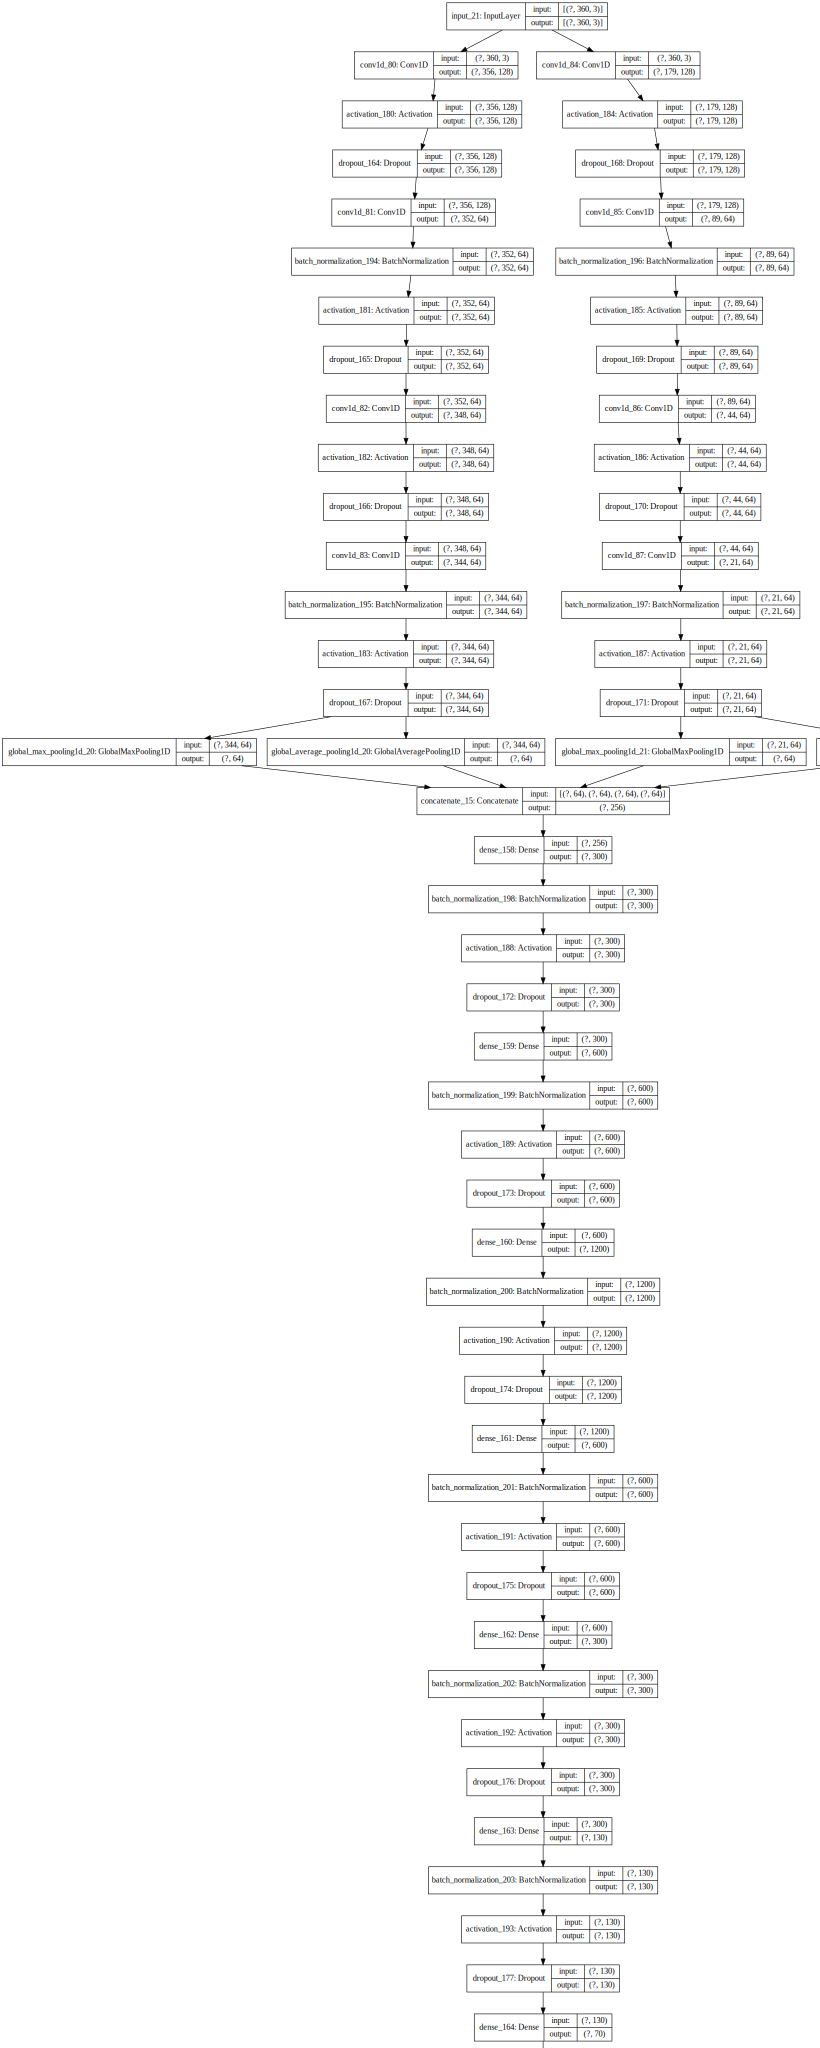

In [56]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [57]:
from datetime import datetime
import os

from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc


class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        chart = plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))
        plt.display(chart)
        plt.show()
        
       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        chart = fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))
        plt.display(chart)
        plt.show()
        
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=100) 
performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=v_dataset,
                      image_dir='performance_vizualizations')

callbacks_list = [checkpoint
#                   , early
                  , reduceLROnPlat
                  , tensorboard_callback
                  
                 ]


from IPython.display import clear_output
model.fit(train_dataset,
                      validation_data = v_dataset, 
#                       batch_size = 10,
                      epochs = 1000,
                      use_multiprocessing = True,
                      callbacks = callbacks_list)

# model.fit([train_X, train_X2], [train_y, train_y],
#                       validation_data = ([valid_X, valid_X2], [valid_y, valid_y]), 
#                       batch_size = batch_size,
#                       epochs = 500,
#                       callbacks = callbacks_list)

#clear_output()

W0613 11:29:24.824129 13976 callbacks.py:2207] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Epoch 1/1000
      2/Unknown - 0s 0s/step - loss: 1.3516 - accuracy: 0.32 - 3s 2s/step - loss: 1.2167 - accuracy: 0.3893

W0613 11:29:39.326326 13976 callbacks.py:307] Method (on_train_batch_end) is slow compared to the batch update (1.663653). Check your callbacks.


     19/Unknown - 3s 1s/step - loss: 1.1479 - accuracy: 0.44 - 4s 879ms/step - loss: 1.0862 - accuracy: 0.494 - 4s 715ms/step - loss: 1.0606 - accuracy: 0.517 - 4s 609ms/step - loss: 1.0318 - accuracy: 0.541 - 4s 471ms/step - loss: 1.0099 - accuracy: 0.561 - 4s 425ms/step - loss: 1.0081 - accuracy: 0.564 - 4s 389ms/step - loss: 1.0111 - accuracy: 0.560 - 4s 359ms/step - loss: 1.0039 - accuracy: 0.570 - 4s 335ms/step - loss: 0.9900 - accuracy: 0.584 - 4s 314ms/step - loss: 0.9675 - accuracy: 0.600 - 4s 296ms/step - loss: 0.9848 - accuracy: 0.592 - 4s 280ms/step - loss: 1.0161 - accuracy: 0.577 - 4s 267ms/step - loss: 1.0171 - accuracy: 0.577 - 4s 255ms/step - loss: 1.0196 - accuracy: 0.574 - 4s 244ms/step - loss: 1.0167 - accuracy: 0.575 - 4s 234ms/step - loss: 1.0162 - accuracy: 0.5749
Epoch 00001: val_loss improved from inf to 1.12381, saving model to stroke_lstm_model_weights.best.hdf5
19/19 [==============================] - 5s 269ms/step - loss: 1.0162 - accuracy: 0.5749 - val_loss

19/19 [==============================] - ETA: 0s - loss: 1.0223 - accuracy: 0.52 - ETA: 0s - loss: 1.0389 - accuracy: 0.51 - ETA: 0s - loss: 1.0327 - accuracy: 0.52 - ETA: 0s - loss: 1.0081 - accuracy: 0.55 - ETA: 0s - loss: 0.9948 - accuracy: 0.56 - ETA: 0s - loss: 0.9758 - accuracy: 0.58 - ETA: 0s - loss: 0.9705 - accuracy: 0.59 - ETA: 0s - loss: 0.9670 - accuracy: 0.59 - ETA: 0s - loss: 0.9675 - accuracy: 0.59 - ETA: 0s - loss: 0.9811 - accuracy: 0.58 - ETA: 0s - loss: 0.9685 - accuracy: 0.59 - ETA: 0s - loss: 0.9500 - accuracy: 0.60 - ETA: 0s - loss: 0.9283 - accuracy: 0.62 - ETA: 0s - loss: 0.9650 - accuracy: 0.59 - ETA: 0s - loss: 0.9657 - accuracy: 0.59 - ETA: 0s - loss: 0.9692 - accuracy: 0.59 - ETA: 0s - loss: 0.9697 - accuracy: 0.59 - ETA: 0s - loss: 0.9713 - accuracy: 0.5895
Epoch 00009: val_loss did not improve from 1.03954
19/19 [==============================] - 1s 70ms/step - loss: 0.9713 - accuracy: 0.5895 - val_loss: 1.0455 - val_accuracy: 0.5039 - lr: 0.0900
Epoch 10/

19/19 [==============================] - ETA: 0s - loss: 1.0116 - accuracy: 0.52 - ETA: 0s - loss: 1.0129 - accuracy: 0.51 - ETA: 0s - loss: 1.0068 - accuracy: 0.52 - ETA: 0s - loss: 0.9792 - accuracy: 0.55 - ETA: 0s - loss: 0.9695 - accuracy: 0.56 - ETA: 0s - loss: 0.9518 - accuracy: 0.57 - ETA: 0s - loss: 0.9500 - accuracy: 0.58 - ETA: 0s - loss: 0.9530 - accuracy: 0.58 - ETA: 0s - loss: 0.9534 - accuracy: 0.58 - ETA: 0s - loss: 0.9656 - accuracy: 0.58 - ETA: 0s - loss: 0.9541 - accuracy: 0.59 - ETA: 0s - loss: 0.9378 - accuracy: 0.60 - ETA: 0s - loss: 0.9177 - accuracy: 0.61 - ETA: 0s - loss: 0.9545 - accuracy: 0.59 - ETA: 0s - loss: 0.9560 - accuracy: 0.59 - ETA: 0s - loss: 0.9606 - accuracy: 0.58 - ETA: 0s - loss: 0.9613 - accuracy: 0.58 - ETA: 0s - loss: 0.9629 - accuracy: 0.5876
Epoch 00017: val_loss did not improve from 1.03161
19/19 [==============================] - 1s 70ms/step - loss: 0.9629 - accuracy: 0.5876 - val_loss: 1.0377 - val_accuracy: 0.5060 - lr: 0.0900
Epoch 18/

19/19 [==============================] - ETA: 0s - loss: 1.0149 - accuracy: 0.52 - ETA: 0s - loss: 1.0166 - accuracy: 0.51 - ETA: 0s - loss: 1.0109 - accuracy: 0.52 - ETA: 0s - loss: 0.9901 - accuracy: 0.55 - ETA: 0s - loss: 0.9776 - accuracy: 0.56 - ETA: 0s - loss: 0.9630 - accuracy: 0.57 - ETA: 0s - loss: 0.9587 - accuracy: 0.58 - ETA: 0s - loss: 0.9550 - accuracy: 0.59 - ETA: 0s - loss: 0.9550 - accuracy: 0.59 - ETA: 0s - loss: 0.9687 - accuracy: 0.58 - ETA: 0s - loss: 0.9568 - accuracy: 0.59 - ETA: 0s - loss: 0.9193 - accuracy: 0.61 - ETA: 0s - loss: 0.9340 - accuracy: 0.60 - ETA: 0s - loss: 0.9558 - accuracy: 0.59 - ETA: 0s - loss: 0.9565 - accuracy: 0.59 - ETA: 0s - loss: 0.9608 - accuracy: 0.58 - ETA: 0s - loss: 0.9615 - accuracy: 0.58 - ETA: 0s - loss: 0.9631 - accuracy: 0.5877
Epoch 00025: val_loss did not improve from 1.01682
19/19 [==============================] - 1s 70ms/step - loss: 0.9631 - accuracy: 0.5877 - val_loss: 1.0430 - val_accuracy: 0.4974 - lr: 0.0900
Epoch 26/

19/19 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.52 - ETA: 0s - loss: 1.0278 - accuracy: 0.52 - ETA: 0s - loss: 1.0011 - accuracy: 0.55 - ETA: 0s - loss: 0.9909 - accuracy: 0.56 - ETA: 0s - loss: 0.9719 - accuracy: 0.57 - ETA: 0s - loss: 0.9624 - accuracy: 0.58 - ETA: 0s - loss: 0.9616 - accuracy: 0.58 - ETA: 0s - loss: 0.9611 - accuracy: 0.58 - ETA: 0s - loss: 0.9747 - accuracy: 0.58 - ETA: 0s - loss: 0.9622 - accuracy: 0.59 - ETA: 0s - loss: 0.9439 - accuracy: 0.60 - ETA: 0s - loss: 0.9220 - accuracy: 0.61 - ETA: 0s - loss: 0.9385 - accuracy: 0.60 - ETA: 0s - loss: 0.9617 - accuracy: 0.59 - ETA: 0s - loss: 0.9628 - accuracy: 0.59 - ETA: 0s - loss: 0.9670 - accuracy: 0.58 - ETA: 0s - loss: 0.9679 - accuracy: 0.5874
Epoch 00033: val_loss did not improve from 1.01682
19/19 [==============================] - 1s 70ms/step - loss: 0.9679 - accuracy: 0.5874 - val_loss: 1.0292 - val_accuracy: 0.4971 - lr: 0.0720
Epoch 34/1000
19/19 [==============================

19/19 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.52 - ETA: 0s - loss: 1.0149 - accuracy: 0.51 - ETA: 0s - loss: 1.0124 - accuracy: 0.52 - ETA: 0s - loss: 0.9994 - accuracy: 0.55 - ETA: 0s - loss: 0.9922 - accuracy: 0.56 - ETA: 0s - loss: 0.9809 - accuracy: 0.58 - ETA: 0s - loss: 0.9761 - accuracy: 0.58 - ETA: 0s - loss: 0.9704 - accuracy: 0.59 - ETA: 0s - loss: 0.9665 - accuracy: 0.59 - ETA: 0s - loss: 0.9735 - accuracy: 0.58 - ETA: 0s - loss: 0.9613 - accuracy: 0.59 - ETA: 0s - loss: 0.9445 - accuracy: 0.60 - ETA: 0s - loss: 0.9233 - accuracy: 0.61 - ETA: 0s - loss: 0.9407 - accuracy: 0.61 - ETA: 0s - loss: 0.9666 - accuracy: 0.59 - ETA: 0s - loss: 0.9686 - accuracy: 0.59 - ETA: 0s - loss: 0.9727 - accuracy: 0.58 - ETA: 0s - loss: 0.9735 - accuracy: 0.5881
Epoch 00041: val_loss did not improve from 1.01682
19/19 [==============================] - 1s 70ms/step - loss: 0.9735 - accuracy: 0.5881 - val_loss: 1.0254 - val_accuracy: 0.4971 - lr: 0.0720
Epoch 42/

19/19 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.52 - ETA: 0s - loss: 1.0147 - accuracy: 0.51 - ETA: 0s - loss: 1.0069 - accuracy: 0.52 - ETA: 0s - loss: 0.9824 - accuracy: 0.55 - ETA: 0s - loss: 0.9746 - accuracy: 0.56 - ETA: 0s - loss: 0.9625 - accuracy: 0.58 - ETA: 0s - loss: 0.9580 - accuracy: 0.59 - ETA: 0s - loss: 0.9577 - accuracy: 0.59 - ETA: 0s - loss: 0.9548 - accuracy: 0.59 - ETA: 0s - loss: 0.9612 - accuracy: 0.58 - ETA: 0s - loss: 0.9530 - accuracy: 0.59 - ETA: 0s - loss: 0.9392 - accuracy: 0.60 - ETA: 0s - loss: 0.9348 - accuracy: 0.61 - ETA: 0s - loss: 0.9556 - accuracy: 0.59 - ETA: 0s - loss: 0.9574 - accuracy: 0.59 - ETA: 0s - loss: 0.9636 - accuracy: 0.59 - ETA: 0s - loss: 0.9635 - accuracy: 0.59 - ETA: 0s - loss: 0.9647 - accuracy: 0.5891
Epoch 00049: val_loss did not improve from 1.01404
19/19 [==============================] - 1s 71ms/step - loss: 0.9647 - accuracy: 0.5891 - val_loss: 1.0589 - val_accuracy: 0.4971 - lr: 0.0576
Epoch 50/

19/19 [==============================] - ETA: 0s - loss: 1.0067 - accuracy: 0.52 - ETA: 0s - loss: 1.0151 - accuracy: 0.51 - ETA: 0s - loss: 1.0050 - accuracy: 0.52 - ETA: 0s - loss: 0.9752 - accuracy: 0.55 - ETA: 0s - loss: 0.9643 - accuracy: 0.56 - ETA: 0s - loss: 0.9492 - accuracy: 0.58 - ETA: 0s - loss: 0.9447 - accuracy: 0.59 - ETA: 0s - loss: 0.9434 - accuracy: 0.59 - ETA: 0s - loss: 0.9407 - accuracy: 0.59 - ETA: 0s - loss: 0.9478 - accuracy: 0.58 - ETA: 0s - loss: 0.9400 - accuracy: 0.59 - ETA: 0s - loss: 0.9272 - accuracy: 0.60 - ETA: 0s - loss: 0.9103 - accuracy: 0.62 - ETA: 0s - loss: 0.9233 - accuracy: 0.61 - ETA: 0s - loss: 0.9427 - accuracy: 0.59 - ETA: 0s - loss: 0.9444 - accuracy: 0.59 - ETA: 0s - loss: 0.9506 - accuracy: 0.59 - ETA: 0s - loss: 0.9513 - accuracy: 0.5895
Epoch 00057: val_loss did not improve from 1.01161
19/19 [==============================] - 1s 70ms/step - loss: 0.9513 - accuracy: 0.5895 - val_loss: 1.0193 - val_accuracy: 0.4971 - lr: 0.0576
Epoch 58/

19/19 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.52 - ETA: 0s - loss: 1.0150 - accuracy: 0.51 - ETA: 0s - loss: 1.0049 - accuracy: 0.52 - ETA: 0s - loss: 0.9751 - accuracy: 0.55 - ETA: 0s - loss: 0.9648 - accuracy: 0.56 - ETA: 0s - loss: 0.9494 - accuracy: 0.58 - ETA: 0s - loss: 0.9437 - accuracy: 0.59 - ETA: 0s - loss: 0.9422 - accuracy: 0.59 - ETA: 0s - loss: 0.9400 - accuracy: 0.59 - ETA: 0s - loss: 0.9473 - accuracy: 0.58 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9101 - accuracy: 0.62 - ETA: 0s - loss: 0.9228 - accuracy: 0.61 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9434 - accuracy: 0.59 - ETA: 0s - loss: 0.9488 - accuracy: 0.59 - ETA: 0s - loss: 0.9493 - accuracy: 0.59 - ETA: 0s - loss: 0.9504 - accuracy: 0.5894
Epoch 00065: val_loss did not improve from 1.01161
19/19 [==============================] - 1s 70ms/step - loss: 0.9504 - accuracy: 0.5894 - val_loss: 1.0137 - val_accuracy: 0.4971 - lr: 0.0461
Epoch 66/

19/19 [==============================] - 1s 74ms/step - loss: 0.9472 - accuracy: 0.5895 - val_loss: 1.0059 - val_accuracy: 0.4971 - lr: 0.0461
Epoch 73/1000
19/19 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.52 - ETA: 0s - loss: 1.0066 - accuracy: 0.51 - ETA: 0s - loss: 0.9978 - accuracy: 0.52 - ETA: 0s - loss: 0.9676 - accuracy: 0.55 - ETA: 0s - loss: 0.9567 - accuracy: 0.56 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9352 - accuracy: 0.59 - ETA: 0s - loss: 0.9434 - accuracy: 0.58 - ETA: 0s - loss: 0.9357 - accuracy: 0.59 - ETA: 0s - loss: 0.9229 - accuracy: 0.60 - ETA: 0s - loss: 0.9059 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9377 - accuracy: 0.59 - ETA: 0s - loss: 0.9397 - accuracy: 0.59 - ETA: 0s - loss: 0.9453 - accuracy: 0.59 - ETA: 0s - loss: 0.9458 - accuracy: 0.59 - ETA: 0s - loss: 0.9470 - accuracy: 0.5897
Epoc

19/19 [==============================] - 1s 74ms/step - loss: 0.9472 - accuracy: 0.5896 - val_loss: 0.9997 - val_accuracy: 0.4971 - lr: 0.0461
Epoch 81/1000
19/19 [==============================] - ETA: 0s - loss: 1.0015 - accuracy: 0.52 - ETA: 0s - loss: 1.0043 - accuracy: 0.51 - ETA: 0s - loss: 0.9947 - accuracy: 0.52 - ETA: 0s - loss: 0.9657 - accuracy: 0.55 - ETA: 0s - loss: 0.9549 - accuracy: 0.56 - ETA: 0s - loss: 0.9409 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9345 - accuracy: 0.59 - ETA: 0s - loss: 0.9424 - accuracy: 0.58 - ETA: 0s - loss: 0.9351 - accuracy: 0.59 - ETA: 0s - loss: 0.9226 - accuracy: 0.60 - ETA: 0s - loss: 0.9058 - accuracy: 0.62 - ETA: 0s - loss: 0.9392 - accuracy: 0.59 - ETA: 0s - loss: 0.9409 - accuracy: 0.59 - ETA: 0s - loss: 0.9464 - accuracy: 0.59 - ETA: 0s - loss: 0.9466 - accuracy: 0.59 - ETA: 0s - loss: 0.9478 - accuracy: 0.5891
Epoch 00081: val_loss did not improve from 0.9

Epoch 89/1000
19/19 [==============================] - ETA: 0s - loss: 1.0040 - accuracy: 0.52 - ETA: 0s - loss: 1.0049 - accuracy: 0.51 - ETA: 0s - loss: 0.9958 - accuracy: 0.52 - ETA: 0s - loss: 0.9661 - accuracy: 0.55 - ETA: 0s - loss: 0.9564 - accuracy: 0.56 - ETA: 0s - loss: 0.9420 - accuracy: 0.58 - ETA: 0s - loss: 0.9386 - accuracy: 0.59 - ETA: 0s - loss: 0.9374 - accuracy: 0.59 - ETA: 0s - loss: 0.9352 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9353 - accuracy: 0.59 - ETA: 0s - loss: 0.9229 - accuracy: 0.60 - ETA: 0s - loss: 0.9058 - accuracy: 0.62 - ETA: 0s - loss: 0.9184 - accuracy: 0.61 - ETA: 0s - loss: 0.9374 - accuracy: 0.59 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9449 - accuracy: 0.59 - ETA: 0s - loss: 0.9450 - accuracy: 0.59 - ETA: 0s - loss: 0.9463 - accuracy: 0.5894
Epoch 00089: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 70ms/step - loss: 0.9463 - accuracy: 0.5894 - val_lo

19/19 [==============================] - ETA: 0s - loss: 1.0040 - accuracy: 0.52 - ETA: 0s - loss: 1.0037 - accuracy: 0.51 - ETA: 0s - loss: 0.9953 - accuracy: 0.52 - ETA: 0s - loss: 0.9656 - accuracy: 0.55 - ETA: 0s - loss: 0.9551 - accuracy: 0.56 - ETA: 0s - loss: 0.9395 - accuracy: 0.58 - ETA: 0s - loss: 0.9350 - accuracy: 0.59 - ETA: 0s - loss: 0.9338 - accuracy: 0.59 - ETA: 0s - loss: 0.9317 - accuracy: 0.59 - ETA: 0s - loss: 0.9398 - accuracy: 0.58 - ETA: 0s - loss: 0.9325 - accuracy: 0.59 - ETA: 0s - loss: 0.9200 - accuracy: 0.60 - ETA: 0s - loss: 0.9029 - accuracy: 0.62 - ETA: 0s - loss: 0.9349 - accuracy: 0.59 - ETA: 0s - loss: 0.9372 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9428 - accuracy: 0.59 - ETA: 0s - loss: 0.9445 - accuracy: 0.5899
Epoch 00097: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 70ms/step - loss: 0.9445 - accuracy: 0.5899 - val_loss: 1.0174 - val_accuracy: 0.4972 - lr: 0.0369
Epoch 98/

19/19 [==============================] - ETA: 0s - loss: 1.0021 - accuracy: 0.52 - ETA: 0s - loss: 1.0049 - accuracy: 0.51 - ETA: 0s - loss: 0.9955 - accuracy: 0.52 - ETA: 0s - loss: 0.9649 - accuracy: 0.55 - ETA: 0s - loss: 0.9539 - accuracy: 0.56 - ETA: 0s - loss: 0.9383 - accuracy: 0.58 - ETA: 0s - loss: 0.9341 - accuracy: 0.59 - ETA: 0s - loss: 0.9329 - accuracy: 0.59 - ETA: 0s - loss: 0.9309 - accuracy: 0.59 - ETA: 0s - loss: 0.9392 - accuracy: 0.58 - ETA: 0s - loss: 0.9322 - accuracy: 0.59 - ETA: 0s - loss: 0.9199 - accuracy: 0.60 - ETA: 0s - loss: 0.9027 - accuracy: 0.62 - ETA: 0s - loss: 0.9327 - accuracy: 0.59 - ETA: 0s - loss: 0.9350 - accuracy: 0.59 - ETA: 0s - loss: 0.9404 - accuracy: 0.59 - ETA: 0s - loss: 0.9410 - accuracy: 0.59 - ETA: 0s - loss: 0.9423 - accuracy: 0.5904
Epoch 00105: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 70ms/step - loss: 0.9423 - accuracy: 0.5904 - val_loss: 1.0116 - val_accuracy: 0.4972 - lr: 0.0295
Epoch 106

19/19 [==============================] - ETA: 0s - loss: 0.9987 - accuracy: 0.52 - ETA: 0s - loss: 1.0002 - accuracy: 0.51 - ETA: 0s - loss: 0.9613 - accuracy: 0.55 - ETA: 0s - loss: 0.9515 - accuracy: 0.56 - ETA: 0s - loss: 0.9367 - accuracy: 0.58 - ETA: 0s - loss: 0.9331 - accuracy: 0.58 - ETA: 0s - loss: 0.9320 - accuracy: 0.59 - ETA: 0s - loss: 0.9302 - accuracy: 0.59 - ETA: 0s - loss: 0.9383 - accuracy: 0.58 - ETA: 0s - loss: 0.9309 - accuracy: 0.59 - ETA: 0s - loss: 0.9188 - accuracy: 0.60 - ETA: 0s - loss: 0.9021 - accuracy: 0.62 - ETA: 0s - loss: 0.9145 - accuracy: 0.61 - ETA: 0s - loss: 0.9327 - accuracy: 0.59 - ETA: 0s - loss: 0.9351 - accuracy: 0.59 - ETA: 0s - loss: 0.9405 - accuracy: 0.59 - ETA: 0s - loss: 0.9409 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0.5902
Epoch 00113: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 70ms/step - loss: 0.9427 - accuracy: 0.5902 - val_loss: 1.0218 - val_accuracy: 0.4979 - lr: 0.0295
Epoch 114

Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 1.0012 - accuracy: 0.52 - ETA: 0s - loss: 1.0033 - accuracy: 0.51 - ETA: 0s - loss: 0.9947 - accuracy: 0.53 - ETA: 0s - loss: 0.9633 - accuracy: 0.56 - ETA: 0s - loss: 0.9515 - accuracy: 0.57 - ETA: 0s - loss: 0.9366 - accuracy: 0.58 - ETA: 0s - loss: 0.9329 - accuracy: 0.59 - ETA: 0s - loss: 0.9315 - accuracy: 0.59 - ETA: 0s - loss: 0.9293 - accuracy: 0.59 - ETA: 0s - loss: 0.9372 - accuracy: 0.58 - ETA: 0s - loss: 0.9300 - accuracy: 0.59 - ETA: 0s - loss: 0.9178 - accuracy: 0.60 - ETA: 0s - loss: 0.9010 - accuracy: 0.62 - ETA: 0s - loss: 0.9132 - accuracy: 0.61 - ETA: 0s - loss: 0.9317 - accuracy: 0.59 - ETA: 0s - loss: 0.9341 - accuracy: 0.59 - ETA: 0s - loss: 0.9391 - accuracy: 0.59 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9409 - accuracy: 0.5902
Epoch 00121: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 71ms/step - loss: 0.9409 - accuracy: 0.5902 - val_l

19/19 [==============================] - ETA: 0s - loss: 0.9987 - accuracy: 0.53 - ETA: 0s - loss: 0.9993 - accuracy: 0.52 - ETA: 0s - loss: 0.9900 - accuracy: 0.53 - ETA: 0s - loss: 0.9601 - accuracy: 0.56 - ETA: 0s - loss: 0.9495 - accuracy: 0.57 - ETA: 0s - loss: 0.9343 - accuracy: 0.58 - ETA: 0s - loss: 0.9293 - accuracy: 0.59 - ETA: 0s - loss: 0.9279 - accuracy: 0.59 - ETA: 0s - loss: 0.9261 - accuracy: 0.59 - ETA: 0s - loss: 0.9351 - accuracy: 0.58 - ETA: 0s - loss: 0.9279 - accuracy: 0.59 - ETA: 0s - loss: 0.9158 - accuracy: 0.60 - ETA: 0s - loss: 0.8987 - accuracy: 0.62 - ETA: 0s - loss: 0.9113 - accuracy: 0.61 - ETA: 0s - loss: 0.9299 - accuracy: 0.59 - ETA: 0s - loss: 0.9325 - accuracy: 0.59 - ETA: 0s - loss: 0.9377 - accuracy: 0.59 - ETA: 0s - loss: 0.9384 - accuracy: 0.59 - ETA: 0s - loss: 0.9399 - accuracy: 0.5920
Epoch 00129: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 70ms/step - loss: 0.9399 - accuracy: 0.5920 - val_loss: 1.0109 - v

Epoch 137/1000
19/19 [==============================] - ETA: 0s - loss: 0.9988 - accuracy: 0.53 - ETA: 0s - loss: 0.9981 - accuracy: 0.52 - ETA: 0s - loss: 0.9874 - accuracy: 0.53 - ETA: 0s - loss: 0.9571 - accuracy: 0.56 - ETA: 0s - loss: 0.9473 - accuracy: 0.57 - ETA: 0s - loss: 0.9316 - accuracy: 0.58 - ETA: 0s - loss: 0.9282 - accuracy: 0.59 - ETA: 0s - loss: 0.9263 - accuracy: 0.59 - ETA: 0s - loss: 0.9243 - accuracy: 0.59 - ETA: 0s - loss: 0.9328 - accuracy: 0.58 - ETA: 0s - loss: 0.9255 - accuracy: 0.59 - ETA: 0s - loss: 0.9138 - accuracy: 0.60 - ETA: 0s - loss: 0.8964 - accuracy: 0.62 - ETA: 0s - loss: 0.9088 - accuracy: 0.61 - ETA: 0s - loss: 0.9296 - accuracy: 0.59 - ETA: 0s - loss: 0.9349 - accuracy: 0.59 - ETA: 0s - loss: 0.9358 - accuracy: 0.59 - ETA: 0s - loss: 0.9376 - accuracy: 0.5918
Epoch 00137: val_loss did not improve from 0.99970
19/19 [==============================] - 1s 71ms/step - loss: 0.9376 - accuracy: 0.5918 - val_loss: 1.0011 - val_accuracy: 0.5042 - lr: 0

Epoch 145/1000
19/19 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.53 - ETA: 0s - loss: 1.0018 - accuracy: 0.53 - ETA: 0s - loss: 0.9911 - accuracy: 0.54 - ETA: 0s - loss: 0.9602 - accuracy: 0.56 - ETA: 0s - loss: 0.9493 - accuracy: 0.57 - ETA: 0s - loss: 0.9323 - accuracy: 0.59 - ETA: 0s - loss: 0.9269 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9227 - accuracy: 0.59 - ETA: 0s - loss: 0.9319 - accuracy: 0.59 - ETA: 0s - loss: 0.9247 - accuracy: 0.60 - ETA: 0s - loss: 0.9134 - accuracy: 0.61 - ETA: 0s - loss: 0.8964 - accuracy: 0.62 - ETA: 0s - loss: 0.9087 - accuracy: 0.61 - ETA: 0s - loss: 0.9268 - accuracy: 0.59 - ETA: 0s - loss: 0.9346 - accuracy: 0.59 - ETA: 0s - loss: 0.9351 - accuracy: 0.59 - ETA: 0s - loss: 0.9363 - accuracy: 0.5932
Epoch 00145: val_loss did not improve from 0.99394
19/19 [==============================] - 1s 71ms/step - loss: 0.9363 - accuracy: 0.5932 - val_loss: 1.0223 - val_accuracy: 0.4995 - lr: 0

Epoch 153/1000
19/19 [==============================] - ETA: 0s - loss: 0.9990 - accuracy: 0.53 - ETA: 0s - loss: 0.9964 - accuracy: 0.52 - ETA: 0s - loss: 0.9866 - accuracy: 0.53 - ETA: 0s - loss: 0.9565 - accuracy: 0.56 - ETA: 0s - loss: 0.9444 - accuracy: 0.57 - ETA: 0s - loss: 0.9289 - accuracy: 0.59 - ETA: 0s - loss: 0.9247 - accuracy: 0.59 - ETA: 0s - loss: 0.9221 - accuracy: 0.60 - ETA: 0s - loss: 0.9209 - accuracy: 0.59 - ETA: 0s - loss: 0.9307 - accuracy: 0.59 - ETA: 0s - loss: 0.9232 - accuracy: 0.59 - ETA: 0s - loss: 0.9113 - accuracy: 0.60 - ETA: 0s - loss: 0.8944 - accuracy: 0.62 - ETA: 0s - loss: 0.9073 - accuracy: 0.61 - ETA: 0s - loss: 0.9278 - accuracy: 0.59 - ETA: 0s - loss: 0.9333 - accuracy: 0.59 - ETA: 0s - loss: 0.9340 - accuracy: 0.59 - ETA: 0s - loss: 0.9353 - accuracy: 0.5909
Epoch 00153: val_loss did not improve from 0.99394
19/19 [==============================] - 1s 70ms/step - loss: 0.9353 - accuracy: 0.5909 - val_loss: 1.0087 - val_accuracy: 0.5077 - lr: 0

Epoch 161/1000
19/19 [==============================] - ETA: 0s - loss: 0.9992 - accuracy: 0.53 - ETA: 0s - loss: 0.9960 - accuracy: 0.53 - ETA: 0s - loss: 0.9859 - accuracy: 0.54 - ETA: 0s - loss: 0.9555 - accuracy: 0.56 - ETA: 0s - loss: 0.9435 - accuracy: 0.57 - ETA: 0s - loss: 0.9274 - accuracy: 0.59 - ETA: 0s - loss: 0.9234 - accuracy: 0.59 - ETA: 0s - loss: 0.9206 - accuracy: 0.60 - ETA: 0s - loss: 0.9186 - accuracy: 0.60 - ETA: 0s - loss: 0.9278 - accuracy: 0.59 - ETA: 0s - loss: 0.9214 - accuracy: 0.60 - ETA: 0s - loss: 0.9101 - accuracy: 0.61 - ETA: 0s - loss: 0.8934 - accuracy: 0.62 - ETA: 0s - loss: 0.9064 - accuracy: 0.61 - ETA: 0s - loss: 0.9246 - accuracy: 0.60 - ETA: 0s - loss: 0.9264 - accuracy: 0.59 - ETA: 0s - loss: 0.9318 - accuracy: 0.59 - ETA: 0s - loss: 0.9338 - accuracy: 0.5929
Epoch 00161: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.9338 - accuracy: 0.5929 - val_loss: 1.0177 - val_accuracy: 0.5049 - lr: 0

Epoch 169/1000
19/19 [==============================] - ETA: 0s - loss: 1.0022 - accuracy: 0.53 - ETA: 0s - loss: 0.9907 - accuracy: 0.53 - ETA: 0s - loss: 0.9805 - accuracy: 0.54 - ETA: 0s - loss: 0.9514 - accuracy: 0.57 - ETA: 0s - loss: 0.9399 - accuracy: 0.58 - ETA: 0s - loss: 0.9245 - accuracy: 0.59 - ETA: 0s - loss: 0.9203 - accuracy: 0.60 - ETA: 0s - loss: 0.9173 - accuracy: 0.60 - ETA: 0s - loss: 0.9158 - accuracy: 0.60 - ETA: 0s - loss: 0.9257 - accuracy: 0.59 - ETA: 0s - loss: 0.9196 - accuracy: 0.60 - ETA: 0s - loss: 0.9079 - accuracy: 0.61 - ETA: 0s - loss: 0.9039 - accuracy: 0.61 - ETA: 0s - loss: 0.9222 - accuracy: 0.60 - ETA: 0s - loss: 0.9241 - accuracy: 0.60 - ETA: 0s - loss: 0.9294 - accuracy: 0.59 - ETA: 0s - loss: 0.9303 - accuracy: 0.59 - ETA: 0s - loss: 0.9313 - accuracy: 0.5969
Epoch 00169: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9313 - accuracy: 0.5969 - val_loss: 1.0057 - val_accuracy: 0.5075 - lr: 0

19/19 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.54 - ETA: 0s - loss: 0.9889 - accuracy: 0.54 - ETA: 0s - loss: 0.9797 - accuracy: 0.55 - ETA: 0s - loss: 0.9502 - accuracy: 0.57 - ETA: 0s - loss: 0.9383 - accuracy: 0.58 - ETA: 0s - loss: 0.9226 - accuracy: 0.60 - ETA: 0s - loss: 0.9191 - accuracy: 0.60 - ETA: 0s - loss: 0.9166 - accuracy: 0.61 - ETA: 0s - loss: 0.9149 - accuracy: 0.60 - ETA: 0s - loss: 0.9250 - accuracy: 0.59 - ETA: 0s - loss: 0.9187 - accuracy: 0.60 - ETA: 0s - loss: 0.9074 - accuracy: 0.61 - ETA: 0s - loss: 0.8910 - accuracy: 0.62 - ETA: 0s - loss: 0.9036 - accuracy: 0.61 - ETA: 0s - loss: 0.9219 - accuracy: 0.60 - ETA: 0s - loss: 0.9244 - accuracy: 0.60 - ETA: 0s - loss: 0.9295 - accuracy: 0.59 - ETA: 0s - loss: 0.9305 - accuracy: 0.59 - ETA: 0s - loss: 0.9316 - accuracy: 0.5954
Epoch 00177: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9316 - accuracy: 0.5954 - val_loss: 1.0114 - v

Epoch 185/1000
18/19 [===========================>..] - ETA: 0s - loss: 0.9978 - accuracy: 0.53 - ETA: 0s - loss: 0.9853 - accuracy: 0.54 - ETA: 0s - loss: 0.9790 - accuracy: 0.54 - ETA: 0s - loss: 0.9474 - accuracy: 0.57 - ETA: 0s - loss: 0.9344 - accuracy: 0.58 - ETA: 0s - loss: 0.9208 - accuracy: 0.60 - ETA: 0s - loss: 0.9161 - accuracy: 0.60 - ETA: 0s - loss: 0.9143 - accuracy: 0.60 - ETA: 0s - loss: 0.9134 - accuracy: 0.60 - ETA: 0s - loss: 0.9232 - accuracy: 0.59 - ETA: 0s - loss: 0.9159 - accuracy: 0.60 - ETA: 0s - loss: 0.9054 - accuracy: 0.61 - ETA: 0s - loss: 0.8887 - accuracy: 0.63 - ETA: 0s - loss: 0.9010 - accuracy: 0.62 - ETA: 0s - loss: 0.9198 - accuracy: 0.60 - ETA: 0s - loss: 0.9216 - accuracy: 0.60 - ETA: 0s - loss: 0.9271 - accuracy: 0.59 - ETA: 0s - loss: 0.9283 - accuracy: 0.5980
Epoch 00185: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9296 - accuracy: 0.5968 - val_loss: 1.0195 - val_accuracy: 0.5039 - lr: 0

Epoch 00192: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9287 - accuracy: 0.5979 - val_loss: 1.0158 - val_accuracy: 0.5039 - lr: 0.0097
Epoch 193/1000
19/19 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.53 - ETA: 0s - loss: 0.9873 - accuracy: 0.53 - ETA: 0s - loss: 0.9801 - accuracy: 0.54 - ETA: 0s - loss: 0.9501 - accuracy: 0.57 - ETA: 0s - loss: 0.9376 - accuracy: 0.58 - ETA: 0s - loss: 0.9222 - accuracy: 0.59 - ETA: 0s - loss: 0.9166 - accuracy: 0.60 - ETA: 0s - loss: 0.9142 - accuracy: 0.60 - ETA: 0s - loss: 0.9130 - accuracy: 0.60 - ETA: 0s - loss: 0.9221 - accuracy: 0.59 - ETA: 0s - loss: 0.9155 - accuracy: 0.60 - ETA: 0s - loss: 0.9041 - accuracy: 0.61 - ETA: 0s - loss: 0.8879 - accuracy: 0.62 - ETA: 0s - loss: 0.9001 - accuracy: 0.61 - ETA: 0s - loss: 0.9189 - accuracy: 0.60 - ETA: 0s - loss: 0.9201 - accuracy: 0.60 - ETA: 0s - loss: 0.9253 - accuracy: 0.59 - ETA: 0s - loss: 0.9263 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.54 - ETA: 0s - loss: 0.9840 - accuracy: 0.54 - ETA: 0s - loss: 0.9791 - accuracy: 0.55 - ETA: 0s - loss: 0.9447 - accuracy: 0.57 - ETA: 0s - loss: 0.9330 - accuracy: 0.58 - ETA: 0s - loss: 0.9183 - accuracy: 0.60 - ETA: 0s - loss: 0.9141 - accuracy: 0.60 - ETA: 0s - loss: 0.9109 - accuracy: 0.61 - ETA: 0s - loss: 0.9095 - accuracy: 0.61 - ETA: 0s - loss: 0.9176 - accuracy: 0.60 - ETA: 0s - loss: 0.9111 - accuracy: 0.61 - ETA: 0s - loss: 0.9009 - accuracy: 0.61 - ETA: 0s - loss: 0.8840 - accuracy: 0.63 - ETA: 0s - loss: 0.8964 - accuracy: 0.62 - ETA: 0s - loss: 0.9141 - accuracy: 0.61 - ETA: 0s - loss: 0.9158 - accuracy: 0.60 - ETA: 0s - loss: 0.9212 - accuracy: 0.60 - ETA: 0s - loss: 0.9221 - accuracy: 0.60 - ETA: 0s - loss: 0.9234 - accuracy: 0.6023
Epoch 00200: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9234 - accuracy: 0.6023 - val_loss: 1.0290 - v

Epoch 00207: val_loss did not improve from 0.99131

Epoch 00207: ReduceLROnPlateau reducing learning rate to 0.00618475265800953.
19/19 [==============================] - 1s 71ms/step - loss: 0.9232 - accuracy: 0.6001 - val_loss: 1.0306 - val_accuracy: 0.4940 - lr: 0.0077
Epoch 208/1000
19/19 [==============================] - ETA: 0s - loss: 0.9929 - accuracy: 0.54 - ETA: 0s - loss: 0.9766 - accuracy: 0.55 - ETA: 0s - loss: 0.9735 - accuracy: 0.55 - ETA: 0s - loss: 0.9418 - accuracy: 0.58 - ETA: 0s - loss: 0.9298 - accuracy: 0.59 - ETA: 0s - loss: 0.9151 - accuracy: 0.60 - ETA: 0s - loss: 0.9099 - accuracy: 0.61 - ETA: 0s - loss: 0.9074 - accuracy: 0.61 - ETA: 0s - loss: 0.9070 - accuracy: 0.61 - ETA: 0s - loss: 0.9166 - accuracy: 0.60 - ETA: 0s - loss: 0.9097 - accuracy: 0.61 - ETA: 0s - loss: 0.9002 - accuracy: 0.61 - ETA: 0s - loss: 0.8840 - accuracy: 0.63 - ETA: 0s - loss: 0.8962 - accuracy: 0.62 - ETA: 0s - loss: 0.9150 - accuracy: 0.60 - ETA: 0s - loss: 0.9161 - accuracy: 0.60 -

19/19 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.54 - ETA: 0s - loss: 0.9752 - accuracy: 0.54 - ETA: 0s - loss: 0.9699 - accuracy: 0.55 - ETA: 0s - loss: 0.9366 - accuracy: 0.58 - ETA: 0s - loss: 0.9263 - accuracy: 0.59 - ETA: 0s - loss: 0.9128 - accuracy: 0.60 - ETA: 0s - loss: 0.9069 - accuracy: 0.61 - ETA: 0s - loss: 0.9042 - accuracy: 0.61 - ETA: 0s - loss: 0.9039 - accuracy: 0.61 - ETA: 0s - loss: 0.9126 - accuracy: 0.60 - ETA: 0s - loss: 0.9057 - accuracy: 0.61 - ETA: 0s - loss: 0.8970 - accuracy: 0.62 - ETA: 0s - loss: 0.8810 - accuracy: 0.63 - ETA: 0s - loss: 0.8932 - accuracy: 0.62 - ETA: 0s - loss: 0.9121 - accuracy: 0.61 - ETA: 0s - loss: 0.9138 - accuracy: 0.61 - ETA: 0s - loss: 0.9189 - accuracy: 0.60 - ETA: 0s - loss: 0.9202 - accuracy: 0.60 - ETA: 0s - loss: 0.9219 - accuracy: 0.6019
Epoch 00215: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9219 - accuracy: 0.6019 - val_loss: 1.0394 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.9184 - accuracy: 0.6018 - val_loss: 1.0452 - val_accuracy: 0.4953 - lr: 0.0049
Epoch 223/1000
19/19 [==============================] - ETA: 0s - loss: 0.9960 - accuracy: 0.54 - ETA: 0s - loss: 0.9785 - accuracy: 0.55 - ETA: 0s - loss: 0.9712 - accuracy: 0.56 - ETA: 0s - loss: 0.9384 - accuracy: 0.58 - ETA: 0s - loss: 0.9272 - accuracy: 0.59 - ETA: 0s - loss: 0.9133 - accuracy: 0.60 - ETA: 0s - loss: 0.9076 - accuracy: 0.61 - ETA: 0s - loss: 0.9059 - accuracy: 0.61 - ETA: 0s - loss: 0.9045 - accuracy: 0.61 - ETA: 0s - loss: 0.9128 - accuracy: 0.60 - ETA: 0s - loss: 0.9061 - accuracy: 0.61 - ETA: 0s - loss: 0.8973 - accuracy: 0.62 - ETA: 0s - loss: 0.8807 - accuracy: 0.63 - ETA: 0s - loss: 0.8936 - accuracy: 0.62 - ETA: 0s - loss: 0.9127 - accuracy: 0.61 - ETA: 0s - loss: 0.9143 - accuracy: 0.60 - ETA: 0s - loss: 0.9193 - accuracy: 0.60 - ETA: 0s - loss: 0.9203 - accuracy: 0.60 - ETA: 0s - loss: 0.9217 - accuracy: 0.6016
Epo

19/19 [==============================] - ETA: 0s - loss: 0.9948 - accuracy: 0.54 - ETA: 0s - loss: 0.9733 - accuracy: 0.55 - ETA: 0s - loss: 0.9699 - accuracy: 0.55 - ETA: 0s - loss: 0.9334 - accuracy: 0.58 - ETA: 0s - loss: 0.9211 - accuracy: 0.59 - ETA: 0s - loss: 0.9067 - accuracy: 0.61 - ETA: 0s - loss: 0.9017 - accuracy: 0.61 - ETA: 0s - loss: 0.8993 - accuracy: 0.61 - ETA: 0s - loss: 0.8994 - accuracy: 0.61 - ETA: 0s - loss: 0.9087 - accuracy: 0.60 - ETA: 0s - loss: 0.9023 - accuracy: 0.61 - ETA: 0s - loss: 0.8945 - accuracy: 0.62 - ETA: 0s - loss: 0.8781 - accuracy: 0.63 - ETA: 0s - loss: 0.8896 - accuracy: 0.62 - ETA: 0s - loss: 0.9081 - accuracy: 0.61 - ETA: 0s - loss: 0.9097 - accuracy: 0.61 - ETA: 0s - loss: 0.9150 - accuracy: 0.60 - ETA: 0s - loss: 0.9158 - accuracy: 0.60 - ETA: 0s - loss: 0.9173 - accuracy: 0.6040
Epoch 00230: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9173 - accuracy: 0.6040 - val_loss: 1.0583 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.9166 - accuracy: 0.6033 - val_loss: 1.0686 - val_accuracy: 0.4914 - lr: 0.0040
Epoch 238/1000
19/19 [==============================] - ETA: 0s - loss: 0.9937 - accuracy: 0.53 - ETA: 0s - loss: 0.9677 - accuracy: 0.55 - ETA: 0s - loss: 0.9653 - accuracy: 0.55 - ETA: 0s - loss: 0.9305 - accuracy: 0.58 - ETA: 0s - loss: 0.9196 - accuracy: 0.59 - ETA: 0s - loss: 0.9047 - accuracy: 0.60 - ETA: 0s - loss: 0.8991 - accuracy: 0.61 - ETA: 0s - loss: 0.8968 - accuracy: 0.61 - ETA: 0s - loss: 0.8967 - accuracy: 0.61 - ETA: 0s - loss: 0.9049 - accuracy: 0.60 - ETA: 0s - loss: 0.8998 - accuracy: 0.61 - ETA: 0s - loss: 0.8913 - accuracy: 0.62 - ETA: 0s - loss: 0.8749 - accuracy: 0.63 - ETA: 0s - loss: 0.8860 - accuracy: 0.62 - ETA: 0s - loss: 0.9049 - accuracy: 0.61 - ETA: 0s - loss: 0.9067 - accuracy: 0.61 - ETA: 0s - loss: 0.9116 - accuracy: 0.60 - ETA: 0s - loss: 0.9133 - accuracy: 0.60 - ETA: 0s - loss: 0.9153 - accuracy: 0.6032
Epo

19/19 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.53 - ETA: 0s - loss: 0.9712 - accuracy: 0.55 - ETA: 0s - loss: 0.9666 - accuracy: 0.55 - ETA: 0s - loss: 0.9330 - accuracy: 0.58 - ETA: 0s - loss: 0.9215 - accuracy: 0.59 - ETA: 0s - loss: 0.9072 - accuracy: 0.60 - ETA: 0s - loss: 0.9024 - accuracy: 0.61 - ETA: 0s - loss: 0.9012 - accuracy: 0.61 - ETA: 0s - loss: 0.9007 - accuracy: 0.61 - ETA: 0s - loss: 0.9071 - accuracy: 0.60 - ETA: 0s - loss: 0.9002 - accuracy: 0.61 - ETA: 0s - loss: 0.8923 - accuracy: 0.62 - ETA: 0s - loss: 0.8763 - accuracy: 0.63 - ETA: 0s - loss: 0.8883 - accuracy: 0.62 - ETA: 0s - loss: 0.9073 - accuracy: 0.60 - ETA: 0s - loss: 0.9090 - accuracy: 0.60 - ETA: 0s - loss: 0.9139 - accuracy: 0.60 - ETA: 0s - loss: 0.9149 - accuracy: 0.60 - ETA: 0s - loss: 0.9164 - accuracy: 0.6015
Epoch 00245: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9164 - accuracy: 0.6015 - val_loss: 1.0686 - v

Epoch 00252: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9145 - accuracy: 0.6016 - val_loss: 1.0754 - val_accuracy: 0.4870 - lr: 0.0032
Epoch 253/1000
19/19 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.54 - ETA: 0s - loss: 0.9663 - accuracy: 0.55 - ETA: 0s - loss: 0.9635 - accuracy: 0.55 - ETA: 0s - loss: 0.9301 - accuracy: 0.58 - ETA: 0s - loss: 0.9185 - accuracy: 0.59 - ETA: 0s - loss: 0.9047 - accuracy: 0.61 - ETA: 0s - loss: 0.8997 - accuracy: 0.61 - ETA: 0s - loss: 0.8984 - accuracy: 0.61 - ETA: 0s - loss: 0.8986 - accuracy: 0.61 - ETA: 0s - loss: 0.9052 - accuracy: 0.60 - ETA: 0s - loss: 0.8985 - accuracy: 0.61 - ETA: 0s - loss: 0.8896 - accuracy: 0.62 - ETA: 0s - loss: 0.8737 - accuracy: 0.63 - ETA: 0s - loss: 0.8858 - accuracy: 0.62 - ETA: 0s - loss: 0.9046 - accuracy: 0.61 - ETA: 0s - loss: 0.9063 - accuracy: 0.61 - ETA: 0s - loss: 0.9114 - accuracy: 0.60 - ETA: 0s - loss: 0.9122 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9931 - accuracy: 0.54 - ETA: 0s - loss: 0.9613 - accuracy: 0.56 - ETA: 0s - loss: 0.9608 - accuracy: 0.56 - ETA: 0s - loss: 0.9270 - accuracy: 0.58 - ETA: 0s - loss: 0.9153 - accuracy: 0.59 - ETA: 0s - loss: 0.9018 - accuracy: 0.61 - ETA: 0s - loss: 0.8964 - accuracy: 0.61 - ETA: 0s - loss: 0.8958 - accuracy: 0.61 - ETA: 0s - loss: 0.8958 - accuracy: 0.61 - ETA: 0s - loss: 0.9030 - accuracy: 0.61 - ETA: 0s - loss: 0.8957 - accuracy: 0.61 - ETA: 0s - loss: 0.8879 - accuracy: 0.62 - ETA: 0s - loss: 0.8718 - accuracy: 0.63 - ETA: 0s - loss: 0.8835 - accuracy: 0.62 - ETA: 0s - loss: 0.9021 - accuracy: 0.61 - ETA: 0s - loss: 0.9039 - accuracy: 0.61 - ETA: 0s - loss: 0.9094 - accuracy: 0.60 - ETA: 0s - loss: 0.9107 - accuracy: 0.60 - ETA: 0s - loss: 0.9122 - accuracy: 0.6049
Epoch 00260: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9122 - accuracy: 0.6049 - val_loss: 1.0778 - v

19/19 [==============================] - ETA: 0s - loss: 0.9969 - accuracy: 0.53 - ETA: 0s - loss: 0.9676 - accuracy: 0.55 - ETA: 0s - loss: 0.9609 - accuracy: 0.56 - ETA: 0s - loss: 0.9270 - accuracy: 0.58 - ETA: 0s - loss: 0.9158 - accuracy: 0.59 - ETA: 0s - loss: 0.9028 - accuracy: 0.61 - ETA: 0s - loss: 0.8975 - accuracy: 0.61 - ETA: 0s - loss: 0.8974 - accuracy: 0.61 - ETA: 0s - loss: 0.8974 - accuracy: 0.61 - ETA: 0s - loss: 0.9045 - accuracy: 0.60 - ETA: 0s - loss: 0.8986 - accuracy: 0.61 - ETA: 0s - loss: 0.8901 - accuracy: 0.62 - ETA: 0s - loss: 0.8731 - accuracy: 0.63 - ETA: 0s - loss: 0.8847 - accuracy: 0.62 - ETA: 0s - loss: 0.9036 - accuracy: 0.61 - ETA: 0s - loss: 0.9051 - accuracy: 0.61 - ETA: 0s - loss: 0.9104 - accuracy: 0.60 - ETA: 0s - loss: 0.9115 - accuracy: 0.60 - ETA: 0s - loss: 0.9130 - accuracy: 0.6034
Epoch 00267: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9130 - accuracy: 0.6034 - val_loss: 1.0803 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.9103 - accuracy: 0.6031 - val_loss: 1.0448 - val_accuracy: 0.4961 - lr: 0.0025
Epoch 275/1000
18/19 [===========================>..] - ETA: 0s - loss: 0.9980 - accuracy: 0.54 - ETA: 0s - loss: 0.9628 - accuracy: 0.56 - ETA: 0s - loss: 0.9587 - accuracy: 0.56 - ETA: 0s - loss: 0.9260 - accuracy: 0.59 - ETA: 0s - loss: 0.9152 - accuracy: 0.60 - ETA: 0s - loss: 0.9017 - accuracy: 0.61 - ETA: 0s - loss: 0.8969 - accuracy: 0.61 - ETA: 0s - loss: 0.8972 - accuracy: 0.61 - ETA: 0s - loss: 0.8979 - accuracy: 0.61 - ETA: 0s - loss: 0.9040 - accuracy: 0.60 - ETA: 0s - loss: 0.8980 - accuracy: 0.61 - ETA: 0s - loss: 0.8906 - accuracy: 0.62 - ETA: 0s - loss: 0.8741 - accuracy: 0.63 - ETA: 0s - loss: 0.8841 - accuracy: 0.62 - ETA: 0s - loss: 0.9023 - accuracy: 0.61 - ETA: 0s - loss: 0.9033 - accuracy: 0.61 - ETA: 0s - loss: 0.9080 - accuracy: 0.60 - ETA: 0s - loss: 0.9094 - accuracy: 0.6060
Epoch 00275: val_loss did not improve from 0.

19/19 [==============================] - ETA: 0s - loss: 0.9917 - accuracy: 0.54 - ETA: 0s - loss: 0.9624 - accuracy: 0.55 - ETA: 0s - loss: 0.9591 - accuracy: 0.56 - ETA: 0s - loss: 0.9269 - accuracy: 0.58 - ETA: 0s - loss: 0.9159 - accuracy: 0.59 - ETA: 0s - loss: 0.9016 - accuracy: 0.61 - ETA: 0s - loss: 0.8971 - accuracy: 0.61 - ETA: 0s - loss: 0.8948 - accuracy: 0.61 - ETA: 0s - loss: 0.8931 - accuracy: 0.61 - ETA: 0s - loss: 0.8992 - accuracy: 0.60 - ETA: 0s - loss: 0.8931 - accuracy: 0.61 - ETA: 0s - loss: 0.8854 - accuracy: 0.62 - ETA: 0s - loss: 0.8687 - accuracy: 0.63 - ETA: 0s - loss: 0.8797 - accuracy: 0.62 - ETA: 0s - loss: 0.8983 - accuracy: 0.61 - ETA: 0s - loss: 0.8994 - accuracy: 0.61 - ETA: 0s - loss: 0.9048 - accuracy: 0.60 - ETA: 0s - loss: 0.9064 - accuracy: 0.60 - ETA: 0s - loss: 0.9078 - accuracy: 0.6044
Epoch 00282: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9078 - accuracy: 0.6044 - val_loss: 1.0176 - v

Epoch 00289: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9073 - accuracy: 0.6058 - val_loss: 1.0245 - val_accuracy: 0.5024 - lr: 0.0020
Epoch 290/1000
19/19 [==============================] - ETA: 0s - loss: 0.9913 - accuracy: 0.55 - ETA: 0s - loss: 0.9591 - accuracy: 0.56 - ETA: 0s - loss: 0.9558 - accuracy: 0.56 - ETA: 0s - loss: 0.9199 - accuracy: 0.59 - ETA: 0s - loss: 0.9119 - accuracy: 0.59 - ETA: 0s - loss: 0.8989 - accuracy: 0.61 - ETA: 0s - loss: 0.8958 - accuracy: 0.61 - ETA: 0s - loss: 0.8937 - accuracy: 0.61 - ETA: 0s - loss: 0.8940 - accuracy: 0.61 - ETA: 0s - loss: 0.8997 - accuracy: 0.61 - ETA: 0s - loss: 0.8932 - accuracy: 0.61 - ETA: 0s - loss: 0.8854 - accuracy: 0.62 - ETA: 0s - loss: 0.8688 - accuracy: 0.63 - ETA: 0s - loss: 0.8802 - accuracy: 0.62 - ETA: 0s - loss: 0.8998 - accuracy: 0.61 - ETA: 0s - loss: 0.9014 - accuracy: 0.61 - ETA: 0s - loss: 0.9066 - accuracy: 0.60 - ETA: 0s - loss: 0.9076 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.54 - ETA: 0s - loss: 0.9432 - accuracy: 0.56 - ETA: 0s - loss: 0.9423 - accuracy: 0.56 - ETA: 0s - loss: 0.9134 - accuracy: 0.59 - ETA: 0s - loss: 0.9053 - accuracy: 0.59 - ETA: 0s - loss: 0.8938 - accuracy: 0.61 - ETA: 0s - loss: 0.8892 - accuracy: 0.61 - ETA: 0s - loss: 0.8898 - accuracy: 0.61 - ETA: 0s - loss: 0.8914 - accuracy: 0.61 - ETA: 0s - loss: 0.8976 - accuracy: 0.60 - ETA: 0s - loss: 0.8911 - accuracy: 0.61 - ETA: 0s - loss: 0.8851 - accuracy: 0.62 - ETA: 0s - loss: 0.8681 - accuracy: 0.63 - ETA: 0s - loss: 0.8780 - accuracy: 0.62 - ETA: 0s - loss: 0.8967 - accuracy: 0.61 - ETA: 0s - loss: 0.8984 - accuracy: 0.61 - ETA: 0s - loss: 0.9034 - accuracy: 0.60 - ETA: 0s - loss: 0.9048 - accuracy: 0.60 - ETA: 0s - loss: 0.9066 - accuracy: 0.6053
Epoch 00297: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9066 - accuracy: 0.6053 - val_loss: 1.0418 - v

Epoch 00304: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9045 - accuracy: 0.6077 - val_loss: 1.0359 - val_accuracy: 0.4974 - lr: 0.0016
Epoch 305/1000
19/19 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.54 - ETA: 0s - loss: 0.9518 - accuracy: 0.55 - ETA: 0s - loss: 0.9497 - accuracy: 0.56 - ETA: 0s - loss: 0.9211 - accuracy: 0.58 - ETA: 0s - loss: 0.9104 - accuracy: 0.59 - ETA: 0s - loss: 0.8970 - accuracy: 0.61 - ETA: 0s - loss: 0.8947 - accuracy: 0.61 - ETA: 0s - loss: 0.8922 - accuracy: 0.61 - ETA: 0s - loss: 0.8921 - accuracy: 0.61 - ETA: 0s - loss: 0.8972 - accuracy: 0.60 - ETA: 0s - loss: 0.8899 - accuracy: 0.61 - ETA: 0s - loss: 0.8823 - accuracy: 0.62 - ETA: 0s - loss: 0.8651 - accuracy: 0.64 - ETA: 0s - loss: 0.8759 - accuracy: 0.63 - ETA: 0s - loss: 0.8940 - accuracy: 0.61 - ETA: 0s - loss: 0.8959 - accuracy: 0.61 - ETA: 0s - loss: 0.9010 - accuracy: 0.60 - ETA: 0s - loss: 0.9025 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9810 - accuracy: 0.54 - ETA: 0s - loss: 0.9470 - accuracy: 0.56 - ETA: 0s - loss: 0.9442 - accuracy: 0.56 - ETA: 0s - loss: 0.9109 - accuracy: 0.59 - ETA: 0s - loss: 0.9039 - accuracy: 0.60 - ETA: 0s - loss: 0.8908 - accuracy: 0.61 - ETA: 0s - loss: 0.8878 - accuracy: 0.62 - ETA: 0s - loss: 0.8878 - accuracy: 0.62 - ETA: 0s - loss: 0.8887 - accuracy: 0.61 - ETA: 0s - loss: 0.8948 - accuracy: 0.61 - ETA: 0s - loss: 0.8879 - accuracy: 0.61 - ETA: 0s - loss: 0.8811 - accuracy: 0.62 - ETA: 0s - loss: 0.8639 - accuracy: 0.64 - ETA: 0s - loss: 0.8738 - accuracy: 0.63 - ETA: 0s - loss: 0.8916 - accuracy: 0.61 - ETA: 0s - loss: 0.8935 - accuracy: 0.61 - ETA: 0s - loss: 0.8992 - accuracy: 0.60 - ETA: 0s - loss: 0.9008 - accuracy: 0.60 - ETA: 0s - loss: 0.9022 - accuracy: 0.6069
Epoch 00312: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9022 - accuracy: 0.6069 - val_loss: 1.0396 - v

Epoch 00319: ReduceLROnPlateau reducing learning rate to 0.0010376292280852796.
19/19 [==============================] - 1s 71ms/step - loss: 0.9023 - accuracy: 0.6060 - val_loss: 1.0380 - val_accuracy: 0.5018 - lr: 0.0013
Epoch 320/1000
19/19 [==============================] - ETA: 0s - loss: 0.9792 - accuracy: 0.55 - ETA: 0s - loss: 0.9459 - accuracy: 0.56 - ETA: 0s - loss: 0.9470 - accuracy: 0.56 - ETA: 0s - loss: 0.9145 - accuracy: 0.59 - ETA: 0s - loss: 0.9054 - accuracy: 0.60 - ETA: 0s - loss: 0.8923 - accuracy: 0.61 - ETA: 0s - loss: 0.8891 - accuracy: 0.61 - ETA: 0s - loss: 0.8874 - accuracy: 0.62 - ETA: 0s - loss: 0.8875 - accuracy: 0.62 - ETA: 0s - loss: 0.8929 - accuracy: 0.61 - ETA: 0s - loss: 0.8866 - accuracy: 0.62 - ETA: 0s - loss: 0.8801 - accuracy: 0.62 - ETA: 0s - loss: 0.8634 - accuracy: 0.64 - ETA: 0s - loss: 0.8745 - accuracy: 0.63 - ETA: 0s - loss: 0.8925 - accuracy: 0.61 - ETA: 0s - loss: 0.8942 - accuracy: 0.61 - ETA: 0s - loss: 0.8997 - accuracy: 0.60 - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 0.9702 - accuracy: 0.55 - ETA: 0s - loss: 0.9395 - accuracy: 0.56 - ETA: 0s - loss: 0.9402 - accuracy: 0.56 - ETA: 0s - loss: 0.9093 - accuracy: 0.59 - ETA: 0s - loss: 0.9019 - accuracy: 0.60 - ETA: 0s - loss: 0.8899 - accuracy: 0.61 - ETA: 0s - loss: 0.8867 - accuracy: 0.61 - ETA: 0s - loss: 0.8876 - accuracy: 0.61 - ETA: 0s - loss: 0.8888 - accuracy: 0.61 - ETA: 0s - loss: 0.8936 - accuracy: 0.60 - ETA: 0s - loss: 0.8871 - accuracy: 0.61 - ETA: 0s - loss: 0.8814 - accuracy: 0.62 - ETA: 0s - loss: 0.8646 - accuracy: 0.63 - ETA: 0s - loss: 0.8746 - accuracy: 0.62 - ETA: 0s - loss: 0.8937 - accuracy: 0.61 - ETA: 0s - loss: 0.8959 - accuracy: 0.61 - ETA: 0s - loss: 0.9013 - accuracy: 0.60 - ETA: 0s - loss: 0.9028 - accuracy: 0.60 - ETA: 0s - loss: 0.9033 - accuracy: 0.6065
Epoch 00327: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9033 - accuracy: 0.6065 - val_loss: 1.0326 - v

19/19 [==============================] - ETA: 0s - loss: 0.9698 - accuracy: 0.54 - ETA: 0s - loss: 0.9380 - accuracy: 0.56 - ETA: 0s - loss: 0.9415 - accuracy: 0.56 - ETA: 0s - loss: 0.9107 - accuracy: 0.58 - ETA: 0s - loss: 0.9019 - accuracy: 0.59 - ETA: 0s - loss: 0.8891 - accuracy: 0.61 - ETA: 0s - loss: 0.8846 - accuracy: 0.61 - ETA: 0s - loss: 0.8840 - accuracy: 0.61 - ETA: 0s - loss: 0.8843 - accuracy: 0.61 - ETA: 0s - loss: 0.8894 - accuracy: 0.61 - ETA: 0s - loss: 0.8830 - accuracy: 0.61 - ETA: 0s - loss: 0.8763 - accuracy: 0.62 - ETA: 0s - loss: 0.8591 - accuracy: 0.64 - ETA: 0s - loss: 0.8706 - accuracy: 0.62 - ETA: 0s - loss: 0.8887 - accuracy: 0.61 - ETA: 0s - loss: 0.8913 - accuracy: 0.61 - ETA: 0s - loss: 0.8971 - accuracy: 0.60 - ETA: 0s - loss: 0.8993 - accuracy: 0.60 - ETA: 0s - loss: 0.9009 - accuracy: 0.6046
Epoch 00334: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9009 - accuracy: 0.6046 - val_loss: 1.0441 - v

Epoch 342/1000
19/19 [==============================] - ETA: 0s - loss: 0.9887 - accuracy: 0.53 - ETA: 0s - loss: 0.9470 - accuracy: 0.55 - ETA: 0s - loss: 0.9465 - accuracy: 0.56 - ETA: 0s - loss: 0.9122 - accuracy: 0.58 - ETA: 0s - loss: 0.9048 - accuracy: 0.59 - ETA: 0s - loss: 0.8914 - accuracy: 0.61 - ETA: 0s - loss: 0.8878 - accuracy: 0.61 - ETA: 0s - loss: 0.8882 - accuracy: 0.61 - ETA: 0s - loss: 0.8874 - accuracy: 0.61 - ETA: 0s - loss: 0.8936 - accuracy: 0.60 - ETA: 0s - loss: 0.8877 - accuracy: 0.61 - ETA: 0s - loss: 0.8808 - accuracy: 0.62 - ETA: 0s - loss: 0.8636 - accuracy: 0.63 - ETA: 0s - loss: 0.8736 - accuracy: 0.62 - ETA: 0s - loss: 0.8916 - accuracy: 0.61 - ETA: 0s - loss: 0.8933 - accuracy: 0.61 - ETA: 0s - loss: 0.8983 - accuracy: 0.60 - ETA: 0s - loss: 0.8991 - accuracy: 0.60 - ETA: 0s - loss: 0.9002 - accuracy: 0.6067
Epoch 00342: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.9002 - accuracy: 0.6067 - val_l

Epoch 00349: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8984 - accuracy: 0.6067 - val_loss: 1.0430 - val_accuracy: 0.4806 - lr: 0.0010
Epoch 350/1000
19/19 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.54 - ETA: 0s - loss: 0.9365 - accuracy: 0.56 - ETA: 0s - loss: 0.9386 - accuracy: 0.56 - ETA: 0s - loss: 0.9074 - accuracy: 0.59 - ETA: 0s - loss: 0.8991 - accuracy: 0.59 - ETA: 0s - loss: 0.8879 - accuracy: 0.61 - ETA: 0s - loss: 0.8846 - accuracy: 0.61 - ETA: 0s - loss: 0.8836 - accuracy: 0.62 - ETA: 0s - loss: 0.8842 - accuracy: 0.61 - ETA: 0s - loss: 0.8900 - accuracy: 0.61 - ETA: 0s - loss: 0.8837 - accuracy: 0.62 - ETA: 0s - loss: 0.8775 - accuracy: 0.62 - ETA: 0s - loss: 0.8606 - accuracy: 0.64 - ETA: 0s - loss: 0.8709 - accuracy: 0.63 - ETA: 0s - loss: 0.8884 - accuracy: 0.61 - ETA: 0s - loss: 0.8901 - accuracy: 0.61 - ETA: 0s - loss: 0.8956 - accuracy: 0.61 - ETA: 0s - loss: 0.8966 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9704 - accuracy: 0.54 - ETA: 0s - loss: 0.9418 - accuracy: 0.56 - ETA: 0s - loss: 0.9430 - accuracy: 0.56 - ETA: 0s - loss: 0.9103 - accuracy: 0.59 - ETA: 0s - loss: 0.9029 - accuracy: 0.60 - ETA: 0s - loss: 0.8907 - accuracy: 0.61 - ETA: 0s - loss: 0.8852 - accuracy: 0.61 - ETA: 0s - loss: 0.8842 - accuracy: 0.62 - ETA: 0s - loss: 0.8841 - accuracy: 0.61 - ETA: 0s - loss: 0.8906 - accuracy: 0.61 - ETA: 0s - loss: 0.8841 - accuracy: 0.62 - ETA: 0s - loss: 0.8772 - accuracy: 0.62 - ETA: 0s - loss: 0.8598 - accuracy: 0.64 - ETA: 0s - loss: 0.8692 - accuracy: 0.62 - ETA: 0s - loss: 0.8866 - accuracy: 0.61 - ETA: 0s - loss: 0.8888 - accuracy: 0.61 - ETA: 0s - loss: 0.8948 - accuracy: 0.60 - ETA: 0s - loss: 0.8961 - accuracy: 0.61 - ETA: 0s - loss: 0.8975 - accuracy: 0.6084
Epoch 00357: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8975 - accuracy: 0.6084 - val_loss: 1.0444 - v

19/19 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.53 - ETA: 0s - loss: 0.9343 - accuracy: 0.56 - ETA: 0s - loss: 0.9390 - accuracy: 0.56 - ETA: 0s - loss: 0.9069 - accuracy: 0.59 - ETA: 0s - loss: 0.9002 - accuracy: 0.59 - ETA: 0s - loss: 0.8882 - accuracy: 0.61 - ETA: 0s - loss: 0.8851 - accuracy: 0.61 - ETA: 0s - loss: 0.8852 - accuracy: 0.62 - ETA: 0s - loss: 0.8859 - accuracy: 0.61 - ETA: 0s - loss: 0.8914 - accuracy: 0.61 - ETA: 0s - loss: 0.8854 - accuracy: 0.61 - ETA: 0s - loss: 0.8796 - accuracy: 0.62 - ETA: 0s - loss: 0.8621 - accuracy: 0.63 - ETA: 0s - loss: 0.8709 - accuracy: 0.62 - ETA: 0s - loss: 0.8884 - accuracy: 0.61 - ETA: 0s - loss: 0.8901 - accuracy: 0.61 - ETA: 0s - loss: 0.8952 - accuracy: 0.60 - ETA: 0s - loss: 0.8967 - accuracy: 0.60 - ETA: 0s - loss: 0.8981 - accuracy: 0.6072
Epoch 00364: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8981 - accuracy: 0.6072 - val_loss: 1.0403 - v

Epoch 00371: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8943 - accuracy: 0.6072 - val_loss: 1.0291 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 372/1000
19/19 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.55 - ETA: 0s - loss: 0.9361 - accuracy: 0.56 - ETA: 0s - loss: 0.9372 - accuracy: 0.56 - ETA: 0s - loss: 0.9062 - accuracy: 0.59 - ETA: 0s - loss: 0.9005 - accuracy: 0.59 - ETA: 0s - loss: 0.8891 - accuracy: 0.61 - ETA: 0s - loss: 0.8852 - accuracy: 0.61 - ETA: 0s - loss: 0.8859 - accuracy: 0.61 - ETA: 0s - loss: 0.8864 - accuracy: 0.61 - ETA: 0s - loss: 0.8907 - accuracy: 0.61 - ETA: 0s - loss: 0.8839 - accuracy: 0.61 - ETA: 0s - loss: 0.8771 - accuracy: 0.62 - ETA: 0s - loss: 0.8595 - accuracy: 0.63 - ETA: 0s - loss: 0.8698 - accuracy: 0.62 - ETA: 0s - loss: 0.8868 - accuracy: 0.61 - ETA: 0s - loss: 0.8882 - accuracy: 0.61 - ETA: 0s - loss: 0.8941 - accuracy: 0.61 - ETA: 0s - loss: 0.8949 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9586 - accuracy: 0.54 - ETA: 0s - loss: 0.9316 - accuracy: 0.56 - ETA: 0s - loss: 0.9365 - accuracy: 0.56 - ETA: 0s - loss: 0.9018 - accuracy: 0.59 - ETA: 0s - loss: 0.8950 - accuracy: 0.60 - ETA: 0s - loss: 0.8839 - accuracy: 0.61 - ETA: 0s - loss: 0.8806 - accuracy: 0.62 - ETA: 0s - loss: 0.8809 - accuracy: 0.62 - ETA: 0s - loss: 0.8812 - accuracy: 0.61 - ETA: 0s - loss: 0.8864 - accuracy: 0.61 - ETA: 0s - loss: 0.8800 - accuracy: 0.62 - ETA: 0s - loss: 0.8733 - accuracy: 0.62 - ETA: 0s - loss: 0.8558 - accuracy: 0.64 - ETA: 0s - loss: 0.8650 - accuracy: 0.63 - ETA: 0s - loss: 0.8837 - accuracy: 0.61 - ETA: 0s - loss: 0.8853 - accuracy: 0.61 - ETA: 0s - loss: 0.8911 - accuracy: 0.61 - ETA: 0s - loss: 0.8923 - accuracy: 0.61 - ETA: 0s - loss: 0.8938 - accuracy: 0.6109
Epoch 00379: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8938 - accuracy: 0.6109 - val_loss: 1.0429 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8925 - accuracy: 0.6074 - val_loss: 1.0209 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 387/1000
19/19 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.54 - ETA: 0s - loss: 0.9303 - accuracy: 0.56 - ETA: 0s - loss: 0.9317 - accuracy: 0.56 - ETA: 0s - loss: 0.8992 - accuracy: 0.59 - ETA: 0s - loss: 0.8938 - accuracy: 0.60 - ETA: 0s - loss: 0.8822 - accuracy: 0.61 - ETA: 0s - loss: 0.8800 - accuracy: 0.61 - ETA: 0s - loss: 0.8800 - accuracy: 0.62 - ETA: 0s - loss: 0.8808 - accuracy: 0.61 - ETA: 0s - loss: 0.8861 - accuracy: 0.61 - ETA: 0s - loss: 0.8788 - accuracy: 0.62 - ETA: 0s - loss: 0.8729 - accuracy: 0.62 - ETA: 0s - loss: 0.8556 - accuracy: 0.64 - ETA: 0s - loss: 0.8645 - accuracy: 0.63 - ETA: 0s - loss: 0.8807 - accuracy: 0.61 - ETA: 0s - loss: 0.8829 - accuracy: 0.61 - ETA: 0s - loss: 0.8892 - accuracy: 0.61 - ETA: 0s - loss: 0.8904 - accuracy: 0.61 - ETA: 0s - loss: 0.8917 - accuracy: 0.6097
Epo

19/19 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.55 - ETA: 0s - loss: 0.9199 - accuracy: 0.56 - ETA: 0s - loss: 0.9238 - accuracy: 0.56 - ETA: 0s - loss: 0.8948 - accuracy: 0.59 - ETA: 0s - loss: 0.8893 - accuracy: 0.60 - ETA: 0s - loss: 0.8795 - accuracy: 0.61 - ETA: 0s - loss: 0.8769 - accuracy: 0.62 - ETA: 0s - loss: 0.8764 - accuracy: 0.62 - ETA: 0s - loss: 0.8781 - accuracy: 0.62 - ETA: 0s - loss: 0.8843 - accuracy: 0.61 - ETA: 0s - loss: 0.8783 - accuracy: 0.62 - ETA: 0s - loss: 0.8720 - accuracy: 0.62 - ETA: 0s - loss: 0.8546 - accuracy: 0.64 - ETA: 0s - loss: 0.8638 - accuracy: 0.63 - ETA: 0s - loss: 0.8809 - accuracy: 0.61 - ETA: 0s - loss: 0.8832 - accuracy: 0.61 - ETA: 0s - loss: 0.8888 - accuracy: 0.61 - ETA: 0s - loss: 0.8903 - accuracy: 0.61 - ETA: 0s - loss: 0.8919 - accuracy: 0.6094
Epoch 00394: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8919 - accuracy: 0.6094 - val_loss: 1.0316 - v

Epoch 402/1000
19/19 [==============================] - ETA: 0s - loss: 0.9560 - accuracy: 0.55 - ETA: 0s - loss: 0.9271 - accuracy: 0.56 - ETA: 0s - loss: 0.9295 - accuracy: 0.57 - ETA: 0s - loss: 0.8978 - accuracy: 0.59 - ETA: 0s - loss: 0.8927 - accuracy: 0.60 - ETA: 0s - loss: 0.8816 - accuracy: 0.61 - ETA: 0s - loss: 0.8786 - accuracy: 0.62 - ETA: 0s - loss: 0.8774 - accuracy: 0.62 - ETA: 0s - loss: 0.8775 - accuracy: 0.62 - ETA: 0s - loss: 0.8847 - accuracy: 0.61 - ETA: 0s - loss: 0.8781 - accuracy: 0.62 - ETA: 0s - loss: 0.8716 - accuracy: 0.63 - ETA: 0s - loss: 0.8542 - accuracy: 0.64 - ETA: 0s - loss: 0.8622 - accuracy: 0.63 - ETA: 0s - loss: 0.8802 - accuracy: 0.62 - ETA: 0s - loss: 0.8829 - accuracy: 0.61 - ETA: 0s - loss: 0.8887 - accuracy: 0.61 - ETA: 0s - loss: 0.8903 - accuracy: 0.61 - ETA: 0s - loss: 0.8923 - accuracy: 0.6124
Epoch 00402: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8923 - accuracy: 0.6124 - val_l

19/19 [==============================] - ETA: 0s - loss: 0.9553 - accuracy: 0.55 - ETA: 0s - loss: 0.9310 - accuracy: 0.57 - ETA: 0s - loss: 0.9348 - accuracy: 0.56 - ETA: 0s - loss: 0.9044 - accuracy: 0.59 - ETA: 0s - loss: 0.8989 - accuracy: 0.60 - ETA: 0s - loss: 0.8871 - accuracy: 0.61 - ETA: 0s - loss: 0.8839 - accuracy: 0.61 - ETA: 0s - loss: 0.8827 - accuracy: 0.62 - ETA: 0s - loss: 0.8833 - accuracy: 0.61 - ETA: 0s - loss: 0.8868 - accuracy: 0.61 - ETA: 0s - loss: 0.8805 - accuracy: 0.62 - ETA: 0s - loss: 0.8740 - accuracy: 0.62 - ETA: 0s - loss: 0.8559 - accuracy: 0.64 - ETA: 0s - loss: 0.8648 - accuracy: 0.63 - ETA: 0s - loss: 0.8804 - accuracy: 0.61 - ETA: 0s - loss: 0.8825 - accuracy: 0.61 - ETA: 0s - loss: 0.8877 - accuracy: 0.61 - ETA: 0s - loss: 0.8888 - accuracy: 0.61 - ETA: 0s - loss: 0.8910 - accuracy: 0.6091
Epoch 00409: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8910 - accuracy: 0.6091 - val_loss: 1.0392 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8890 - accuracy: 0.6106 - val_loss: 1.0585 - val_accuracy: 0.4689 - lr: 0.0010
Epoch 417/1000
19/19 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.54 - ETA: 0s - loss: 0.9143 - accuracy: 0.56 - ETA: 0s - loss: 0.9263 - accuracy: 0.56 - ETA: 0s - loss: 0.8948 - accuracy: 0.59 - ETA: 0s - loss: 0.8891 - accuracy: 0.60 - ETA: 0s - loss: 0.8780 - accuracy: 0.61 - ETA: 0s - loss: 0.8758 - accuracy: 0.61 - ETA: 0s - loss: 0.8766 - accuracy: 0.61 - ETA: 0s - loss: 0.8779 - accuracy: 0.61 - ETA: 0s - loss: 0.8830 - accuracy: 0.61 - ETA: 0s - loss: 0.8773 - accuracy: 0.61 - ETA: 0s - loss: 0.8722 - accuracy: 0.62 - ETA: 0s - loss: 0.8551 - accuracy: 0.63 - ETA: 0s - loss: 0.8640 - accuracy: 0.62 - ETA: 0s - loss: 0.8782 - accuracy: 0.61 - ETA: 0s - loss: 0.8804 - accuracy: 0.61 - ETA: 0s - loss: 0.8859 - accuracy: 0.61 - ETA: 0s - loss: 0.8879 - accuracy: 0.60 - ETA: 0s - loss: 0.8897 - accuracy: 0.6083
Epo

19/19 [==============================] - ETA: 0s - loss: 0.9446 - accuracy: 0.52 - ETA: 0s - loss: 0.9213 - accuracy: 0.56 - ETA: 0s - loss: 0.9286 - accuracy: 0.56 - ETA: 0s - loss: 0.8950 - accuracy: 0.59 - ETA: 0s - loss: 0.8895 - accuracy: 0.60 - ETA: 0s - loss: 0.8790 - accuracy: 0.61 - ETA: 0s - loss: 0.8758 - accuracy: 0.62 - ETA: 0s - loss: 0.8749 - accuracy: 0.62 - ETA: 0s - loss: 0.8773 - accuracy: 0.61 - ETA: 0s - loss: 0.8823 - accuracy: 0.61 - ETA: 0s - loss: 0.8765 - accuracy: 0.62 - ETA: 0s - loss: 0.8697 - accuracy: 0.62 - ETA: 0s - loss: 0.8522 - accuracy: 0.64 - ETA: 0s - loss: 0.8609 - accuracy: 0.63 - ETA: 0s - loss: 0.8772 - accuracy: 0.61 - ETA: 0s - loss: 0.8798 - accuracy: 0.61 - ETA: 0s - loss: 0.8853 - accuracy: 0.61 - ETA: 0s - loss: 0.8869 - accuracy: 0.61 - ETA: 0s - loss: 0.8886 - accuracy: 0.6108
Epoch 00424: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8886 - accuracy: 0.6108 - val_loss: 1.0461 - v

Epoch 00431: val_loss did not improve from 0.99131

Epoch 00431: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [==============================] - 1s 71ms/step - loss: 0.8891 - accuracy: 0.6097 - val_loss: 1.0366 - val_accuracy: 0.4818 - lr: 0.0010
Epoch 432/1000
19/19 [==============================] - ETA: 0s - loss: 0.9439 - accuracy: 0.56 - ETA: 0s - loss: 0.9195 - accuracy: 0.57 - ETA: 0s - loss: 0.9274 - accuracy: 0.56 - ETA: 0s - loss: 0.8950 - accuracy: 0.59 - ETA: 0s - loss: 0.8908 - accuracy: 0.60 - ETA: 0s - loss: 0.8791 - accuracy: 0.61 - ETA: 0s - loss: 0.8772 - accuracy: 0.61 - ETA: 0s - loss: 0.8760 - accuracy: 0.62 - ETA: 0s - loss: 0.8781 - accuracy: 0.61 - ETA: 0s - loss: 0.8843 - accuracy: 0.61 - ETA: 0s - loss: 0.8771 - accuracy: 0.62 - ETA: 0s - loss: 0.8717 - accuracy: 0.62 - ETA: 0s - loss: 0.8542 - accuracy: 0.64 - ETA: 0s - loss: 0.8622 - accuracy: 0.63 - ETA: 0s - loss: 0.8768 - accuracy: 0.61 - ETA: 0s - loss: 0.8792 - accuracy: 0.61 - ETA: 0s - los

19/19 [==============================] - ETA: 0s - loss: 0.9411 - accuracy: 0.53 - ETA: 0s - loss: 0.9211 - accuracy: 0.56 - ETA: 0s - loss: 0.9302 - accuracy: 0.56 - ETA: 0s - loss: 0.8984 - accuracy: 0.59 - ETA: 0s - loss: 0.8916 - accuracy: 0.59 - ETA: 0s - loss: 0.8785 - accuracy: 0.61 - ETA: 0s - loss: 0.8754 - accuracy: 0.61 - ETA: 0s - loss: 0.8753 - accuracy: 0.61 - ETA: 0s - loss: 0.8751 - accuracy: 0.61 - ETA: 0s - loss: 0.8806 - accuracy: 0.61 - ETA: 0s - loss: 0.8749 - accuracy: 0.62 - ETA: 0s - loss: 0.8697 - accuracy: 0.62 - ETA: 0s - loss: 0.8522 - accuracy: 0.64 - ETA: 0s - loss: 0.8593 - accuracy: 0.63 - ETA: 0s - loss: 0.8756 - accuracy: 0.61 - ETA: 0s - loss: 0.8780 - accuracy: 0.61 - ETA: 0s - loss: 0.8833 - accuracy: 0.61 - ETA: 0s - loss: 0.8842 - accuracy: 0.61 - ETA: 0s - loss: 0.8860 - accuracy: 0.6106
Epoch 00439: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8860 - accuracy: 0.6106 - val_loss: 1.0394 - v

19/19 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.53 - ETA: 0s - loss: 0.9155 - accuracy: 0.56 - ETA: 0s - loss: 0.9247 - accuracy: 0.56 - ETA: 0s - loss: 0.8940 - accuracy: 0.59 - ETA: 0s - loss: 0.8907 - accuracy: 0.59 - ETA: 0s - loss: 0.8797 - accuracy: 0.61 - ETA: 0s - loss: 0.8778 - accuracy: 0.61 - ETA: 0s - loss: 0.8778 - accuracy: 0.61 - ETA: 0s - loss: 0.8779 - accuracy: 0.61 - ETA: 0s - loss: 0.8804 - accuracy: 0.60 - ETA: 0s - loss: 0.8751 - accuracy: 0.61 - ETA: 0s - loss: 0.8688 - accuracy: 0.62 - ETA: 0s - loss: 0.8511 - accuracy: 0.63 - ETA: 0s - loss: 0.8599 - accuracy: 0.62 - ETA: 0s - loss: 0.8746 - accuracy: 0.61 - ETA: 0s - loss: 0.8767 - accuracy: 0.61 - ETA: 0s - loss: 0.8824 - accuracy: 0.60 - ETA: 0s - loss: 0.8839 - accuracy: 0.60 - ETA: 0s - loss: 0.8852 - accuracy: 0.6082
Epoch 00446: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8852 - accuracy: 0.6082 - val_loss: 1.0773 - v

Epoch 00453: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8868 - accuracy: 0.6104 - val_loss: 1.0716 - val_accuracy: 0.4601 - lr: 0.0010
Epoch 454/1000
19/19 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.52 - ETA: 0s - loss: 0.9192 - accuracy: 0.55 - ETA: 0s - loss: 0.9248 - accuracy: 0.56 - ETA: 0s - loss: 0.8927 - accuracy: 0.59 - ETA: 0s - loss: 0.8878 - accuracy: 0.59 - ETA: 0s - loss: 0.8781 - accuracy: 0.61 - ETA: 0s - loss: 0.8769 - accuracy: 0.61 - ETA: 0s - loss: 0.8760 - accuracy: 0.61 - ETA: 0s - loss: 0.8760 - accuracy: 0.61 - ETA: 0s - loss: 0.8814 - accuracy: 0.60 - ETA: 0s - loss: 0.8755 - accuracy: 0.61 - ETA: 0s - loss: 0.8703 - accuracy: 0.62 - ETA: 0s - loss: 0.8527 - accuracy: 0.63 - ETA: 0s - loss: 0.8609 - accuracy: 0.62 - ETA: 0s - loss: 0.8762 - accuracy: 0.61 - ETA: 0s - loss: 0.8789 - accuracy: 0.61 - ETA: 0s - loss: 0.8836 - accuracy: 0.60 - ETA: 0s - loss: 0.8856 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9300 - accuracy: 0.54 - ETA: 0s - loss: 0.9130 - accuracy: 0.56 - ETA: 0s - loss: 0.9173 - accuracy: 0.57 - ETA: 0s - loss: 0.8883 - accuracy: 0.59 - ETA: 0s - loss: 0.8855 - accuracy: 0.60 - ETA: 0s - loss: 0.8750 - accuracy: 0.61 - ETA: 0s - loss: 0.8720 - accuracy: 0.62 - ETA: 0s - loss: 0.8727 - accuracy: 0.62 - ETA: 0s - loss: 0.8743 - accuracy: 0.61 - ETA: 0s - loss: 0.8806 - accuracy: 0.61 - ETA: 0s - loss: 0.8754 - accuracy: 0.61 - ETA: 0s - loss: 0.8698 - accuracy: 0.62 - ETA: 0s - loss: 0.8517 - accuracy: 0.63 - ETA: 0s - loss: 0.8589 - accuracy: 0.63 - ETA: 0s - loss: 0.8752 - accuracy: 0.61 - ETA: 0s - loss: 0.8786 - accuracy: 0.61 - ETA: 0s - loss: 0.8836 - accuracy: 0.60 - ETA: 0s - loss: 0.8853 - accuracy: 0.60 - ETA: 0s - loss: 0.8865 - accuracy: 0.6083
Epoch 00461: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8865 - accuracy: 0.6083 - val_loss: 1.0562 - v

Epoch 469/1000
19/19 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.54 - ETA: 0s - loss: 0.9163 - accuracy: 0.56 - ETA: 0s - loss: 0.9195 - accuracy: 0.57 - ETA: 0s - loss: 0.8884 - accuracy: 0.59 - ETA: 0s - loss: 0.8846 - accuracy: 0.60 - ETA: 0s - loss: 0.8753 - accuracy: 0.61 - ETA: 0s - loss: 0.8718 - accuracy: 0.62 - ETA: 0s - loss: 0.8726 - accuracy: 0.62 - ETA: 0s - loss: 0.8732 - accuracy: 0.62 - ETA: 0s - loss: 0.8776 - accuracy: 0.61 - ETA: 0s - loss: 0.8721 - accuracy: 0.62 - ETA: 0s - loss: 0.8672 - accuracy: 0.62 - ETA: 0s - loss: 0.8500 - accuracy: 0.64 - ETA: 0s - loss: 0.8601 - accuracy: 0.63 - ETA: 0s - loss: 0.8754 - accuracy: 0.61 - ETA: 0s - loss: 0.8779 - accuracy: 0.61 - ETA: 0s - loss: 0.8833 - accuracy: 0.61 - ETA: 0s - loss: 0.8847 - accuracy: 0.61 - ETA: 0s - loss: 0.8859 - accuracy: 0.6104
Epoch 00469: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8859 - accuracy: 0.6104 - val_l

Epoch 00476: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8831 - accuracy: 0.6116 - val_loss: 1.0464 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 477/1000
19/19 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.55 - ETA: 0s - loss: 0.9084 - accuracy: 0.57 - ETA: 0s - loss: 0.9144 - accuracy: 0.57 - ETA: 0s - loss: 0.8869 - accuracy: 0.59 - ETA: 0s - loss: 0.8832 - accuracy: 0.60 - ETA: 0s - loss: 0.8738 - accuracy: 0.61 - ETA: 0s - loss: 0.8709 - accuracy: 0.62 - ETA: 0s - loss: 0.8690 - accuracy: 0.62 - ETA: 0s - loss: 0.8722 - accuracy: 0.62 - ETA: 0s - loss: 0.8764 - accuracy: 0.61 - ETA: 0s - loss: 0.8718 - accuracy: 0.62 - ETA: 0s - loss: 0.8664 - accuracy: 0.62 - ETA: 0s - loss: 0.8493 - accuracy: 0.64 - ETA: 0s - loss: 0.8577 - accuracy: 0.63 - ETA: 0s - loss: 0.8733 - accuracy: 0.61 - ETA: 0s - loss: 0.8758 - accuracy: 0.61 - ETA: 0s - loss: 0.8809 - accuracy: 0.61 - ETA: 0s - loss: 0.8820 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9316 - accuracy: 0.55 - ETA: 0s - loss: 0.9138 - accuracy: 0.57 - ETA: 0s - loss: 0.9202 - accuracy: 0.57 - ETA: 0s - loss: 0.8905 - accuracy: 0.59 - ETA: 0s - loss: 0.8878 - accuracy: 0.60 - ETA: 0s - loss: 0.8763 - accuracy: 0.61 - ETA: 0s - loss: 0.8738 - accuracy: 0.61 - ETA: 0s - loss: 0.8706 - accuracy: 0.62 - ETA: 0s - loss: 0.8705 - accuracy: 0.62 - ETA: 0s - loss: 0.8763 - accuracy: 0.61 - ETA: 0s - loss: 0.8709 - accuracy: 0.62 - ETA: 0s - loss: 0.8651 - accuracy: 0.62 - ETA: 0s - loss: 0.8480 - accuracy: 0.64 - ETA: 0s - loss: 0.8560 - accuracy: 0.63 - ETA: 0s - loss: 0.8704 - accuracy: 0.62 - ETA: 0s - loss: 0.8728 - accuracy: 0.61 - ETA: 0s - loss: 0.8783 - accuracy: 0.61 - ETA: 0s - loss: 0.8802 - accuracy: 0.61 - ETA: 0s - loss: 0.8819 - accuracy: 0.6127
Epoch 00484: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8819 - accuracy: 0.6127 - val_loss: 1.0538 - v

Epoch 00491: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8823 - accuracy: 0.6107 - val_loss: 1.0586 - val_accuracy: 0.4721 - lr: 0.0010
Epoch 492/1000
19/19 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.54 - ETA: 0s - loss: 0.9174 - accuracy: 0.56 - ETA: 0s - loss: 0.9212 - accuracy: 0.56 - ETA: 0s - loss: 0.8897 - accuracy: 0.59 - ETA: 0s - loss: 0.8852 - accuracy: 0.60 - ETA: 0s - loss: 0.8745 - accuracy: 0.61 - ETA: 0s - loss: 0.8732 - accuracy: 0.61 - ETA: 0s - loss: 0.8730 - accuracy: 0.61 - ETA: 0s - loss: 0.8744 - accuracy: 0.61 - ETA: 0s - loss: 0.8806 - accuracy: 0.60 - ETA: 0s - loss: 0.8745 - accuracy: 0.61 - ETA: 0s - loss: 0.8679 - accuracy: 0.62 - ETA: 0s - loss: 0.8495 - accuracy: 0.63 - ETA: 0s - loss: 0.8576 - accuracy: 0.63 - ETA: 0s - loss: 0.8722 - accuracy: 0.61 - ETA: 0s - loss: 0.8741 - accuracy: 0.61 - ETA: 0s - loss: 0.8801 - accuracy: 0.61 - ETA: 0s - loss: 0.8811 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9309 - accuracy: 0.54 - ETA: 0s - loss: 0.9068 - accuracy: 0.56 - ETA: 0s - loss: 0.9164 - accuracy: 0.57 - ETA: 0s - loss: 0.8891 - accuracy: 0.59 - ETA: 0s - loss: 0.8858 - accuracy: 0.60 - ETA: 0s - loss: 0.8741 - accuracy: 0.61 - ETA: 0s - loss: 0.8705 - accuracy: 0.62 - ETA: 0s - loss: 0.8707 - accuracy: 0.62 - ETA: 0s - loss: 0.8716 - accuracy: 0.62 - ETA: 0s - loss: 0.8774 - accuracy: 0.61 - ETA: 0s - loss: 0.8721 - accuracy: 0.62 - ETA: 0s - loss: 0.8648 - accuracy: 0.62 - ETA: 0s - loss: 0.8469 - accuracy: 0.64 - ETA: 0s - loss: 0.8538 - accuracy: 0.63 - ETA: 0s - loss: 0.8686 - accuracy: 0.62 - ETA: 0s - loss: 0.8709 - accuracy: 0.62 - ETA: 0s - loss: 0.8766 - accuracy: 0.61 - ETA: 0s - loss: 0.8777 - accuracy: 0.61 - ETA: 0s - loss: 0.8793 - accuracy: 0.6151
Epoch 00499: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8793 - accuracy: 0.6151 - val_loss: 1.0492 - v

19/19 [==============================] - ETA: 0s - loss: 0.9314 - accuracy: 0.55 - ETA: 0s - loss: 0.9051 - accuracy: 0.57 - ETA: 0s - loss: 0.9132 - accuracy: 0.57 - ETA: 0s - loss: 0.8848 - accuracy: 0.59 - ETA: 0s - loss: 0.8822 - accuracy: 0.60 - ETA: 0s - loss: 0.8725 - accuracy: 0.61 - ETA: 0s - loss: 0.8697 - accuracy: 0.62 - ETA: 0s - loss: 0.8700 - accuracy: 0.62 - ETA: 0s - loss: 0.8707 - accuracy: 0.61 - ETA: 0s - loss: 0.8771 - accuracy: 0.61 - ETA: 0s - loss: 0.8712 - accuracy: 0.61 - ETA: 0s - loss: 0.8645 - accuracy: 0.62 - ETA: 0s - loss: 0.8469 - accuracy: 0.64 - ETA: 0s - loss: 0.8551 - accuracy: 0.63 - ETA: 0s - loss: 0.8698 - accuracy: 0.62 - ETA: 0s - loss: 0.8722 - accuracy: 0.61 - ETA: 0s - loss: 0.8774 - accuracy: 0.61 - ETA: 0s - loss: 0.8792 - accuracy: 0.61 - ETA: 0s - loss: 0.8813 - accuracy: 0.6128
Epoch 00506: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8813 - accuracy: 0.6128 - val_loss: 1.0555 - v

Epoch 00513: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8767 - accuracy: 0.6148 - val_loss: 1.0538 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 514/1000
19/19 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.52 - ETA: 0s - loss: 0.9088 - accuracy: 0.56 - ETA: 0s - loss: 0.9170 - accuracy: 0.57 - ETA: 0s - loss: 0.8857 - accuracy: 0.59 - ETA: 0s - loss: 0.8817 - accuracy: 0.60 - ETA: 0s - loss: 0.8733 - accuracy: 0.61 - ETA: 0s - loss: 0.8698 - accuracy: 0.62 - ETA: 0s - loss: 0.8700 - accuracy: 0.62 - ETA: 0s - loss: 0.8713 - accuracy: 0.61 - ETA: 0s - loss: 0.8756 - accuracy: 0.61 - ETA: 0s - loss: 0.8699 - accuracy: 0.62 - ETA: 0s - loss: 0.8637 - accuracy: 0.62 - ETA: 0s - loss: 0.8460 - accuracy: 0.64 - ETA: 0s - loss: 0.8537 - accuracy: 0.63 - ETA: 0s - loss: 0.8681 - accuracy: 0.62 - ETA: 0s - loss: 0.8700 - accuracy: 0.61 - ETA: 0s - loss: 0.8759 - accuracy: 0.61 - ETA: 0s - loss: 0.8779 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9258 - accuracy: 0.54 - ETA: 0s - loss: 0.9014 - accuracy: 0.56 - ETA: 0s - loss: 0.9119 - accuracy: 0.56 - ETA: 0s - loss: 0.8807 - accuracy: 0.59 - ETA: 0s - loss: 0.8784 - accuracy: 0.60 - ETA: 0s - loss: 0.8686 - accuracy: 0.61 - ETA: 0s - loss: 0.8679 - accuracy: 0.61 - ETA: 0s - loss: 0.8659 - accuracy: 0.62 - ETA: 0s - loss: 0.8676 - accuracy: 0.62 - ETA: 0s - loss: 0.8735 - accuracy: 0.61 - ETA: 0s - loss: 0.8674 - accuracy: 0.62 - ETA: 0s - loss: 0.8611 - accuracy: 0.62 - ETA: 0s - loss: 0.8434 - accuracy: 0.64 - ETA: 0s - loss: 0.8515 - accuracy: 0.63 - ETA: 0s - loss: 0.8662 - accuracy: 0.62 - ETA: 0s - loss: 0.8690 - accuracy: 0.61 - ETA: 0s - loss: 0.8747 - accuracy: 0.61 - ETA: 0s - loss: 0.8754 - accuracy: 0.61 - ETA: 0s - loss: 0.8771 - accuracy: 0.6134
Epoch 00521: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8771 - accuracy: 0.6134 - val_loss: 1.0702 - v

Epoch 00528: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8749 - accuracy: 0.6168 - val_loss: 1.0626 - val_accuracy: 0.4858 - lr: 0.0010
Epoch 529/1000
19/19 [==============================] - ETA: 0s - loss: 0.9368 - accuracy: 0.53 - ETA: 0s - loss: 0.9045 - accuracy: 0.56 - ETA: 0s - loss: 0.9176 - accuracy: 0.56 - ETA: 0s - loss: 0.8852 - accuracy: 0.59 - ETA: 0s - loss: 0.8809 - accuracy: 0.60 - ETA: 0s - loss: 0.8703 - accuracy: 0.61 - ETA: 0s - loss: 0.8685 - accuracy: 0.61 - ETA: 0s - loss: 0.8680 - accuracy: 0.62 - ETA: 0s - loss: 0.8685 - accuracy: 0.62 - ETA: 0s - loss: 0.8751 - accuracy: 0.61 - ETA: 0s - loss: 0.8706 - accuracy: 0.61 - ETA: 0s - loss: 0.8657 - accuracy: 0.62 - ETA: 0s - loss: 0.8482 - accuracy: 0.63 - ETA: 0s - loss: 0.8564 - accuracy: 0.63 - ETA: 0s - loss: 0.8704 - accuracy: 0.62 - ETA: 0s - loss: 0.8722 - accuracy: 0.61 - ETA: 0s - loss: 0.8778 - accuracy: 0.61 - ETA: 0s - loss: 0.8786 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9144 - accuracy: 0.55 - ETA: 0s - loss: 0.9025 - accuracy: 0.57 - ETA: 0s - loss: 0.9103 - accuracy: 0.57 - ETA: 0s - loss: 0.8810 - accuracy: 0.60 - ETA: 0s - loss: 0.8794 - accuracy: 0.60 - ETA: 0s - loss: 0.8695 - accuracy: 0.61 - ETA: 0s - loss: 0.8682 - accuracy: 0.62 - ETA: 0s - loss: 0.8672 - accuracy: 0.62 - ETA: 0s - loss: 0.8687 - accuracy: 0.62 - ETA: 0s - loss: 0.8731 - accuracy: 0.61 - ETA: 0s - loss: 0.8676 - accuracy: 0.62 - ETA: 0s - loss: 0.8606 - accuracy: 0.62 - ETA: 0s - loss: 0.8430 - accuracy: 0.64 - ETA: 0s - loss: 0.8505 - accuracy: 0.63 - ETA: 0s - loss: 0.8641 - accuracy: 0.62 - ETA: 0s - loss: 0.8669 - accuracy: 0.61 - ETA: 0s - loss: 0.8722 - accuracy: 0.61 - ETA: 0s - loss: 0.8746 - accuracy: 0.61 - ETA: 0s - loss: 0.8761 - accuracy: 0.6134
Epoch 00536: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8761 - accuracy: 0.6134 - val_loss: 1.0735 - v

Epoch 00543: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [==============================] - 1s 71ms/step - loss: 0.8748 - accuracy: 0.6165 - val_loss: 1.0487 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 544/1000
19/19 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.55 - ETA: 0s - loss: 0.9107 - accuracy: 0.57 - ETA: 0s - loss: 0.9202 - accuracy: 0.57 - ETA: 0s - loss: 0.8890 - accuracy: 0.60 - ETA: 0s - loss: 0.8852 - accuracy: 0.60 - ETA: 0s - loss: 0.8767 - accuracy: 0.61 - ETA: 0s - loss: 0.8714 - accuracy: 0.62 - ETA: 0s - loss: 0.8698 - accuracy: 0.62 - ETA: 0s - loss: 0.8715 - accuracy: 0.62 - ETA: 0s - loss: 0.8772 - accuracy: 0.61 - ETA: 0s - loss: 0.8720 - accuracy: 0.62 - ETA: 0s - loss: 0.8660 - accuracy: 0.62 - ETA: 0s - loss: 0.8476 - accuracy: 0.64 - ETA: 0s - loss: 0.8545 - accuracy: 0.63 - ETA: 0s - loss: 0.8661 - accuracy: 0.62 - ETA: 0s - loss: 0.8688 - accuracy: 0.62 - ETA: 0s - loss: 0.8749 - accuracy: 0.61 - ETA: 0s - loss: 0.8774 

19/19 [==============================] - ETA: 0s - loss: 0.9271 - accuracy: 0.54 - ETA: 0s - loss: 0.8976 - accuracy: 0.56 - ETA: 0s - loss: 0.9153 - accuracy: 0.57 - ETA: 0s - loss: 0.8857 - accuracy: 0.59 - ETA: 0s - loss: 0.8829 - accuracy: 0.60 - ETA: 0s - loss: 0.8726 - accuracy: 0.61 - ETA: 0s - loss: 0.8713 - accuracy: 0.61 - ETA: 0s - loss: 0.8708 - accuracy: 0.62 - ETA: 0s - loss: 0.8738 - accuracy: 0.61 - ETA: 0s - loss: 0.8778 - accuracy: 0.60 - ETA: 0s - loss: 0.8720 - accuracy: 0.61 - ETA: 0s - loss: 0.8653 - accuracy: 0.62 - ETA: 0s - loss: 0.8472 - accuracy: 0.63 - ETA: 0s - loss: 0.8537 - accuracy: 0.63 - ETA: 0s - loss: 0.8677 - accuracy: 0.61 - ETA: 0s - loss: 0.8702 - accuracy: 0.61 - ETA: 0s - loss: 0.8759 - accuracy: 0.61 - ETA: 0s - loss: 0.8770 - accuracy: 0.61 - ETA: 0s - loss: 0.8782 - accuracy: 0.6121
Epoch 00551: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8782 - accuracy: 0.6121 - val_loss: 1.0922 - v

Epoch 00558: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8713 - accuracy: 0.6176 - val_loss: 1.0674 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 559/1000
19/19 [==============================] - ETA: 0s - loss: 0.9219 - accuracy: 0.54 - ETA: 0s - loss: 0.9079 - accuracy: 0.56 - ETA: 0s - loss: 0.9144 - accuracy: 0.56 - ETA: 0s - loss: 0.8807 - accuracy: 0.59 - ETA: 0s - loss: 0.8774 - accuracy: 0.60 - ETA: 0s - loss: 0.8689 - accuracy: 0.61 - ETA: 0s - loss: 0.8667 - accuracy: 0.62 - ETA: 0s - loss: 0.8664 - accuracy: 0.62 - ETA: 0s - loss: 0.8678 - accuracy: 0.61 - ETA: 0s - loss: 0.8719 - accuracy: 0.61 - ETA: 0s - loss: 0.8672 - accuracy: 0.61 - ETA: 0s - loss: 0.8599 - accuracy: 0.62 - ETA: 0s - loss: 0.8420 - accuracy: 0.64 - ETA: 0s - loss: 0.8490 - accuracy: 0.63 - ETA: 0s - loss: 0.8617 - accuracy: 0.62 - ETA: 0s - loss: 0.8710 - accuracy: 0.61 - ETA: 0s - loss: 0.8728 - accuracy: 0.61 - ETA: 0s - loss: 0.8749 - accuracy: 0

Epoch 00566: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8720 - accuracy: 0.6177 - val_loss: 1.0690 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 567/1000
19/19 [==============================] - ETA: 0s - loss: 0.9485 - accuracy: 0.51 - ETA: 0s - loss: 0.9081 - accuracy: 0.56 - ETA: 0s - loss: 0.9206 - accuracy: 0.56 - ETA: 0s - loss: 0.8846 - accuracy: 0.59 - ETA: 0s - loss: 0.8818 - accuracy: 0.60 - ETA: 0s - loss: 0.8709 - accuracy: 0.61 - ETA: 0s - loss: 0.8669 - accuracy: 0.61 - ETA: 0s - loss: 0.8658 - accuracy: 0.62 - ETA: 0s - loss: 0.8664 - accuracy: 0.62 - ETA: 0s - loss: 0.8722 - accuracy: 0.61 - ETA: 0s - loss: 0.8676 - accuracy: 0.61 - ETA: 0s - loss: 0.8607 - accuracy: 0.62 - ETA: 0s - loss: 0.8429 - accuracy: 0.64 - ETA: 0s - loss: 0.8508 - accuracy: 0.63 - ETA: 0s - loss: 0.8636 - accuracy: 0.62 - ETA: 0s - loss: 0.8713 - accuracy: 0.61 - ETA: 0s - loss: 0.8729 - accuracy: 0.61 - ETA: 0s - loss: 0.8745 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.55 - ETA: 0s - loss: 0.8929 - accuracy: 0.58 - ETA: 0s - loss: 0.9032 - accuracy: 0.58 - ETA: 0s - loss: 0.8760 - accuracy: 0.60 - ETA: 0s - loss: 0.8761 - accuracy: 0.60 - ETA: 0s - loss: 0.8673 - accuracy: 0.61 - ETA: 0s - loss: 0.8657 - accuracy: 0.62 - ETA: 0s - loss: 0.8649 - accuracy: 0.62 - ETA: 0s - loss: 0.8664 - accuracy: 0.62 - ETA: 0s - loss: 0.8710 - accuracy: 0.61 - ETA: 0s - loss: 0.8657 - accuracy: 0.62 - ETA: 0s - loss: 0.8590 - accuracy: 0.63 - ETA: 0s - loss: 0.8410 - accuracy: 0.64 - ETA: 0s - loss: 0.8617 - accuracy: 0.62 - ETA: 0s - loss: 0.8649 - accuracy: 0.62 - ETA: 0s - loss: 0.8699 - accuracy: 0.61 - ETA: 0s - loss: 0.8711 - accuracy: 0.61 - ETA: 0s - loss: 0.8727 - accuracy: 0.6169
Epoch 00574: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8727 - accuracy: 0.6169 - val_loss: 1.0596 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 575

Epoch 582/1000
18/19 [===========================>..] - ETA: 0s - loss: 0.8997 - accuracy: 0.56 - ETA: 0s - loss: 0.8807 - accuracy: 0.58 - ETA: 0s - loss: 0.8953 - accuracy: 0.58 - ETA: 0s - loss: 0.8685 - accuracy: 0.60 - ETA: 0s - loss: 0.8683 - accuracy: 0.61 - ETA: 0s - loss: 0.8608 - accuracy: 0.62 - ETA: 0s - loss: 0.8587 - accuracy: 0.62 - ETA: 0s - loss: 0.8584 - accuracy: 0.62 - ETA: 0s - loss: 0.8598 - accuracy: 0.62 - ETA: 0s - loss: 0.8659 - accuracy: 0.61 - ETA: 0s - loss: 0.8617 - accuracy: 0.62 - ETA: 0s - loss: 0.8557 - accuracy: 0.63 - ETA: 0s - loss: 0.8382 - accuracy: 0.64 - ETA: 0s - loss: 0.8434 - accuracy: 0.63 - ETA: 0s - loss: 0.8572 - accuracy: 0.62 - ETA: 0s - loss: 0.8606 - accuracy: 0.62 - ETA: 0s - loss: 0.8665 - accuracy: 0.61 - ETA: 0s - loss: 0.8686 - accuracy: 0.6187
Epoch 00582: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8707 - accuracy: 0.6171 - val_loss: 1.0604 - val_accuracy: 0.4948 - lr: 0

19/19 [==============================] - 1s 71ms/step - loss: 0.8700 - accuracy: 0.6205 - val_loss: 1.0745 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 590/1000
19/19 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.54 - ETA: 0s - loss: 0.8945 - accuracy: 0.56 - ETA: 0s - loss: 0.9002 - accuracy: 0.57 - ETA: 0s - loss: 0.8714 - accuracy: 0.60 - ETA: 0s - loss: 0.8701 - accuracy: 0.60 - ETA: 0s - loss: 0.8623 - accuracy: 0.61 - ETA: 0s - loss: 0.8601 - accuracy: 0.62 - ETA: 0s - loss: 0.8597 - accuracy: 0.62 - ETA: 0s - loss: 0.8622 - accuracy: 0.62 - ETA: 0s - loss: 0.8677 - accuracy: 0.61 - ETA: 0s - loss: 0.8643 - accuracy: 0.61 - ETA: 0s - loss: 0.8576 - accuracy: 0.62 - ETA: 0s - loss: 0.8394 - accuracy: 0.63 - ETA: 0s - loss: 0.8471 - accuracy: 0.63 - ETA: 0s - loss: 0.8635 - accuracy: 0.61 - ETA: 0s - loss: 0.8688 - accuracy: 0.61 - ETA: 0s - loss: 0.8703 - accuracy: 0.61 - ETA: 0s - loss: 0.8717 - accuracy: 0.6127
Epoch 00590: val_loss did not improve from 0.

19/19 [==============================] - ETA: 0s - loss: 0.9027 - accuracy: 0.54 - ETA: 0s - loss: 0.8842 - accuracy: 0.57 - ETA: 0s - loss: 0.8973 - accuracy: 0.57 - ETA: 0s - loss: 0.8678 - accuracy: 0.60 - ETA: 0s - loss: 0.8690 - accuracy: 0.60 - ETA: 0s - loss: 0.8586 - accuracy: 0.62 - ETA: 0s - loss: 0.8587 - accuracy: 0.62 - ETA: 0s - loss: 0.8595 - accuracy: 0.62 - ETA: 0s - loss: 0.8663 - accuracy: 0.61 - ETA: 0s - loss: 0.8615 - accuracy: 0.62 - ETA: 0s - loss: 0.8543 - accuracy: 0.62 - ETA: 0s - loss: 0.8364 - accuracy: 0.64 - ETA: 0s - loss: 0.8434 - accuracy: 0.63 - ETA: 0s - loss: 0.8566 - accuracy: 0.62 - ETA: 0s - loss: 0.8602 - accuracy: 0.62 - ETA: 0s - loss: 0.8661 - accuracy: 0.61 - ETA: 0s - loss: 0.8684 - accuracy: 0.61 - ETA: 0s - loss: 0.8710 - accuracy: 0.6171
Epoch 00597: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8710 - accuracy: 0.6171 - val_loss: 1.0601 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 598

Epoch 00604: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8721 - accuracy: 0.6160 - val_loss: 1.0635 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 605/1000
19/19 [==============================] - ETA: 0s - loss: 0.9057 - accuracy: 0.54 - ETA: 0s - loss: 0.8830 - accuracy: 0.57 - ETA: 0s - loss: 0.8959 - accuracy: 0.57 - ETA: 0s - loss: 0.8680 - accuracy: 0.60 - ETA: 0s - loss: 0.8666 - accuracy: 0.60 - ETA: 0s - loss: 0.8583 - accuracy: 0.62 - ETA: 0s - loss: 0.8580 - accuracy: 0.62 - ETA: 0s - loss: 0.8578 - accuracy: 0.62 - ETA: 0s - loss: 0.8605 - accuracy: 0.62 - ETA: 0s - loss: 0.8656 - accuracy: 0.61 - ETA: 0s - loss: 0.8611 - accuracy: 0.62 - ETA: 0s - loss: 0.8572 - accuracy: 0.63 - ETA: 0s - loss: 0.8395 - accuracy: 0.64 - ETA: 0s - loss: 0.8452 - accuracy: 0.63 - ETA: 0s - loss: 0.8577 - accuracy: 0.62 - ETA: 0s - loss: 0.8602 - accuracy: 0.62 - ETA: 0s - loss: 0.8654 - accuracy: 0.62 - ETA: 0s - loss: 0.8670 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9048 - accuracy: 0.58 - ETA: 0s - loss: 0.8794 - accuracy: 0.59 - ETA: 0s - loss: 0.8930 - accuracy: 0.58 - ETA: 0s - loss: 0.8669 - accuracy: 0.60 - ETA: 0s - loss: 0.8683 - accuracy: 0.61 - ETA: 0s - loss: 0.8607 - accuracy: 0.62 - ETA: 0s - loss: 0.8582 - accuracy: 0.62 - ETA: 0s - loss: 0.8571 - accuracy: 0.62 - ETA: 0s - loss: 0.8593 - accuracy: 0.62 - ETA: 0s - loss: 0.8679 - accuracy: 0.61 - ETA: 0s - loss: 0.8620 - accuracy: 0.62 - ETA: 0s - loss: 0.8560 - accuracy: 0.62 - ETA: 0s - loss: 0.8381 - accuracy: 0.64 - ETA: 0s - loss: 0.8453 - accuracy: 0.63 - ETA: 0s - loss: 0.8613 - accuracy: 0.62 - ETA: 0s - loss: 0.8680 - accuracy: 0.61 - ETA: 0s - loss: 0.8700 - accuracy: 0.61 - ETA: 0s - loss: 0.8713 - accuracy: 0.6162
Epoch 00612: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8713 - accuracy: 0.6162 - val_loss: 1.0567 - val_accuracy: 0.4940 - lr: 0.0010
Epoch 613

Epoch 620/1000
18/19 [===========================>..] - ETA: 0s - loss: 0.9101 - accuracy: 0.55 - ETA: 0s - loss: 0.8817 - accuracy: 0.58 - ETA: 0s - loss: 0.9014 - accuracy: 0.57 - ETA: 0s - loss: 0.8708 - accuracy: 0.60 - ETA: 0s - loss: 0.8726 - accuracy: 0.60 - ETA: 0s - loss: 0.8644 - accuracy: 0.61 - ETA: 0s - loss: 0.8612 - accuracy: 0.62 - ETA: 0s - loss: 0.8600 - accuracy: 0.62 - ETA: 0s - loss: 0.8621 - accuracy: 0.62 - ETA: 0s - loss: 0.8670 - accuracy: 0.61 - ETA: 0s - loss: 0.8631 - accuracy: 0.62 - ETA: 0s - loss: 0.8568 - accuracy: 0.62 - ETA: 0s - loss: 0.8387 - accuracy: 0.64 - ETA: 0s - loss: 0.8445 - accuracy: 0.63 - ETA: 0s - loss: 0.8575 - accuracy: 0.62 - ETA: 0s - loss: 0.8613 - accuracy: 0.62 - ETA: 0s - loss: 0.8674 - accuracy: 0.61 - ETA: 0s - loss: 0.8688 - accuracy: 0.6195
Epoch 00620: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8700 - accuracy: 0.6180 - val_loss: 1.0859 - val_accuracy: 0.4811 - lr: 0

Epoch 00627: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [==============================] - 1s 70ms/step - loss: 0.8658 - accuracy: 0.6231 - val_loss: 1.0759 - val_accuracy: 0.4855 - lr: 0.0010
Epoch 628/1000
18/19 [===========================>..] - ETA: 0s - loss: 0.9176 - accuracy: 0.54 - ETA: 0s - loss: 0.8975 - accuracy: 0.57 - ETA: 0s - loss: 0.9034 - accuracy: 0.57 - ETA: 0s - loss: 0.8708 - accuracy: 0.60 - ETA: 0s - loss: 0.8725 - accuracy: 0.60 - ETA: 0s - loss: 0.8637 - accuracy: 0.62 - ETA: 0s - loss: 0.8599 - accuracy: 0.62 - ETA: 0s - loss: 0.8596 - accuracy: 0.62 - ETA: 0s - loss: 0.8608 - accuracy: 0.62 - ETA: 0s - loss: 0.8651 - accuracy: 0.61 - ETA: 0s - loss: 0.8604 - accuracy: 0.62 - ETA: 0s - loss: 0.8547 - accuracy: 0.63 - ETA: 0s - loss: 0.8366 - accuracy: 0.64 - ETA: 0s - loss: 0.8439 - accuracy: 0.64 - ETA: 0s - loss: 0.8571 - accuracy: 0.62 - ETA: 0s - loss: 0.8592 - accuracy: 0.62 - ETA: 0s - loss: 0.8648 - accuracy: 0.62 - ETA: 0s - loss: 0.8668 

19/19 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.55 - ETA: 0s - loss: 0.8908 - accuracy: 0.58 - ETA: 0s - loss: 0.8986 - accuracy: 0.58 - ETA: 0s - loss: 0.8667 - accuracy: 0.60 - ETA: 0s - loss: 0.8652 - accuracy: 0.61 - ETA: 0s - loss: 0.8575 - accuracy: 0.62 - ETA: 0s - loss: 0.8535 - accuracy: 0.62 - ETA: 0s - loss: 0.8544 - accuracy: 0.62 - ETA: 0s - loss: 0.8568 - accuracy: 0.62 - ETA: 0s - loss: 0.8632 - accuracy: 0.61 - ETA: 0s - loss: 0.8578 - accuracy: 0.62 - ETA: 0s - loss: 0.8507 - accuracy: 0.63 - ETA: 0s - loss: 0.8329 - accuracy: 0.64 - ETA: 0s - loss: 0.8401 - accuracy: 0.63 - ETA: 0s - loss: 0.8530 - accuracy: 0.62 - ETA: 0s - loss: 0.8553 - accuracy: 0.62 - ETA: 0s - loss: 0.8606 - accuracy: 0.62 - ETA: 0s - loss: 0.8626 - accuracy: 0.62 - ETA: 0s - loss: 0.8642 - accuracy: 0.6193
Epoch 00635: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8642 - accuracy: 0.6193 - val_loss: 1.0490 - v

Epoch 643/1000
19/19 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.55 - ETA: 0s - loss: 0.8818 - accuracy: 0.58 - ETA: 0s - loss: 0.8939 - accuracy: 0.58 - ETA: 0s - loss: 0.8629 - accuracy: 0.60 - ETA: 0s - loss: 0.8632 - accuracy: 0.61 - ETA: 0s - loss: 0.8541 - accuracy: 0.62 - ETA: 0s - loss: 0.8542 - accuracy: 0.62 - ETA: 0s - loss: 0.8539 - accuracy: 0.62 - ETA: 0s - loss: 0.8566 - accuracy: 0.62 - ETA: 0s - loss: 0.8612 - accuracy: 0.61 - ETA: 0s - loss: 0.8576 - accuracy: 0.62 - ETA: 0s - loss: 0.8512 - accuracy: 0.63 - ETA: 0s - loss: 0.8334 - accuracy: 0.64 - ETA: 0s - loss: 0.8390 - accuracy: 0.63 - ETA: 0s - loss: 0.8525 - accuracy: 0.62 - ETA: 0s - loss: 0.8561 - accuracy: 0.62 - ETA: 0s - loss: 0.8620 - accuracy: 0.62 - ETA: 0s - loss: 0.8641 - accuracy: 0.62 - ETA: 0s - loss: 0.8659 - accuracy: 0.6197
Epoch 00643: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8659 - accuracy: 0.6197 - val_l

Epoch 651/1000
19/19 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.56 - ETA: 0s - loss: 0.8799 - accuracy: 0.58 - ETA: 0s - loss: 0.8934 - accuracy: 0.58 - ETA: 0s - loss: 0.8640 - accuracy: 0.61 - ETA: 0s - loss: 0.8633 - accuracy: 0.61 - ETA: 0s - loss: 0.8559 - accuracy: 0.62 - ETA: 0s - loss: 0.8545 - accuracy: 0.62 - ETA: 0s - loss: 0.8547 - accuracy: 0.63 - ETA: 0s - loss: 0.8557 - accuracy: 0.63 - ETA: 0s - loss: 0.8595 - accuracy: 0.62 - ETA: 0s - loss: 0.8552 - accuracy: 0.63 - ETA: 0s - loss: 0.8491 - accuracy: 0.63 - ETA: 0s - loss: 0.8313 - accuracy: 0.65 - ETA: 0s - loss: 0.8373 - accuracy: 0.64 - ETA: 0s - loss: 0.8488 - accuracy: 0.63 - ETA: 0s - loss: 0.8516 - accuracy: 0.63 - ETA: 0s - loss: 0.8574 - accuracy: 0.62 - ETA: 0s - loss: 0.8588 - accuracy: 0.62 - ETA: 0s - loss: 0.8603 - accuracy: 0.6250
Epoch 00651: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8603 - accuracy: 0.6250 - val_l

19/19 [==============================] - 1s 71ms/step - loss: 0.8637 - accuracy: 0.6232 - val_loss: 1.0534 - val_accuracy: 0.5011 - lr: 0.0010
Epoch 659/1000
19/19 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.53 - ETA: 0s - loss: 0.8762 - accuracy: 0.58 - ETA: 0s - loss: 0.8862 - accuracy: 0.58 - ETA: 0s - loss: 0.8579 - accuracy: 0.60 - ETA: 0s - loss: 0.8582 - accuracy: 0.61 - ETA: 0s - loss: 0.8527 - accuracy: 0.62 - ETA: 0s - loss: 0.8504 - accuracy: 0.62 - ETA: 0s - loss: 0.8491 - accuracy: 0.62 - ETA: 0s - loss: 0.8513 - accuracy: 0.62 - ETA: 0s - loss: 0.8571 - accuracy: 0.61 - ETA: 0s - loss: 0.8519 - accuracy: 0.62 - ETA: 0s - loss: 0.8460 - accuracy: 0.63 - ETA: 0s - loss: 0.8281 - accuracy: 0.64 - ETA: 0s - loss: 0.8352 - accuracy: 0.63 - ETA: 0s - loss: 0.8468 - accuracy: 0.63 - ETA: 0s - loss: 0.8500 - accuracy: 0.62 - ETA: 0s - loss: 0.8559 - accuracy: 0.62 - ETA: 0s - loss: 0.8578 - accuracy: 0.62 - ETA: 0s - loss: 0.8599 - accuracy: 0.6223
Epo

19/19 [==============================] - ETA: 0s - loss: 0.9080 - accuracy: 0.54 - ETA: 0s - loss: 0.8869 - accuracy: 0.58 - ETA: 0s - loss: 0.8997 - accuracy: 0.58 - ETA: 0s - loss: 0.8665 - accuracy: 0.60 - ETA: 0s - loss: 0.8658 - accuracy: 0.61 - ETA: 0s - loss: 0.8560 - accuracy: 0.62 - ETA: 0s - loss: 0.8536 - accuracy: 0.62 - ETA: 0s - loss: 0.8534 - accuracy: 0.62 - ETA: 0s - loss: 0.8556 - accuracy: 0.62 - ETA: 0s - loss: 0.8614 - accuracy: 0.61 - ETA: 0s - loss: 0.8568 - accuracy: 0.62 - ETA: 0s - loss: 0.8514 - accuracy: 0.63 - ETA: 0s - loss: 0.8339 - accuracy: 0.64 - ETA: 0s - loss: 0.8404 - accuracy: 0.64 - ETA: 0s - loss: 0.8527 - accuracy: 0.63 - ETA: 0s - loss: 0.8553 - accuracy: 0.62 - ETA: 0s - loss: 0.8607 - accuracy: 0.62 - ETA: 0s - loss: 0.8623 - accuracy: 0.62 - ETA: 0s - loss: 0.8635 - accuracy: 0.6230
Epoch 00666: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8635 - accuracy: 0.6230 - val_loss: 1.0814 - v

19/19 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.57 - ETA: 0s - loss: 0.8774 - accuracy: 0.60 - ETA: 0s - loss: 0.8851 - accuracy: 0.59 - ETA: 0s - loss: 0.8553 - accuracy: 0.61 - ETA: 0s - loss: 0.8602 - accuracy: 0.61 - ETA: 0s - loss: 0.8510 - accuracy: 0.62 - ETA: 0s - loss: 0.8505 - accuracy: 0.62 - ETA: 0s - loss: 0.8497 - accuracy: 0.63 - ETA: 0s - loss: 0.8504 - accuracy: 0.63 - ETA: 0s - loss: 0.8569 - accuracy: 0.62 - ETA: 0s - loss: 0.8533 - accuracy: 0.62 - ETA: 0s - loss: 0.8460 - accuracy: 0.63 - ETA: 0s - loss: 0.8283 - accuracy: 0.64 - ETA: 0s - loss: 0.8334 - accuracy: 0.64 - ETA: 0s - loss: 0.8463 - accuracy: 0.63 - ETA: 0s - loss: 0.8498 - accuracy: 0.63 - ETA: 0s - loss: 0.8551 - accuracy: 0.62 - ETA: 0s - loss: 0.8574 - accuracy: 0.62 - ETA: 0s - loss: 0.8596 - accuracy: 0.6240
Epoch 00673: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8596 - accuracy: 0.6240 - val_loss: 1.0649 - v

Epoch 681/1000
19/19 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.56 - ETA: 0s - loss: 0.8815 - accuracy: 0.59 - ETA: 0s - loss: 0.8949 - accuracy: 0.59 - ETA: 0s - loss: 0.8644 - accuracy: 0.61 - ETA: 0s - loss: 0.8650 - accuracy: 0.61 - ETA: 0s - loss: 0.8585 - accuracy: 0.62 - ETA: 0s - loss: 0.8551 - accuracy: 0.63 - ETA: 0s - loss: 0.8552 - accuracy: 0.63 - ETA: 0s - loss: 0.8560 - accuracy: 0.62 - ETA: 0s - loss: 0.8612 - accuracy: 0.62 - ETA: 0s - loss: 0.8563 - accuracy: 0.62 - ETA: 0s - loss: 0.8495 - accuracy: 0.63 - ETA: 0s - loss: 0.8309 - accuracy: 0.64 - ETA: 0s - loss: 0.8357 - accuracy: 0.64 - ETA: 0s - loss: 0.8461 - accuracy: 0.63 - ETA: 0s - loss: 0.8488 - accuracy: 0.63 - ETA: 0s - loss: 0.8557 - accuracy: 0.62 - ETA: 0s - loss: 0.8568 - accuracy: 0.62 - ETA: 0s - loss: 0.8584 - accuracy: 0.6261
Epoch 00681: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8584 - accuracy: 0.6261 - val_l

19/19 [==============================] - 1s 71ms/step - loss: 0.8601 - accuracy: 0.6240 - val_loss: 1.0725 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 689/1000
19/19 [==============================] - ETA: 0s - loss: 0.9023 - accuracy: 0.55 - ETA: 0s - loss: 0.8734 - accuracy: 0.60 - ETA: 0s - loss: 0.8758 - accuracy: 0.59 - ETA: 0s - loss: 0.8489 - accuracy: 0.61 - ETA: 0s - loss: 0.8500 - accuracy: 0.62 - ETA: 0s - loss: 0.8447 - accuracy: 0.63 - ETA: 0s - loss: 0.8416 - accuracy: 0.63 - ETA: 0s - loss: 0.8420 - accuracy: 0.63 - ETA: 0s - loss: 0.8457 - accuracy: 0.63 - ETA: 0s - loss: 0.8499 - accuracy: 0.62 - ETA: 0s - loss: 0.8469 - accuracy: 0.63 - ETA: 0s - loss: 0.8410 - accuracy: 0.63 - ETA: 0s - loss: 0.8232 - accuracy: 0.65 - ETA: 0s - loss: 0.8301 - accuracy: 0.64 - ETA: 0s - loss: 0.8430 - accuracy: 0.63 - ETA: 0s - loss: 0.8461 - accuracy: 0.63 - ETA: 0s - loss: 0.8530 - accuracy: 0.62 - ETA: 0s - loss: 0.8540 - accuracy: 0.62 - ETA: 0s - loss: 0.8557 - accuracy: 0.6272
Epo

19/19 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.54 - ETA: 0s - loss: 0.8817 - accuracy: 0.57 - ETA: 0s - loss: 0.8927 - accuracy: 0.58 - ETA: 0s - loss: 0.8615 - accuracy: 0.61 - ETA: 0s - loss: 0.8628 - accuracy: 0.61 - ETA: 0s - loss: 0.8543 - accuracy: 0.62 - ETA: 0s - loss: 0.8492 - accuracy: 0.63 - ETA: 0s - loss: 0.8498 - accuracy: 0.63 - ETA: 0s - loss: 0.8510 - accuracy: 0.63 - ETA: 0s - loss: 0.8573 - accuracy: 0.62 - ETA: 0s - loss: 0.8528 - accuracy: 0.63 - ETA: 0s - loss: 0.8464 - accuracy: 0.63 - ETA: 0s - loss: 0.8279 - accuracy: 0.65 - ETA: 0s - loss: 0.8358 - accuracy: 0.64 - ETA: 0s - loss: 0.8456 - accuracy: 0.63 - ETA: 0s - loss: 0.8487 - accuracy: 0.63 - ETA: 0s - loss: 0.8540 - accuracy: 0.62 - ETA: 0s - loss: 0.8564 - accuracy: 0.62 - ETA: 0s - loss: 0.8590 - accuracy: 0.6246
Epoch 00696: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8590 - accuracy: 0.6246 - val_loss: 1.0533 - v

Epoch 00703: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8596 - accuracy: 0.6265 - val_loss: 1.0718 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 704/1000
19/19 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.54 - ETA: 0s - loss: 0.8529 - accuracy: 0.58 - ETA: 0s - loss: 0.8717 - accuracy: 0.58 - ETA: 0s - loss: 0.8466 - accuracy: 0.60 - ETA: 0s - loss: 0.8483 - accuracy: 0.61 - ETA: 0s - loss: 0.8424 - accuracy: 0.62 - ETA: 0s - loss: 0.8402 - accuracy: 0.62 - ETA: 0s - loss: 0.8391 - accuracy: 0.63 - ETA: 0s - loss: 0.8416 - accuracy: 0.63 - ETA: 0s - loss: 0.8481 - accuracy: 0.62 - ETA: 0s - loss: 0.8439 - accuracy: 0.63 - ETA: 0s - loss: 0.8385 - accuracy: 0.63 - ETA: 0s - loss: 0.8209 - accuracy: 0.65 - ETA: 0s - loss: 0.8278 - accuracy: 0.64 - ETA: 0s - loss: 0.8401 - accuracy: 0.63 - ETA: 0s - loss: 0.8439 - accuracy: 0.63 - ETA: 0s - loss: 0.8506 - accuracy: 0.62 - ETA: 0s - loss: 0.8529 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9029 - accuracy: 0.54 - ETA: 0s - loss: 0.8742 - accuracy: 0.59 - ETA: 0s - loss: 0.8874 - accuracy: 0.58 - ETA: 0s - loss: 0.8582 - accuracy: 0.60 - ETA: 0s - loss: 0.8592 - accuracy: 0.61 - ETA: 0s - loss: 0.8505 - accuracy: 0.62 - ETA: 0s - loss: 0.8473 - accuracy: 0.62 - ETA: 0s - loss: 0.8483 - accuracy: 0.62 - ETA: 0s - loss: 0.8496 - accuracy: 0.62 - ETA: 0s - loss: 0.8566 - accuracy: 0.61 - ETA: 0s - loss: 0.8512 - accuracy: 0.62 - ETA: 0s - loss: 0.8440 - accuracy: 0.63 - ETA: 0s - loss: 0.8256 - accuracy: 0.64 - ETA: 0s - loss: 0.8312 - accuracy: 0.64 - ETA: 0s - loss: 0.8415 - accuracy: 0.63 - ETA: 0s - loss: 0.8453 - accuracy: 0.63 - ETA: 0s - loss: 0.8511 - accuracy: 0.62 - ETA: 0s - loss: 0.8538 - accuracy: 0.62 - ETA: 0s - loss: 0.8557 - accuracy: 0.6278
Epoch 00711: val_loss did not improve from 0.99131

Epoch 00711: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [==============================] - 1s 7

19/19 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.57 - ETA: 0s - loss: 0.8683 - accuracy: 0.61 - ETA: 0s - loss: 0.8845 - accuracy: 0.60 - ETA: 0s - loss: 0.8551 - accuracy: 0.62 - ETA: 0s - loss: 0.8576 - accuracy: 0.62 - ETA: 0s - loss: 0.8487 - accuracy: 0.63 - ETA: 0s - loss: 0.8467 - accuracy: 0.63 - ETA: 0s - loss: 0.8456 - accuracy: 0.63 - ETA: 0s - loss: 0.8473 - accuracy: 0.63 - ETA: 0s - loss: 0.8522 - accuracy: 0.63 - ETA: 0s - loss: 0.8482 - accuracy: 0.63 - ETA: 0s - loss: 0.8425 - accuracy: 0.64 - ETA: 0s - loss: 0.8249 - accuracy: 0.65 - ETA: 0s - loss: 0.8298 - accuracy: 0.65 - ETA: 0s - loss: 0.8419 - accuracy: 0.64 - ETA: 0s - loss: 0.8449 - accuracy: 0.63 - ETA: 0s - loss: 0.8509 - accuracy: 0.63 - ETA: 0s - loss: 0.8557 - accuracy: 0.6317
Epoch 00718: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8557 - accuracy: 0.6317 - val_loss: 1.0646 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 719

Epoch 00725: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [==============================] - 1s 71ms/step - loss: 0.8567 - accuracy: 0.6268 - val_loss: 1.0698 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 726/1000
19/19 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.53 - ETA: 0s - loss: 0.8774 - accuracy: 0.58 - ETA: 0s - loss: 0.8882 - accuracy: 0.58 - ETA: 0s - loss: 0.8578 - accuracy: 0.60 - ETA: 0s - loss: 0.8562 - accuracy: 0.61 - ETA: 0s - loss: 0.8487 - accuracy: 0.62 - ETA: 0s - loss: 0.8440 - accuracy: 0.62 - ETA: 0s - loss: 0.8452 - accuracy: 0.63 - ETA: 0s - loss: 0.8482 - accuracy: 0.62 - ETA: 0s - loss: 0.8541 - accuracy: 0.62 - ETA: 0s - loss: 0.8491 - accuracy: 0.63 - ETA: 0s - loss: 0.8422 - accuracy: 0.63 - ETA: 0s - loss: 0.8241 - accuracy: 0.65 - ETA: 0s - loss: 0.8302 - accuracy: 0.64 - ETA: 0s - loss: 0.8448 - accuracy: 0.63 - ETA: 0s - loss: 0.8505 - accuracy: 0.62 - ETA: 0s - loss: 0.8529 - accuracy: 0.62 - ETA: 0s - loss: 0.8552 

Epoch 00733: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8520 - accuracy: 0.6310 - val_loss: 1.0582 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 734/1000
19/19 [==============================] - ETA: 0s - loss: 0.9030 - accuracy: 0.55 - ETA: 0s - loss: 0.8716 - accuracy: 0.59 - ETA: 0s - loss: 0.8827 - accuracy: 0.60 - ETA: 0s - loss: 0.8537 - accuracy: 0.61 - ETA: 0s - loss: 0.8571 - accuracy: 0.62 - ETA: 0s - loss: 0.8508 - accuracy: 0.63 - ETA: 0s - loss: 0.8498 - accuracy: 0.63 - ETA: 0s - loss: 0.8490 - accuracy: 0.63 - ETA: 0s - loss: 0.8501 - accuracy: 0.63 - ETA: 0s - loss: 0.8564 - accuracy: 0.62 - ETA: 0s - loss: 0.8510 - accuracy: 0.63 - ETA: 0s - loss: 0.8441 - accuracy: 0.63 - ETA: 0s - loss: 0.8256 - accuracy: 0.65 - ETA: 0s - loss: 0.8305 - accuracy: 0.64 - ETA: 0s - loss: 0.8412 - accuracy: 0.63 - ETA: 0s - loss: 0.8445 - accuracy: 0.63 - ETA: 0s - loss: 0.8504 - accuracy: 0.63 - ETA: 0s - loss: 0.8520 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9108 - accuracy: 0.54 - ETA: 0s - loss: 0.8705 - accuracy: 0.59 - ETA: 0s - loss: 0.8795 - accuracy: 0.59 - ETA: 0s - loss: 0.8524 - accuracy: 0.61 - ETA: 0s - loss: 0.8522 - accuracy: 0.62 - ETA: 0s - loss: 0.8433 - accuracy: 0.63 - ETA: 0s - loss: 0.8405 - accuracy: 0.63 - ETA: 0s - loss: 0.8465 - accuracy: 0.63 - ETA: 0s - loss: 0.8507 - accuracy: 0.62 - ETA: 0s - loss: 0.8586 - accuracy: 0.61 - ETA: 0s - loss: 0.8536 - accuracy: 0.62 - ETA: 0s - loss: 0.8467 - accuracy: 0.63 - ETA: 0s - loss: 0.8279 - accuracy: 0.64 - ETA: 0s - loss: 0.8336 - accuracy: 0.64 - ETA: 0s - loss: 0.8460 - accuracy: 0.62 - ETA: 0s - loss: 0.8486 - accuracy: 0.62 - ETA: 0s - loss: 0.8540 - accuracy: 0.62 - ETA: 0s - loss: 0.8559 - accuracy: 0.62 - ETA: 0s - loss: 0.8571 - accuracy: 0.6224
Epoch 00741: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8571 - accuracy: 0.6224 - val_loss: 1.0602 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8518 - accuracy: 0.6314 - val_loss: 1.0589 - val_accuracy: 0.4909 - lr: 0.0010
Epoch 749/1000
19/19 [==============================] - ETA: 0s - loss: 0.9374 - accuracy: 0.54 - ETA: 0s - loss: 0.8877 - accuracy: 0.59 - ETA: 0s - loss: 0.8910 - accuracy: 0.59 - ETA: 0s - loss: 0.8603 - accuracy: 0.61 - ETA: 0s - loss: 0.8595 - accuracy: 0.61 - ETA: 0s - loss: 0.8526 - accuracy: 0.62 - ETA: 0s - loss: 0.8487 - accuracy: 0.63 - ETA: 0s - loss: 0.8483 - accuracy: 0.63 - ETA: 0s - loss: 0.8495 - accuracy: 0.63 - ETA: 0s - loss: 0.8546 - accuracy: 0.62 - ETA: 0s - loss: 0.8500 - accuracy: 0.63 - ETA: 0s - loss: 0.8427 - accuracy: 0.63 - ETA: 0s - loss: 0.8241 - accuracy: 0.65 - ETA: 0s - loss: 0.8302 - accuracy: 0.64 - ETA: 0s - loss: 0.8393 - accuracy: 0.63 - ETA: 0s - loss: 0.8429 - accuracy: 0.63 - ETA: 0s - loss: 0.8500 - accuracy: 0.63 - ETA: 0s - loss: 0.8531 - accuracy: 0.6285
Epoch 00749: val_loss did not improve from 0.

18/19 [===========================>..] - ETA: 0s - loss: 0.8970 - accuracy: 0.56 - ETA: 0s - loss: 0.8618 - accuracy: 0.60 - ETA: 0s - loss: 0.8792 - accuracy: 0.59 - ETA: 0s - loss: 0.8511 - accuracy: 0.61 - ETA: 0s - loss: 0.8530 - accuracy: 0.61 - ETA: 0s - loss: 0.8473 - accuracy: 0.62 - ETA: 0s - loss: 0.8443 - accuracy: 0.63 - ETA: 0s - loss: 0.8427 - accuracy: 0.63 - ETA: 0s - loss: 0.8453 - accuracy: 0.63 - ETA: 0s - loss: 0.8506 - accuracy: 0.62 - ETA: 0s - loss: 0.8470 - accuracy: 0.63 - ETA: 0s - loss: 0.8409 - accuracy: 0.64 - ETA: 0s - loss: 0.8221 - accuracy: 0.65 - ETA: 0s - loss: 0.8276 - accuracy: 0.65 - ETA: 0s - loss: 0.8402 - accuracy: 0.63 - ETA: 0s - loss: 0.8438 - accuracy: 0.63 - ETA: 0s - loss: 0.8501 - accuracy: 0.63 - ETA: 0s - loss: 0.8523 - accuracy: 0.6307
Epoch 00756: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8532 - accuracy: 0.6296 - val_loss: 1.0607 - val_accuracy: 0.4914 - lr: 0.0010
Epoch 757

19/19 [==============================] - 1s 71ms/step - loss: 0.8489 - accuracy: 0.6327 - val_loss: 1.0539 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 764/1000
19/19 [==============================] - ETA: 0s - loss: 0.8939 - accuracy: 0.57 - ETA: 0s - loss: 0.8663 - accuracy: 0.61 - ETA: 0s - loss: 0.8790 - accuracy: 0.61 - ETA: 0s - loss: 0.8534 - accuracy: 0.62 - ETA: 0s - loss: 0.8567 - accuracy: 0.62 - ETA: 0s - loss: 0.8493 - accuracy: 0.63 - ETA: 0s - loss: 0.8471 - accuracy: 0.63 - ETA: 0s - loss: 0.8452 - accuracy: 0.64 - ETA: 0s - loss: 0.8475 - accuracy: 0.63 - ETA: 0s - loss: 0.8534 - accuracy: 0.63 - ETA: 0s - loss: 0.8484 - accuracy: 0.63 - ETA: 0s - loss: 0.8427 - accuracy: 0.64 - ETA: 0s - loss: 0.8234 - accuracy: 0.65 - ETA: 0s - loss: 0.8273 - accuracy: 0.65 - ETA: 0s - loss: 0.8381 - accuracy: 0.64 - ETA: 0s - loss: 0.8416 - accuracy: 0.63 - ETA: 0s - loss: 0.8479 - accuracy: 0.63 - ETA: 0s - loss: 0.8493 - accuracy: 0.63 - ETA: 0s - loss: 0.8502 - accuracy: 0.6317
Epo

19/19 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.56 - ETA: 0s - loss: 0.8613 - accuracy: 0.59 - ETA: 0s - loss: 0.8713 - accuracy: 0.59 - ETA: 0s - loss: 0.8446 - accuracy: 0.61 - ETA: 0s - loss: 0.8455 - accuracy: 0.61 - ETA: 0s - loss: 0.8384 - accuracy: 0.63 - ETA: 0s - loss: 0.8347 - accuracy: 0.63 - ETA: 0s - loss: 0.8346 - accuracy: 0.63 - ETA: 0s - loss: 0.8383 - accuracy: 0.63 - ETA: 0s - loss: 0.8434 - accuracy: 0.63 - ETA: 0s - loss: 0.8398 - accuracy: 0.63 - ETA: 0s - loss: 0.8338 - accuracy: 0.64 - ETA: 0s - loss: 0.8160 - accuracy: 0.65 - ETA: 0s - loss: 0.8220 - accuracy: 0.65 - ETA: 0s - loss: 0.8338 - accuracy: 0.64 - ETA: 0s - loss: 0.8379 - accuracy: 0.63 - ETA: 0s - loss: 0.8445 - accuracy: 0.63 - ETA: 0s - loss: 0.8464 - accuracy: 0.63 - ETA: 0s - loss: 0.8485 - accuracy: 0.6320
Epoch 00771: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8485 - accuracy: 0.6320 - val_loss: 1.0526 - v

Epoch 00778: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8479 - accuracy: 0.6316 - val_loss: 1.0525 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 779/1000
19/19 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.58 - ETA: 0s - loss: 0.8619 - accuracy: 0.61 - ETA: 0s - loss: 0.8773 - accuracy: 0.60 - ETA: 0s - loss: 0.8483 - accuracy: 0.62 - ETA: 0s - loss: 0.8525 - accuracy: 0.62 - ETA: 0s - loss: 0.8438 - accuracy: 0.63 - ETA: 0s - loss: 0.8427 - accuracy: 0.63 - ETA: 0s - loss: 0.8410 - accuracy: 0.63 - ETA: 0s - loss: 0.8429 - accuracy: 0.63 - ETA: 0s - loss: 0.8476 - accuracy: 0.62 - ETA: 0s - loss: 0.8436 - accuracy: 0.63 - ETA: 0s - loss: 0.8367 - accuracy: 0.64 - ETA: 0s - loss: 0.8176 - accuracy: 0.65 - ETA: 0s - loss: 0.8239 - accuracy: 0.65 - ETA: 0s - loss: 0.8354 - accuracy: 0.64 - ETA: 0s - loss: 0.8394 - accuracy: 0.63 - ETA: 0s - loss: 0.8451 - accuracy: 0.63 - ETA: 0s - loss: 0.8475 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.8833 - accuracy: 0.56 - ETA: 0s - loss: 0.8567 - accuracy: 0.60 - ETA: 0s - loss: 0.8668 - accuracy: 0.60 - ETA: 0s - loss: 0.8440 - accuracy: 0.62 - ETA: 0s - loss: 0.8495 - accuracy: 0.62 - ETA: 0s - loss: 0.8429 - accuracy: 0.63 - ETA: 0s - loss: 0.8399 - accuracy: 0.63 - ETA: 0s - loss: 0.8391 - accuracy: 0.64 - ETA: 0s - loss: 0.8417 - accuracy: 0.63 - ETA: 0s - loss: 0.8464 - accuracy: 0.63 - ETA: 0s - loss: 0.8420 - accuracy: 0.63 - ETA: 0s - loss: 0.8356 - accuracy: 0.64 - ETA: 0s - loss: 0.8176 - accuracy: 0.65 - ETA: 0s - loss: 0.8232 - accuracy: 0.65 - ETA: 0s - loss: 0.8317 - accuracy: 0.64 - ETA: 0s - loss: 0.8359 - accuracy: 0.63 - ETA: 0s - loss: 0.8421 - accuracy: 0.63 - ETA: 0s - loss: 0.8447 - accuracy: 0.63 - ETA: 0s - loss: 0.8464 - accuracy: 0.6324
Epoch 00786: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8464 - accuracy: 0.6324 - val_loss: 1.0578 - v

Epoch 00793: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8480 - accuracy: 0.6325 - val_loss: 1.0490 - val_accuracy: 0.4959 - lr: 0.0010
Epoch 794/1000
19/19 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.55 - ETA: 0s - loss: 0.8640 - accuracy: 0.60 - ETA: 0s - loss: 0.8780 - accuracy: 0.59 - ETA: 0s - loss: 0.8511 - accuracy: 0.61 - ETA: 0s - loss: 0.8510 - accuracy: 0.62 - ETA: 0s - loss: 0.8436 - accuracy: 0.63 - ETA: 0s - loss: 0.8411 - accuracy: 0.63 - ETA: 0s - loss: 0.8389 - accuracy: 0.63 - ETA: 0s - loss: 0.8423 - accuracy: 0.63 - ETA: 0s - loss: 0.8475 - accuracy: 0.63 - ETA: 0s - loss: 0.8431 - accuracy: 0.63 - ETA: 0s - loss: 0.8372 - accuracy: 0.64 - ETA: 0s - loss: 0.8185 - accuracy: 0.65 - ETA: 0s - loss: 0.8236 - accuracy: 0.65 - ETA: 0s - loss: 0.8335 - accuracy: 0.63 - ETA: 0s - loss: 0.8376 - accuracy: 0.63 - ETA: 0s - loss: 0.8439 - accuracy: 0.63 - ETA: 0s - loss: 0.8465 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9050 - accuracy: 0.56 - ETA: 0s - loss: 0.8615 - accuracy: 0.61 - ETA: 0s - loss: 0.8686 - accuracy: 0.61 - ETA: 0s - loss: 0.8438 - accuracy: 0.62 - ETA: 0s - loss: 0.8449 - accuracy: 0.62 - ETA: 0s - loss: 0.8385 - accuracy: 0.63 - ETA: 0s - loss: 0.8367 - accuracy: 0.63 - ETA: 0s - loss: 0.8360 - accuracy: 0.63 - ETA: 0s - loss: 0.8396 - accuracy: 0.63 - ETA: 0s - loss: 0.8461 - accuracy: 0.62 - ETA: 0s - loss: 0.8419 - accuracy: 0.63 - ETA: 0s - loss: 0.8351 - accuracy: 0.64 - ETA: 0s - loss: 0.8170 - accuracy: 0.65 - ETA: 0s - loss: 0.8217 - accuracy: 0.65 - ETA: 0s - loss: 0.8329 - accuracy: 0.63 - ETA: 0s - loss: 0.8362 - accuracy: 0.63 - ETA: 0s - loss: 0.8432 - accuracy: 0.63 - ETA: 0s - loss: 0.8457 - accuracy: 0.63 - ETA: 0s - loss: 0.8475 - accuracy: 0.6299
Epoch 00801: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8475 - accuracy: 0.6299 - val_loss: 1.0496 - v

Epoch 00808: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8415 - accuracy: 0.6365 - val_loss: 1.0385 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 809/1000
19/19 [==============================] - ETA: 0s - loss: 0.9023 - accuracy: 0.57 - ETA: 0s - loss: 0.8640 - accuracy: 0.61 - ETA: 0s - loss: 0.8736 - accuracy: 0.61 - ETA: 0s - loss: 0.8462 - accuracy: 0.62 - ETA: 0s - loss: 0.8518 - accuracy: 0.62 - ETA: 0s - loss: 0.8458 - accuracy: 0.63 - ETA: 0s - loss: 0.8421 - accuracy: 0.64 - ETA: 0s - loss: 0.8411 - accuracy: 0.64 - ETA: 0s - loss: 0.8427 - accuracy: 0.64 - ETA: 0s - loss: 0.8481 - accuracy: 0.63 - ETA: 0s - loss: 0.8432 - accuracy: 0.64 - ETA: 0s - loss: 0.8363 - accuracy: 0.64 - ETA: 0s - loss: 0.8178 - accuracy: 0.66 - ETA: 0s - loss: 0.8238 - accuracy: 0.65 - ETA: 0s - loss: 0.8316 - accuracy: 0.64 - ETA: 0s - loss: 0.8350 - accuracy: 0.64 - ETA: 0s - loss: 0.8412 - accuracy: 0.63 - ETA: 0s - loss: 0.8441 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.58 - ETA: 0s - loss: 0.8565 - accuracy: 0.61 - ETA: 0s - loss: 0.8681 - accuracy: 0.61 - ETA: 0s - loss: 0.8438 - accuracy: 0.63 - ETA: 0s - loss: 0.8451 - accuracy: 0.63 - ETA: 0s - loss: 0.8409 - accuracy: 0.64 - ETA: 0s - loss: 0.8388 - accuracy: 0.64 - ETA: 0s - loss: 0.8378 - accuracy: 0.64 - ETA: 0s - loss: 0.8409 - accuracy: 0.64 - ETA: 0s - loss: 0.8453 - accuracy: 0.63 - ETA: 0s - loss: 0.8400 - accuracy: 0.64 - ETA: 0s - loss: 0.8352 - accuracy: 0.64 - ETA: 0s - loss: 0.8165 - accuracy: 0.66 - ETA: 0s - loss: 0.8208 - accuracy: 0.65 - ETA: 0s - loss: 0.8297 - accuracy: 0.64 - ETA: 0s - loss: 0.8336 - accuracy: 0.64 - ETA: 0s - loss: 0.8403 - accuracy: 0.63 - ETA: 0s - loss: 0.8427 - accuracy: 0.63 - ETA: 0s - loss: 0.8443 - accuracy: 0.6373
Epoch 00816: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8443 - accuracy: 0.6373 - val_loss: 1.0581 - v

Epoch 00823: val_loss did not improve from 0.99131

Epoch 00823: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [==============================] - 1s 71ms/step - loss: 0.8445 - accuracy: 0.6319 - val_loss: 1.0547 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 824/1000
19/19 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.56 - ETA: 0s - loss: 0.8623 - accuracy: 0.60 - ETA: 0s - loss: 0.8683 - accuracy: 0.60 - ETA: 0s - loss: 0.8430 - accuracy: 0.62 - ETA: 0s - loss: 0.8449 - accuracy: 0.62 - ETA: 0s - loss: 0.8391 - accuracy: 0.63 - ETA: 0s - loss: 0.8366 - accuracy: 0.63 - ETA: 0s - loss: 0.8342 - accuracy: 0.64 - ETA: 0s - loss: 0.8381 - accuracy: 0.63 - ETA: 0s - loss: 0.8421 - accuracy: 0.63 - ETA: 0s - loss: 0.8370 - accuracy: 0.63 - ETA: 0s - loss: 0.8309 - accuracy: 0.64 - ETA: 0s - loss: 0.8133 - accuracy: 0.65 - ETA: 0s - loss: 0.8200 - accuracy: 0.65 - ETA: 0s - loss: 0.8293 - accuracy: 0.64 - ETA: 0s - loss: 0.8336 - accuracy: 0.64 - ETA: 0s - los

19/19 [==============================] - ETA: 0s - loss: 0.9155 - accuracy: 0.53 - ETA: 0s - loss: 0.8792 - accuracy: 0.58 - ETA: 0s - loss: 0.8794 - accuracy: 0.59 - ETA: 0s - loss: 0.8495 - accuracy: 0.61 - ETA: 0s - loss: 0.8465 - accuracy: 0.61 - ETA: 0s - loss: 0.8401 - accuracy: 0.63 - ETA: 0s - loss: 0.8368 - accuracy: 0.63 - ETA: 0s - loss: 0.8366 - accuracy: 0.63 - ETA: 0s - loss: 0.8404 - accuracy: 0.63 - ETA: 0s - loss: 0.8464 - accuracy: 0.62 - ETA: 0s - loss: 0.8420 - accuracy: 0.63 - ETA: 0s - loss: 0.8356 - accuracy: 0.64 - ETA: 0s - loss: 0.8173 - accuracy: 0.65 - ETA: 0s - loss: 0.8223 - accuracy: 0.65 - ETA: 0s - loss: 0.8310 - accuracy: 0.64 - ETA: 0s - loss: 0.8337 - accuracy: 0.63 - ETA: 0s - loss: 0.8404 - accuracy: 0.63 - ETA: 0s - loss: 0.8425 - accuracy: 0.63 - ETA: 0s - loss: 0.8437 - accuracy: 0.6323
Epoch 00831: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8437 - accuracy: 0.6323 - val_loss: 1.0441 - v

19/19 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.57 - ETA: 0s - loss: 0.8594 - accuracy: 0.61 - ETA: 0s - loss: 0.8714 - accuracy: 0.61 - ETA: 0s - loss: 0.8415 - accuracy: 0.62 - ETA: 0s - loss: 0.8459 - accuracy: 0.62 - ETA: 0s - loss: 0.8386 - accuracy: 0.63 - ETA: 0s - loss: 0.8341 - accuracy: 0.63 - ETA: 0s - loss: 0.8326 - accuracy: 0.64 - ETA: 0s - loss: 0.8360 - accuracy: 0.63 - ETA: 0s - loss: 0.8428 - accuracy: 0.63 - ETA: 0s - loss: 0.8387 - accuracy: 0.63 - ETA: 0s - loss: 0.8321 - accuracy: 0.64 - ETA: 0s - loss: 0.8135 - accuracy: 0.65 - ETA: 0s - loss: 0.8189 - accuracy: 0.65 - ETA: 0s - loss: 0.8284 - accuracy: 0.64 - ETA: 0s - loss: 0.8321 - accuracy: 0.64 - ETA: 0s - loss: 0.8377 - accuracy: 0.63 - ETA: 0s - loss: 0.8399 - accuracy: 0.63 - ETA: 0s - loss: 0.8415 - accuracy: 0.6366
Epoch 00838: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8415 - accuracy: 0.6366 - val_loss: 1.0583 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8370 - accuracy: 0.6368 - val_loss: 1.0722 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 846/1000
19/19 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.56 - ETA: 0s - loss: 0.8572 - accuracy: 0.60 - ETA: 0s - loss: 0.8696 - accuracy: 0.60 - ETA: 0s - loss: 0.8433 - accuracy: 0.62 - ETA: 0s - loss: 0.8495 - accuracy: 0.62 - ETA: 0s - loss: 0.8425 - accuracy: 0.63 - ETA: 0s - loss: 0.8382 - accuracy: 0.63 - ETA: 0s - loss: 0.8362 - accuracy: 0.63 - ETA: 0s - loss: 0.8395 - accuracy: 0.63 - ETA: 0s - loss: 0.8453 - accuracy: 0.63 - ETA: 0s - loss: 0.8403 - accuracy: 0.63 - ETA: 0s - loss: 0.8332 - accuracy: 0.64 - ETA: 0s - loss: 0.8142 - accuracy: 0.65 - ETA: 0s - loss: 0.8202 - accuracy: 0.65 - ETA: 0s - loss: 0.8316 - accuracy: 0.64 - ETA: 0s - loss: 0.8351 - accuracy: 0.63 - ETA: 0s - loss: 0.8421 - accuracy: 0.63 - ETA: 0s - loss: 0.8447 - accuracy: 0.63 - ETA: 0s - loss: 0.8466 - accuracy: 0.6314
Epo

19/19 [==============================] - ETA: 0s - loss: 0.8888 - accuracy: 0.57 - ETA: 0s - loss: 0.8588 - accuracy: 0.60 - ETA: 0s - loss: 0.8724 - accuracy: 0.61 - ETA: 0s - loss: 0.8446 - accuracy: 0.62 - ETA: 0s - loss: 0.8453 - accuracy: 0.62 - ETA: 0s - loss: 0.8388 - accuracy: 0.63 - ETA: 0s - loss: 0.8364 - accuracy: 0.64 - ETA: 0s - loss: 0.8367 - accuracy: 0.64 - ETA: 0s - loss: 0.8391 - accuracy: 0.63 - ETA: 0s - loss: 0.8444 - accuracy: 0.63 - ETA: 0s - loss: 0.8402 - accuracy: 0.63 - ETA: 0s - loss: 0.8322 - accuracy: 0.64 - ETA: 0s - loss: 0.8138 - accuracy: 0.65 - ETA: 0s - loss: 0.8180 - accuracy: 0.65 - ETA: 0s - loss: 0.8257 - accuracy: 0.64 - ETA: 0s - loss: 0.8297 - accuracy: 0.64 - ETA: 0s - loss: 0.8364 - accuracy: 0.63 - ETA: 0s - loss: 0.8392 - accuracy: 0.63 - ETA: 0s - loss: 0.8422 - accuracy: 0.6354
Epoch 00853: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8422 - accuracy: 0.6354 - val_loss: 1.0486 - v

Epoch 00860: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8360 - accuracy: 0.6393 - val_loss: 1.0518 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 861/1000
19/19 [==============================] - ETA: 0s - loss: 0.8820 - accuracy: 0.57 - ETA: 0s - loss: 0.8412 - accuracy: 0.61 - ETA: 0s - loss: 0.8505 - accuracy: 0.61 - ETA: 0s - loss: 0.8277 - accuracy: 0.63 - ETA: 0s - loss: 0.8332 - accuracy: 0.63 - ETA: 0s - loss: 0.8288 - accuracy: 0.63 - ETA: 0s - loss: 0.8264 - accuracy: 0.64 - ETA: 0s - loss: 0.8283 - accuracy: 0.64 - ETA: 0s - loss: 0.8324 - accuracy: 0.64 - ETA: 0s - loss: 0.8373 - accuracy: 0.63 - ETA: 0s - loss: 0.8337 - accuracy: 0.64 - ETA: 0s - loss: 0.8274 - accuracy: 0.64 - ETA: 0s - loss: 0.8090 - accuracy: 0.65 - ETA: 0s - loss: 0.8146 - accuracy: 0.65 - ETA: 0s - loss: 0.8250 - accuracy: 0.64 - ETA: 0s - loss: 0.8285 - accuracy: 0.64 - ETA: 0s - loss: 0.8353 - accuracy: 0.64 - ETA: 0s - loss: 0.8381 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.58 - ETA: 0s - loss: 0.8490 - accuracy: 0.61 - ETA: 0s - loss: 0.8613 - accuracy: 0.61 - ETA: 0s - loss: 0.8334 - accuracy: 0.63 - ETA: 0s - loss: 0.8371 - accuracy: 0.63 - ETA: 0s - loss: 0.8323 - accuracy: 0.63 - ETA: 0s - loss: 0.8322 - accuracy: 0.64 - ETA: 0s - loss: 0.8299 - accuracy: 0.64 - ETA: 0s - loss: 0.8326 - accuracy: 0.64 - ETA: 0s - loss: 0.8376 - accuracy: 0.63 - ETA: 0s - loss: 0.8327 - accuracy: 0.64 - ETA: 0s - loss: 0.8266 - accuracy: 0.64 - ETA: 0s - loss: 0.8085 - accuracy: 0.66 - ETA: 0s - loss: 0.8144 - accuracy: 0.65 - ETA: 0s - loss: 0.8237 - accuracy: 0.64 - ETA: 0s - loss: 0.8276 - accuracy: 0.64 - ETA: 0s - loss: 0.8344 - accuracy: 0.64 - ETA: 0s - loss: 0.8375 - accuracy: 0.64 - ETA: 0s - loss: 0.8384 - accuracy: 0.6389
Epoch 00868: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8384 - accuracy: 0.6389 - val_loss: 1.0560 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8370 - accuracy: 0.6347 - val_loss: 1.0791 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 876/1000
19/19 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.58 - ETA: 0s - loss: 0.8543 - accuracy: 0.61 - ETA: 0s - loss: 0.8577 - accuracy: 0.61 - ETA: 0s - loss: 0.8343 - accuracy: 0.63 - ETA: 0s - loss: 0.8394 - accuracy: 0.62 - ETA: 0s - loss: 0.8344 - accuracy: 0.63 - ETA: 0s - loss: 0.8330 - accuracy: 0.64 - ETA: 0s - loss: 0.8309 - accuracy: 0.64 - ETA: 0s - loss: 0.8331 - accuracy: 0.63 - ETA: 0s - loss: 0.8378 - accuracy: 0.63 - ETA: 0s - loss: 0.8334 - accuracy: 0.64 - ETA: 0s - loss: 0.8272 - accuracy: 0.64 - ETA: 0s - loss: 0.8089 - accuracy: 0.65 - ETA: 0s - loss: 0.8149 - accuracy: 0.65 - ETA: 0s - loss: 0.8245 - accuracy: 0.64 - ETA: 0s - loss: 0.8284 - accuracy: 0.64 - ETA: 0s - loss: 0.8349 - accuracy: 0.63 - ETA: 0s - loss: 0.8375 - accuracy: 0.63 - ETA: 0s - loss: 0.8388 - accuracy: 0.6347
Epo

19/19 [==============================] - ETA: 0s - loss: 0.8786 - accuracy: 0.59 - ETA: 0s - loss: 0.8513 - accuracy: 0.62 - ETA: 0s - loss: 0.8659 - accuracy: 0.61 - ETA: 0s - loss: 0.8394 - accuracy: 0.63 - ETA: 0s - loss: 0.8409 - accuracy: 0.63 - ETA: 0s - loss: 0.8347 - accuracy: 0.63 - ETA: 0s - loss: 0.8312 - accuracy: 0.64 - ETA: 0s - loss: 0.8294 - accuracy: 0.64 - ETA: 0s - loss: 0.8322 - accuracy: 0.64 - ETA: 0s - loss: 0.8374 - accuracy: 0.63 - ETA: 0s - loss: 0.8342 - accuracy: 0.64 - ETA: 0s - loss: 0.8266 - accuracy: 0.64 - ETA: 0s - loss: 0.8084 - accuracy: 0.66 - ETA: 0s - loss: 0.8130 - accuracy: 0.65 - ETA: 0s - loss: 0.8206 - accuracy: 0.64 - ETA: 0s - loss: 0.8244 - accuracy: 0.64 - ETA: 0s - loss: 0.8302 - accuracy: 0.64 - ETA: 0s - loss: 0.8332 - accuracy: 0.64 - ETA: 0s - loss: 0.8349 - accuracy: 0.6416
Epoch 00883: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8349 - accuracy: 0.6416 - val_loss: 1.0579 - v

Epoch 891/1000
19/19 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.57 - ETA: 0s - loss: 0.8490 - accuracy: 0.61 - ETA: 0s - loss: 0.8531 - accuracy: 0.61 - ETA: 0s - loss: 0.8279 - accuracy: 0.63 - ETA: 0s - loss: 0.8310 - accuracy: 0.63 - ETA: 0s - loss: 0.8256 - accuracy: 0.64 - ETA: 0s - loss: 0.8247 - accuracy: 0.64 - ETA: 0s - loss: 0.8234 - accuracy: 0.64 - ETA: 0s - loss: 0.8300 - accuracy: 0.64 - ETA: 0s - loss: 0.8349 - accuracy: 0.64 - ETA: 0s - loss: 0.8306 - accuracy: 0.64 - ETA: 0s - loss: 0.8244 - accuracy: 0.65 - ETA: 0s - loss: 0.8057 - accuracy: 0.66 - ETA: 0s - loss: 0.8104 - accuracy: 0.66 - ETA: 0s - loss: 0.8202 - accuracy: 0.65 - ETA: 0s - loss: 0.8236 - accuracy: 0.64 - ETA: 0s - loss: 0.8308 - accuracy: 0.64 - ETA: 0s - loss: 0.8344 - accuracy: 0.64 - ETA: 0s - loss: 0.8362 - accuracy: 0.6406
Epoch 00891: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8362 - accuracy: 0.6406 - val_l

19/19 [==============================] - 1s 71ms/step - loss: 0.8343 - accuracy: 0.6398 - val_loss: 1.0620 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 899/1000
19/19 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.59 - ETA: 0s - loss: 0.8412 - accuracy: 0.62 - ETA: 0s - loss: 0.8500 - accuracy: 0.62 - ETA: 0s - loss: 0.8254 - accuracy: 0.63 - ETA: 0s - loss: 0.8256 - accuracy: 0.63 - ETA: 0s - loss: 0.8235 - accuracy: 0.64 - ETA: 0s - loss: 0.8227 - accuracy: 0.64 - ETA: 0s - loss: 0.8222 - accuracy: 0.64 - ETA: 0s - loss: 0.8249 - accuracy: 0.64 - ETA: 0s - loss: 0.8300 - accuracy: 0.63 - ETA: 0s - loss: 0.8258 - accuracy: 0.64 - ETA: 0s - loss: 0.8203 - accuracy: 0.65 - ETA: 0s - loss: 0.8026 - accuracy: 0.66 - ETA: 0s - loss: 0.8078 - accuracy: 0.65 - ETA: 0s - loss: 0.8169 - accuracy: 0.64 - ETA: 0s - loss: 0.8209 - accuracy: 0.64 - ETA: 0s - loss: 0.8270 - accuracy: 0.64 - ETA: 0s - loss: 0.8297 - accuracy: 0.64 - ETA: 0s - loss: 0.8312 - accuracy: 0.6412
Epo

19/19 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.58 - ETA: 0s - loss: 0.8387 - accuracy: 0.61 - ETA: 0s - loss: 0.8526 - accuracy: 0.61 - ETA: 0s - loss: 0.8259 - accuracy: 0.63 - ETA: 0s - loss: 0.8273 - accuracy: 0.63 - ETA: 0s - loss: 0.8244 - accuracy: 0.64 - ETA: 0s - loss: 0.8266 - accuracy: 0.64 - ETA: 0s - loss: 0.8248 - accuracy: 0.64 - ETA: 0s - loss: 0.8285 - accuracy: 0.64 - ETA: 0s - loss: 0.8331 - accuracy: 0.64 - ETA: 0s - loss: 0.8291 - accuracy: 0.64 - ETA: 0s - loss: 0.8226 - accuracy: 0.65 - ETA: 0s - loss: 0.8042 - accuracy: 0.66 - ETA: 0s - loss: 0.8068 - accuracy: 0.66 - ETA: 0s - loss: 0.8168 - accuracy: 0.65 - ETA: 0s - loss: 0.8216 - accuracy: 0.64 - ETA: 0s - loss: 0.8321 - accuracy: 0.64 - ETA: 0s - loss: 0.8335 - accuracy: 0.6395
Epoch 00906: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8335 - accuracy: 0.6395 - val_loss: 1.0543 - val_accuracy: 0.4963 - lr: 0.0010
Epoch 907

19/19 [==============================] - ETA: 0s - loss: 0.8706 - accuracy: 0.59 - ETA: 0s - loss: 0.8427 - accuracy: 0.62 - ETA: 0s - loss: 0.8536 - accuracy: 0.61 - ETA: 0s - loss: 0.8283 - accuracy: 0.62 - ETA: 0s - loss: 0.8319 - accuracy: 0.62 - ETA: 0s - loss: 0.8268 - accuracy: 0.63 - ETA: 0s - loss: 0.8275 - accuracy: 0.63 - ETA: 0s - loss: 0.8249 - accuracy: 0.64 - ETA: 0s - loss: 0.8279 - accuracy: 0.63 - ETA: 0s - loss: 0.8325 - accuracy: 0.63 - ETA: 0s - loss: 0.8282 - accuracy: 0.64 - ETA: 0s - loss: 0.8200 - accuracy: 0.64 - ETA: 0s - loss: 0.8020 - accuracy: 0.66 - ETA: 0s - loss: 0.8077 - accuracy: 0.65 - ETA: 0s - loss: 0.8156 - accuracy: 0.64 - ETA: 0s - loss: 0.8190 - accuracy: 0.64 - ETA: 0s - loss: 0.8258 - accuracy: 0.64 - ETA: 0s - loss: 0.8288 - accuracy: 0.63 - ETA: 0s - loss: 0.8307 - accuracy: 0.6383
Epoch 00913: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8307 - accuracy: 0.6383 - val_loss: 1.0554 - v

Epoch 921/1000
19/19 [==============================] - ETA: 0s - loss: 0.8727 - accuracy: 0.58 - ETA: 0s - loss: 0.8431 - accuracy: 0.61 - ETA: 0s - loss: 0.8499 - accuracy: 0.61 - ETA: 0s - loss: 0.8231 - accuracy: 0.63 - ETA: 0s - loss: 0.8248 - accuracy: 0.63 - ETA: 0s - loss: 0.8217 - accuracy: 0.64 - ETA: 0s - loss: 0.8225 - accuracy: 0.64 - ETA: 0s - loss: 0.8203 - accuracy: 0.64 - ETA: 0s - loss: 0.8246 - accuracy: 0.64 - ETA: 0s - loss: 0.8304 - accuracy: 0.63 - ETA: 0s - loss: 0.8266 - accuracy: 0.64 - ETA: 0s - loss: 0.8196 - accuracy: 0.65 - ETA: 0s - loss: 0.8014 - accuracy: 0.66 - ETA: 0s - loss: 0.8056 - accuracy: 0.65 - ETA: 0s - loss: 0.8120 - accuracy: 0.65 - ETA: 0s - loss: 0.8168 - accuracy: 0.64 - ETA: 0s - loss: 0.8243 - accuracy: 0.64 - ETA: 0s - loss: 0.8266 - accuracy: 0.64 - ETA: 0s - loss: 0.8278 - accuracy: 0.6414
Epoch 00921: val_loss did not improve from 0.99131

Epoch 00921: ReduceLROnPlateau reducing learning rate to 0.001.
19/19 [=======================

Epoch 929/1000
18/19 [===========================>..] - ETA: 0s - loss: 0.8690 - accuracy: 0.59 - ETA: 0s - loss: 0.8332 - accuracy: 0.62 - ETA: 0s - loss: 0.8442 - accuracy: 0.61 - ETA: 0s - loss: 0.8220 - accuracy: 0.63 - ETA: 0s - loss: 0.8255 - accuracy: 0.63 - ETA: 0s - loss: 0.8206 - accuracy: 0.63 - ETA: 0s - loss: 0.8167 - accuracy: 0.64 - ETA: 0s - loss: 0.8155 - accuracy: 0.64 - ETA: 0s - loss: 0.8199 - accuracy: 0.64 - ETA: 0s - loss: 0.8263 - accuracy: 0.63 - ETA: 0s - loss: 0.8228 - accuracy: 0.64 - ETA: 0s - loss: 0.8162 - accuracy: 0.64 - ETA: 0s - loss: 0.7977 - accuracy: 0.66 - ETA: 0s - loss: 0.8029 - accuracy: 0.65 - ETA: 0s - loss: 0.8108 - accuracy: 0.64 - ETA: 0s - loss: 0.8148 - accuracy: 0.64 - ETA: 0s - loss: 0.8214 - accuracy: 0.64 - ETA: 0s - loss: 0.8243 - accuracy: 0.6404
Epoch 00929: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8273 - accuracy: 0.6388 - val_loss: 1.0835 - val_accuracy: 0.4902 - lr: 0

19/19 [==============================] - ETA: 0s - loss: 0.8901 - accuracy: 0.55 - ETA: 0s - loss: 0.8437 - accuracy: 0.60 - ETA: 0s - loss: 0.8498 - accuracy: 0.61 - ETA: 0s - loss: 0.8256 - accuracy: 0.63 - ETA: 0s - loss: 0.8266 - accuracy: 0.63 - ETA: 0s - loss: 0.8237 - accuracy: 0.64 - ETA: 0s - loss: 0.8183 - accuracy: 0.64 - ETA: 0s - loss: 0.8167 - accuracy: 0.64 - ETA: 0s - loss: 0.8215 - accuracy: 0.64 - ETA: 0s - loss: 0.8267 - accuracy: 0.64 - ETA: 0s - loss: 0.8232 - accuracy: 0.64 - ETA: 0s - loss: 0.8163 - accuracy: 0.65 - ETA: 0s - loss: 0.7985 - accuracy: 0.66 - ETA: 0s - loss: 0.8020 - accuracy: 0.66 - ETA: 0s - loss: 0.8131 - accuracy: 0.64 - ETA: 0s - loss: 0.8162 - accuracy: 0.64 - ETA: 0s - loss: 0.8230 - accuracy: 0.64 - ETA: 0s - loss: 0.8249 - accuracy: 0.64 - ETA: 0s - loss: 0.8268 - accuracy: 0.6402
Epoch 00936: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8268 - accuracy: 0.6402 - val_loss: 1.0924 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8278 - accuracy: 0.6441 - val_loss: 1.0852 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 944/1000
19/19 [==============================] - ETA: 0s - loss: 0.8699 - accuracy: 0.56 - ETA: 0s - loss: 0.8312 - accuracy: 0.61 - ETA: 0s - loss: 0.8436 - accuracy: 0.61 - ETA: 0s - loss: 0.8211 - accuracy: 0.63 - ETA: 0s - loss: 0.8249 - accuracy: 0.63 - ETA: 0s - loss: 0.8208 - accuracy: 0.64 - ETA: 0s - loss: 0.8152 - accuracy: 0.64 - ETA: 0s - loss: 0.8146 - accuracy: 0.64 - ETA: 0s - loss: 0.8192 - accuracy: 0.64 - ETA: 0s - loss: 0.8246 - accuracy: 0.63 - ETA: 0s - loss: 0.8211 - accuracy: 0.64 - ETA: 0s - loss: 0.8145 - accuracy: 0.64 - ETA: 0s - loss: 0.7972 - accuracy: 0.66 - ETA: 0s - loss: 0.8012 - accuracy: 0.65 - ETA: 0s - loss: 0.8100 - accuracy: 0.65 - ETA: 0s - loss: 0.8134 - accuracy: 0.64 - ETA: 0s - loss: 0.8217 - accuracy: 0.64 - ETA: 0s - loss: 0.8235 - accuracy: 0.64 - ETA: 0s - loss: 0.8258 - accuracy: 0.6421
Epo

19/19 [==============================] - ETA: 0s - loss: 0.8698 - accuracy: 0.60 - ETA: 0s - loss: 0.8393 - accuracy: 0.62 - ETA: 0s - loss: 0.8561 - accuracy: 0.61 - ETA: 0s - loss: 0.8286 - accuracy: 0.63 - ETA: 0s - loss: 0.8335 - accuracy: 0.63 - ETA: 0s - loss: 0.8285 - accuracy: 0.63 - ETA: 0s - loss: 0.8257 - accuracy: 0.64 - ETA: 0s - loss: 0.8227 - accuracy: 0.64 - ETA: 0s - loss: 0.8248 - accuracy: 0.64 - ETA: 0s - loss: 0.8303 - accuracy: 0.63 - ETA: 0s - loss: 0.8261 - accuracy: 0.64 - ETA: 0s - loss: 0.8197 - accuracy: 0.64 - ETA: 0s - loss: 0.8014 - accuracy: 0.66 - ETA: 0s - loss: 0.8064 - accuracy: 0.65 - ETA: 0s - loss: 0.8144 - accuracy: 0.64 - ETA: 0s - loss: 0.8180 - accuracy: 0.64 - ETA: 0s - loss: 0.8248 - accuracy: 0.64 - ETA: 0s - loss: 0.8277 - accuracy: 0.64 - ETA: 0s - loss: 0.8287 - accuracy: 0.6401
Epoch 00951: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8287 - accuracy: 0.6401 - val_loss: 1.0681 - v

19/19 [==============================] - 1s 71ms/step - loss: 0.8259 - accuracy: 0.6458 - val_loss: 1.0823 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 959/1000
19/19 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.58 - ETA: 0s - loss: 0.8420 - accuracy: 0.62 - ETA: 0s - loss: 0.8510 - accuracy: 0.62 - ETA: 0s - loss: 0.8255 - accuracy: 0.63 - ETA: 0s - loss: 0.8290 - accuracy: 0.63 - ETA: 0s - loss: 0.8241 - accuracy: 0.64 - ETA: 0s - loss: 0.8243 - accuracy: 0.64 - ETA: 0s - loss: 0.8204 - accuracy: 0.65 - ETA: 0s - loss: 0.8231 - accuracy: 0.64 - ETA: 0s - loss: 0.8289 - accuracy: 0.64 - ETA: 0s - loss: 0.8257 - accuracy: 0.65 - ETA: 0s - loss: 0.8195 - accuracy: 0.65 - ETA: 0s - loss: 0.8006 - accuracy: 0.66 - ETA: 0s - loss: 0.8043 - accuracy: 0.66 - ETA: 0s - loss: 0.8118 - accuracy: 0.65 - ETA: 0s - loss: 0.8152 - accuracy: 0.65 - ETA: 0s - loss: 0.8209 - accuracy: 0.64 - ETA: 0s - loss: 0.8241 - accuracy: 0.64 - ETA: 0s - loss: 0.8255 - accuracy: 0.6487
Epo

19/19 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.59 - ETA: 0s - loss: 0.8393 - accuracy: 0.63 - ETA: 0s - loss: 0.8533 - accuracy: 0.62 - ETA: 0s - loss: 0.8298 - accuracy: 0.64 - ETA: 0s - loss: 0.8309 - accuracy: 0.64 - ETA: 0s - loss: 0.8270 - accuracy: 0.64 - ETA: 0s - loss: 0.8274 - accuracy: 0.64 - ETA: 0s - loss: 0.8246 - accuracy: 0.64 - ETA: 0s - loss: 0.8265 - accuracy: 0.64 - ETA: 0s - loss: 0.8304 - accuracy: 0.64 - ETA: 0s - loss: 0.8268 - accuracy: 0.64 - ETA: 0s - loss: 0.8195 - accuracy: 0.65 - ETA: 0s - loss: 0.8008 - accuracy: 0.66 - ETA: 0s - loss: 0.8046 - accuracy: 0.66 - ETA: 0s - loss: 0.8133 - accuracy: 0.65 - ETA: 0s - loss: 0.8166 - accuracy: 0.65 - ETA: 0s - loss: 0.8233 - accuracy: 0.64 - ETA: 0s - loss: 0.8257 - accuracy: 0.64 - ETA: 0s - loss: 0.8276 - accuracy: 0.6433
Epoch 00966: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8276 - accuracy: 0.6433 - val_loss: 1.1008 - v

Epoch 00973: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8253 - accuracy: 0.6446 - val_loss: 1.1020 - val_accuracy: 0.4881 - lr: 0.0010
Epoch 974/1000
19/19 [==============================] - ETA: 0s - loss: 0.8664 - accuracy: 0.59 - ETA: 0s - loss: 0.8397 - accuracy: 0.61 - ETA: 0s - loss: 0.8539 - accuracy: 0.61 - ETA: 0s - loss: 0.8248 - accuracy: 0.62 - ETA: 0s - loss: 0.8268 - accuracy: 0.63 - ETA: 0s - loss: 0.8206 - accuracy: 0.63 - ETA: 0s - loss: 0.8168 - accuracy: 0.64 - ETA: 0s - loss: 0.8177 - accuracy: 0.64 - ETA: 0s - loss: 0.8204 - accuracy: 0.64 - ETA: 0s - loss: 0.8264 - accuracy: 0.63 - ETA: 0s - loss: 0.8231 - accuracy: 0.64 - ETA: 0s - loss: 0.8163 - accuracy: 0.64 - ETA: 0s - loss: 0.7988 - accuracy: 0.66 - ETA: 0s - loss: 0.8039 - accuracy: 0.65 - ETA: 0s - loss: 0.8123 - accuracy: 0.64 - ETA: 0s - loss: 0.8162 - accuracy: 0.64 - ETA: 0s - loss: 0.8224 - accuracy: 0.64 - ETA: 0s - loss: 0.8251 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.57 - ETA: 0s - loss: 0.8562 - accuracy: 0.61 - ETA: 0s - loss: 0.8544 - accuracy: 0.61 - ETA: 0s - loss: 0.8246 - accuracy: 0.63 - ETA: 0s - loss: 0.8291 - accuracy: 0.63 - ETA: 0s - loss: 0.8244 - accuracy: 0.64 - ETA: 0s - loss: 0.8205 - accuracy: 0.64 - ETA: 0s - loss: 0.8162 - accuracy: 0.64 - ETA: 0s - loss: 0.8198 - accuracy: 0.64 - ETA: 0s - loss: 0.8241 - accuracy: 0.64 - ETA: 0s - loss: 0.8196 - accuracy: 0.64 - ETA: 0s - loss: 0.8123 - accuracy: 0.65 - ETA: 0s - loss: 0.7941 - accuracy: 0.66 - ETA: 0s - loss: 0.7994 - accuracy: 0.66 - ETA: 0s - loss: 0.8096 - accuracy: 0.65 - ETA: 0s - loss: 0.8135 - accuracy: 0.64 - ETA: 0s - loss: 0.8192 - accuracy: 0.64 - ETA: 0s - loss: 0.8222 - accuracy: 0.64 - ETA: 0s - loss: 0.8232 - accuracy: 0.6452
Epoch 00981: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8232 - accuracy: 0.6452 - val_loss: 1.1042 - v

Epoch 00988: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 71ms/step - loss: 0.8216 - accuracy: 0.6438 - val_loss: 1.0912 - val_accuracy: 0.4914 - lr: 0.0010
Epoch 989/1000
19/19 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.59 - ETA: 0s - loss: 0.8353 - accuracy: 0.62 - ETA: 0s - loss: 0.8520 - accuracy: 0.61 - ETA: 0s - loss: 0.8228 - accuracy: 0.63 - ETA: 0s - loss: 0.8228 - accuracy: 0.63 - ETA: 0s - loss: 0.8191 - accuracy: 0.64 - ETA: 0s - loss: 0.8166 - accuracy: 0.64 - ETA: 0s - loss: 0.8140 - accuracy: 0.65 - ETA: 0s - loss: 0.8162 - accuracy: 0.64 - ETA: 0s - loss: 0.8209 - accuracy: 0.64 - ETA: 0s - loss: 0.8185 - accuracy: 0.64 - ETA: 0s - loss: 0.8133 - accuracy: 0.65 - ETA: 0s - loss: 0.7951 - accuracy: 0.66 - ETA: 0s - loss: 0.8008 - accuracy: 0.66 - ETA: 0s - loss: 0.8091 - accuracy: 0.65 - ETA: 0s - loss: 0.8130 - accuracy: 0.64 - ETA: 0s - loss: 0.8208 - accuracy: 0.64 - ETA: 0s - loss: 0.8223 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.61 - ETA: 0s - loss: 0.8318 - accuracy: 0.63 - ETA: 0s - loss: 0.8410 - accuracy: 0.62 - ETA: 0s - loss: 0.8142 - accuracy: 0.64 - ETA: 0s - loss: 0.8214 - accuracy: 0.64 - ETA: 0s - loss: 0.8150 - accuracy: 0.65 - ETA: 0s - loss: 0.8136 - accuracy: 0.65 - ETA: 0s - loss: 0.8109 - accuracy: 0.65 - ETA: 0s - loss: 0.8129 - accuracy: 0.64 - ETA: 0s - loss: 0.8187 - accuracy: 0.64 - ETA: 0s - loss: 0.8162 - accuracy: 0.65 - ETA: 0s - loss: 0.8097 - accuracy: 0.65 - ETA: 0s - loss: 0.7924 - accuracy: 0.66 - ETA: 0s - loss: 0.7946 - accuracy: 0.66 - ETA: 0s - loss: 0.8022 - accuracy: 0.65 - ETA: 0s - loss: 0.8055 - accuracy: 0.65 - ETA: 0s - loss: 0.8131 - accuracy: 0.64 - ETA: 0s - loss: 0.8175 - accuracy: 0.64 - ETA: 0s - loss: 0.8190 - accuracy: 0.6451
Epoch 00996: val_loss did not improve from 0.99131
19/19 [==============================] - 1s 70ms/step - loss: 0.8190 - accuracy: 0.6451 - val_loss: 1.1032 - v

In [58]:
model.load_weights(weight_path)
lstm_results = model.evaluate(test_dataset, return_dict=True)
print(lstm_results)

9/9 [==============================] 0.8821 - accuracy: 0.66 - 0s 16ms/step - loss: 0.9204 - accuracy: 0.61 - 0s 16ms/step - loss: 0.9190 - accuracy: 0.61 - 0s 17ms/step - loss: 0.9277 - accuracy: 0.6127
{'loss': 0.9277337193489075, 'accuracy': 0.6127402782440186}


In [59]:
print(lstm_results)


{'loss': 0.9277337193489075, 'accuracy': 0.6127402782440186}


In [31]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [ ]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>



In [ ]:
lb.transform([-1, 0, 1])

In [ ]:
import numpy as np
nn = np.array([[1., 0.,2], [2., 1.,3], [0., 0.,4]])
print(nn[1, -1])

In [ ]:
 
print(valid_X)


In [ ]:

print(valid_X2)

In [ ]:
print(train_dataset.take(2))

In [ ]:
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy',
                          loss_weights=[1., 1.]
#                           loss_weights=[1.]
#               
                            , metrics=[Recall(thresholds=0.5, class_id=0, top_k=1)
                                 , Recall(thresholds=0.5, class_id=2, top_k=1)
                                   , Precision(thresholds=0.5, class_id=0, top_k=1)
                                  , Precision(thresholds=0.5, class_id=2, top_k=1)
                                  ]
             )
model.summary()

In [ ]:
print(tf.__version__)